# ADB Fishing Study
This notebook allows us to download the fishing boats from VIIRS programatically, conduct data processing on the downloaded fishing boats and typhoon tracks, visualize the data based on kernel density estimation, and prepare the datasets that can be used to determine the relationship between fishing boats and typhoon tracks.

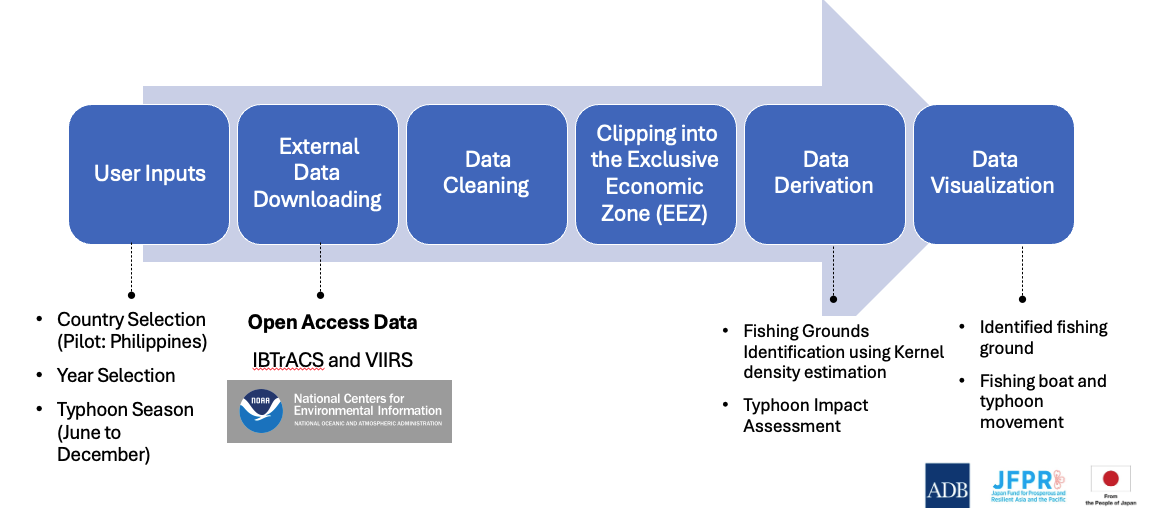

In [1]:
# Install specific versions of libraries in Google Colab
!pip install affine==2.4.0 attrs==24.2.0 beautifulsoup4==4.8.2 bs4==0.0.2 \
certifi==2024.2.2 charset-normalizer==3.3.2 click==8.1.7 click-plugins==1.1.1 \
cligj==0.7.2 contextily==1.6.2 contourpy==1.0.7 cycler==0.10.0 et_xmlfile==1.0.1 \
fonttools==4.39.3 geographiclib==2.0\
geopy==2.3.0 geopandas==0.14.4 idna==3.6 imageio==2.27.0 importlib_metadata==8.4.0 importlib_resources==6.4.5 \
joblib==1.4.2 kiwisolver==1.4.7 matplotlib==3.7.1 mercantile==1.2.1 munch==4.0.0 \
numpy==1.26.4 openpyxl==3.1.2 packaging==24.1 pandas==2.2.1 Pillow==9.5.0 \
psycopg2==2.9.1 pyasn1==0.4.8 pyogrio==0.9.0 pyparsing==3.1.4 \
python-dateutil==2.8.2 pytz==2024.1 rasterio==1.3.11 \
requests==2.31.0 rsa==4.9 Rtree==0.9.7 scipy==1.13.1 seaborn==0.13.2 \
six==1.16.0 snuggs==1.4.7 soupsieve==2.6 tzdata==2024.1 urllib3==2.2.1 \
xyzservices==2024.9.0 zipp==3.20.1 geojson==3.1.0

  Using cached affine-2.4.0-py3-none-any.whl.metadata (4.0 kB)
  Using cached attrs-24.2.0-py3-none-any.whl.metadata (11 kB)
  Using cached beautifulsoup4-4.8.2-py3-none-any.whl.metadata (4.1 kB)
  Using cached bs4-0.0.2-py2.py3-none-any.whl.metadata (411 bytes)
  Using cached certifi-2024.2.2-py3-none-any.whl.metadata (2.2 kB)
  Using cached charset_normalizer-3.3.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (33 kB)
  Using cached click-8.1.7-py3-none-any.whl.metadata (3.0 kB)
  Using cached click_plugins-1.1.1-py2.py3-none-any.whl.metadata (6.4 kB)
  Using cached cligj-0.7.2-py3-none-any.whl.metadata (5.0 kB)
  Using cached contextily-1.6.2-py3-none-any.whl.metadata (2.9 kB)
  Using cached contourpy-1.0.7-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (3.8 kB)
  Using cached cycler-0.10.0-py2.py3-none-any.whl.metadata (722 bytes)
  Using cached et_xmlfile-1.0.1.tar.gz (8.4 kB)
  Preparing metadata (setup.py) ... done
  Using cached fontto

In [1]:
!apt-get install -y libgdal-dev gdal-bin libproj-dev proj-data proj-bin libspatialindex-dev

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
libspatialindex-dev is already the newest version (1.9.3-2).
gdal-bin is already the newest version (3.8.4+dfsg-1~jammy0).
libgdal-dev is already the newest version (3.8.4+dfsg-1~jammy0).
libproj-dev is already the newest version (9.3.1-1~jammy0).
proj-bin is already the newest version (9.3.1-1~jammy0).
proj-data is already the newest version (9.3.1-1~jammy0).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.


In [2]:
""" Import all Python libraries. """

import requests
import json
import os
import csv
import io
import re

import pandas as pd
import geopandas as gpd
from functools import reduce
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mt
import numpy as np
import imageio
from matplotlib import patheffects
import matplotlib.patches as mpatches

import requests
import zipfile
from bs4 import BeautifulSoup

from datetime import datetime

from shapely.geometry import box
from shapely.geometry import Point, Polygon
from datetime import datetime, timedelta
from geopy.distance import geodesic

from scipy import stats
import geojson
from shapely.geometry import shape
from matplotlib.path import Path

from shapely.validation import make_valid
from shapely.errors import TopologicalError

import sys
import glob
import logging


import contextily as ctx

In [55]:
""" Set all directories. """

### User parameters
year_selected = 2024
country = 'phl'

cyclone_seasons = {
    'vnm': {'start_month': 6, 'end_month': 12},
    'fji': {'start_month': 11, 'end_month': 4},
    'vut': {'start_month': 1, 'end_month': 6},
    'phl': {'start_month': 6, 'end_month': 12},
    'bgd': {'start_month': 3, 'end_month': 12},
    'idn': {'start_month': 11, 'end_month': 4},
    'tha-khm': {'start_month': 4, 'end_month': 11},
}

# Directories (in Google Colab)
root_path = os.path.dirname(os.path.abspath("__file__"))

viirs_path = os.path.join(root_path, f'{year_selected}')
gis_path = os.path.join(root_path, 'GIS')
output_path = os.path.join(root_path, 'output')
graphs_path = os.path.join(root_path, 'maps')

try:
    os.makedirs(viirs_path, exist_ok=True)
    os.makedirs(output_path, exist_ok = True)
    os.makedirs(graphs_path, exist_ok = True)

except Exception as e:
    print(e)

viirs_files = os.listdir(viirs_path)
gis_files = os.listdir(gis_path)

print(viirs_path)
print(gis_path)
print(graphs_path)

/content/2024
/content/GIS
/content/maps


## Step 1: Data Extraction
Downloading the VIIRS fishing boats data from the VIIRS website, which will output CSV files from desired time period and area of interest. Similarly for cyclones, we are downloading the data from the IBTrACS website.

In [11]:
# EOG_CLIENT_SECRET= """"
# EOG_USERNAME=""""
# EOG_PASSWORD=""""
# EOG_CLIENT_ID=""""

def get_access_token():
    try:
        # Use fallback to hardcoded values if env vars not set
        username = os.getenv("EOG_USERNAME")
        password = os.getenv("EOG_PASSWORD")

        if not username or not password:
            raise ValueError("Username or password not provided")

        params = {
            "client_id": os.getenv("EOG_CLIENT_ID", ""),
            "client_secret": os.getenv("EOG_CLIENT_SECRET", ""),
            "username": username,
            "password": password,
            "grant_type": "password",
        }
        token_url = "https://eogauth-new.mines.edu/realms/eog/protocol/openid-connect/token"
        response = requests.post(token_url, data=params)
        response.raise_for_status()
        access_token_dict = response.json()
        return access_token_dict.get("access_token")
    except Exception as e:
        print(f"An unexpected error occurred: {e}")
    return None

def download_viirs_data(
    year_selected, country, viirs_path, cyclone_seasons, overwrite=False
):
    current_year = datetime.now().year
    current_month = datetime.now().month
    current_day = datetime.now().day

    access_token = get_access_token()
    headers = {"Authorization": "Bearer " + access_token}
    data_url = f"https://eogdata.mines.edu/wwwdata/viirs_products/vbd/v23/{country}/final/daily/"
    response = requests.get(data_url, verify=False, headers=headers)
    print(f"Response: {response}")

    if response.status_code != 200:
        print(f"Failed to access data URL: {data_url}. Status code: {response.status_code}")
        return

    html = response.text
    print(f"VIIRS Path: {viirs_path}")

    csv_files = []

    if country in cyclone_seasons:
        seasons = (
            cyclone_seasons[country]
            if isinstance(cyclone_seasons[country], list)
            else [cyclone_seasons[country]]
        )

        for season in seasons:
            start_month = season["start_month"]
            end_month = season["end_month"]

            if year_selected < current_year:
                if start_month <= end_month:
                    months_pattern = f"({'|'.join(f'{month:02d}' for month in range(start_month, end_month + 1))})"
                    pattern = rf'href="(VBD_npp_d{year_selected}{months_pattern}(0[1-9]|[12][0-9]|3[01])_{country}_noaa_ops_v23\.csv(\.gz)?)"'
                    csv_files.extend(re.findall(pattern, html))
                else:
                    months_pattern_current_year = f"({'|'.join(f'{month:02d}' for month in range(start_month, 13))})"
                    months_pattern_next_year = f"({'|'.join(f'{month:02d}' for month in range(1, end_month + 1))})"
                    pattern_current_year = rf'href="(VBD_npp_d{year_selected}{months_pattern_current_year}(0[1-9]|[12][0-9]|3[01])_{country}_noaa_ops_v23\.csv(\.gz)?)"'
                    pattern_next_year = rf'href="(VBD_npp_d{year_selected + 1}{months_pattern_next_year}(0[1-9]|[12][0-9]|3[01])_{country}_noaa_ops_v23\.csv(\.gz)?)"'
                    csv_files.extend(
                        re.findall(pattern_current_year, html)
                        + re.findall(pattern_next_year, html)
                    )
            else:
                if start_month <= end_month:
                    months_pattern = f"({'|'.join(f'{month:02d}' for month in range(start_month, current_month + 1))})"
                    days_pattern = (
                        "(0[1-9]|[12][0-9]|3[01])"
                        if current_month > end_month
                        else f"(0[1-9]|[12][0-9]|{current_day:02d})"
                    )
                    pattern = rf'href="(VBD_npp_d{year_selected}{months_pattern}{days_pattern}_{country}_noaa_ops_v23\.csv(\.gz)?)"'
                    csv_files.extend(re.findall(pattern, html))
                else:
                    months_pattern_current_year = f"({'|'.join(f'{month:02d}' for month in range(start_month, 13))})"
                    days_pattern_current = (
                        "(0[1-9]|[12][0-9]|3[01])"
                        if current_month > 12
                        else f"(0[1-9]|[12][0-9]|{current_day:02d})"
                    )
                    months_pattern_next_year = f"({'|'.join(f'{month:02d}' for month in range(1, end_month + 1))})"
                    pattern_current_year = rf'href="(VBD_npp_d{year_selected}{months_pattern_current_year}{days_pattern_current}_{country}_noaa_ops_v23\.csv(\.gz)?)"'
                    pattern_next_year = rf'href="(VBD_npp_d{year_selected + 1}{months_pattern_next_year}(0[1-9]|[12][0-9]|3[01])_{country}_noaa_ops_v23\.csv(\.gz)?)"'
                    csv_files.extend(
                        re.findall(pattern_current_year, html)
                        + re.findall(pattern_next_year, html)
                    )

    if not csv_files:
        print(
            f"No VIIRS data files available for {country} in {year_selected} within the defined cyclone period."
        )
        raise Exception(
            f"No VIIRS data files available for {country} in {year_selected} within the defined cyclone period."
        )

    for csv_file in set(csv_files):
        csv_file_name = csv_file[0]
        print(f"Found file: {csv_file_name}")
        csv_url = data_url + csv_file_name
        csv_file_path = os.path.join(viirs_path, csv_file_name)
        print(f"CSV file path: {csv_file_path}")

        if not overwrite and os.path.exists(csv_file_path):
            print("File already exists and overwrite is set to False. Skipping...")
            continue

        response = requests.get(csv_url, verify=False, headers=headers)

        if response.status_code == 200:
            os.makedirs(os.path.dirname(csv_file_path), exist_ok=True)

            with open(csv_file_path, "wb") as f:
                f.write(response.content)
            print(f"Downloaded and saved: {csv_file_path}")
        else:
            print(f"Failed to download {csv_url}. Status code: {response.status_code}")

download_viirs_data(year_selected, country, viirs_path, cyclone_seasons)

/usr/local/lib/python3.11/dist-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'eogdata.mines.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Response: <Response [200]>
VIIRS Path: /content/2024
Found file: VBD_npp_d20241225_phl_noaa_ops_v23.csv.gz
CSV file path: /content/2024/VBD_npp_d20241225_phl_noaa_ops_v23.csv.gz
Downloaded and saved: /content/2024/VBD_npp_d20241225_phl_noaa_ops_v23.csv.gz
Found file: VBD_npp_d20241220_phl_noaa_ops_v23.csv.gz
CSV file path: /content/2024/VBD_npp_d20241220_phl_noaa_ops_v23.csv.gz


/usr/local/lib/python3.11/dist-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'eogdata.mines.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'eogdata.mines.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Downloaded and saved: /content/2024/VBD_npp_d20241220_phl_noaa_ops_v23.csv.gz
Found file: VBD_npp_d20241218_phl_noaa_ops_v23.csv.gz
CSV file path: /content/2024/VBD_npp_d20241218_phl_noaa_ops_v23.csv.gz
Downloaded and saved: /content/2024/VBD_npp_d20241218_phl_noaa_ops_v23.csv.gz
Found file: VBD_npp_d20240915_phl_noaa_ops_v23.csv.gz
CSV file path: /content/2024/VBD_npp_d20240915_phl_noaa_ops_v23.csv.gz


/usr/local/lib/python3.11/dist-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'eogdata.mines.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'eogdata.mines.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Downloaded and saved: /content/2024/VBD_npp_d20240915_phl_noaa_ops_v23.csv.gz
Found file: VBD_npp_d20240806_phl_noaa_ops_v23.csv.gz
CSV file path: /content/2024/VBD_npp_d20240806_phl_noaa_ops_v23.csv.gz


/usr/local/lib/python3.11/dist-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'eogdata.mines.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Downloaded and saved: /content/2024/VBD_npp_d20240806_phl_noaa_ops_v23.csv.gz
Found file: VBD_npp_d20240629_phl_noaa_ops_v23.csv.gz
CSV file path: /content/2024/VBD_npp_d20240629_phl_noaa_ops_v23.csv.gz


/usr/local/lib/python3.11/dist-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'eogdata.mines.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Downloaded and saved: /content/2024/VBD_npp_d20240629_phl_noaa_ops_v23.csv.gz
Found file: VBD_npp_d20241004_phl_noaa_ops_v23.csv.gz
CSV file path: /content/2024/VBD_npp_d20241004_phl_noaa_ops_v23.csv.gz


/usr/local/lib/python3.11/dist-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'eogdata.mines.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Downloaded and saved: /content/2024/VBD_npp_d20241004_phl_noaa_ops_v23.csv.gz
Found file: VBD_npp_d20241111_phl_noaa_ops_v23.csv.gz
CSV file path: /content/2024/VBD_npp_d20241111_phl_noaa_ops_v23.csv.gz
Downloaded and saved: /content/2024/VBD_npp_d20241111_phl_noaa_ops_v23.csv.gz
Found file: VBD_npp_d20241010_phl_noaa_ops_v23.csv.gz
CSV file path: /content/2024/VBD_npp_d20241010_phl_noaa_ops_v23.csv.gz


/usr/local/lib/python3.11/dist-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'eogdata.mines.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'eogdata.mines.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Downloaded and saved: /content/2024/VBD_npp_d20241010_phl_noaa_ops_v23.csv.gz
Found file: VBD_npp_d20241019_phl_noaa_ops_v23.csv.gz
CSV file path: /content/2024/VBD_npp_d20241019_phl_noaa_ops_v23.csv.gz
Downloaded and saved: /content/2024/VBD_npp_d20241019_phl_noaa_ops_v23.csv.gz
Found file: VBD_npp_d20240901_phl_noaa_ops_v23.csv.gz
CSV file path: /content/2024/VBD_npp_d20240901_phl_noaa_ops_v23.csv.gz


/usr/local/lib/python3.11/dist-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'eogdata.mines.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'eogdata.mines.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Downloaded and saved: /content/2024/VBD_npp_d20240901_phl_noaa_ops_v23.csv.gz
Found file: VBD_npp_d20241215_phl_noaa_ops_v23.csv.gz
CSV file path: /content/2024/VBD_npp_d20241215_phl_noaa_ops_v23.csv.gz
Downloaded and saved: /content/2024/VBD_npp_d20241215_phl_noaa_ops_v23.csv.gz
Found file: VBD_npp_d20240826_phl_noaa_ops_v23.csv.gz
CSV file path: /content/2024/VBD_npp_d20240826_phl_noaa_ops_v23.csv.gz


/usr/local/lib/python3.11/dist-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'eogdata.mines.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'eogdata.mines.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Downloaded and saved: /content/2024/VBD_npp_d20240826_phl_noaa_ops_v23.csv.gz
Found file: VBD_npp_d20240920_phl_noaa_ops_v23.csv.gz
CSV file path: /content/2024/VBD_npp_d20240920_phl_noaa_ops_v23.csv.gz
Downloaded and saved: /content/2024/VBD_npp_d20240920_phl_noaa_ops_v23.csv.gz
Found file: VBD_npp_d20241005_phl_noaa_ops_v23.csv.gz
CSV file path: /content/2024/VBD_npp_d20241005_phl_noaa_ops_v23.csv.gz


/usr/local/lib/python3.11/dist-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'eogdata.mines.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'eogdata.mines.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Downloaded and saved: /content/2024/VBD_npp_d20241005_phl_noaa_ops_v23.csv.gz
Found file: VBD_npp_d20241015_phl_noaa_ops_v23.csv.gz
CSV file path: /content/2024/VBD_npp_d20241015_phl_noaa_ops_v23.csv.gz
Downloaded and saved: /content/2024/VBD_npp_d20241015_phl_noaa_ops_v23.csv.gz
Found file: VBD_npp_d20241017_phl_noaa_ops_v23.csv.gz
CSV file path: /content/2024/VBD_npp_d20241017_phl_noaa_ops_v23.csv.gz


/usr/local/lib/python3.11/dist-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'eogdata.mines.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'eogdata.mines.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Downloaded and saved: /content/2024/VBD_npp_d20241017_phl_noaa_ops_v23.csv.gz
Found file: VBD_npp_d20241210_phl_noaa_ops_v23.csv.gz
CSV file path: /content/2024/VBD_npp_d20241210_phl_noaa_ops_v23.csv.gz
Downloaded and saved: /content/2024/VBD_npp_d20241210_phl_noaa_ops_v23.csv.gz
Found file: VBD_npp_d20240907_phl_noaa_ops_v23.csv.gz
CSV file path: /content/2024/VBD_npp_d20240907_phl_noaa_ops_v23.csv.gz


/usr/local/lib/python3.11/dist-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'eogdata.mines.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'eogdata.mines.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Downloaded and saved: /content/2024/VBD_npp_d20240907_phl_noaa_ops_v23.csv.gz
Found file: VBD_npp_d20241120_phl_noaa_ops_v23.csv.gz
CSV file path: /content/2024/VBD_npp_d20241120_phl_noaa_ops_v23.csv.gz


/usr/local/lib/python3.11/dist-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'eogdata.mines.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Downloaded and saved: /content/2024/VBD_npp_d20241120_phl_noaa_ops_v23.csv.gz
Found file: VBD_npp_d20240914_phl_noaa_ops_v23.csv.gz
CSV file path: /content/2024/VBD_npp_d20240914_phl_noaa_ops_v23.csv.gz
Downloaded and saved: /content/2024/VBD_npp_d20240914_phl_noaa_ops_v23.csv.gz
Found file: VBD_npp_d20240808_phl_noaa_ops_v23.csv.gz
CSV file path: /content/2024/VBD_npp_d20240808_phl_noaa_ops_v23.csv.gz


/usr/local/lib/python3.11/dist-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'eogdata.mines.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'eogdata.mines.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Downloaded and saved: /content/2024/VBD_npp_d20240808_phl_noaa_ops_v23.csv.gz
Found file: VBD_npp_d20241119_phl_noaa_ops_v23.csv.gz
CSV file path: /content/2024/VBD_npp_d20241119_phl_noaa_ops_v23.csv.gz
Downloaded and saved: /content/2024/VBD_npp_d20241119_phl_noaa_ops_v23.csv.gz
Found file: VBD_npp_d20240706_phl_noaa_ops_v23.csv.gz
CSV file path: /content/2024/VBD_npp_d20240706_phl_noaa_ops_v23.csv.gz


/usr/local/lib/python3.11/dist-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'eogdata.mines.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'eogdata.mines.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Downloaded and saved: /content/2024/VBD_npp_d20240706_phl_noaa_ops_v23.csv.gz
Found file: VBD_npp_d20240909_phl_noaa_ops_v23.csv.gz
CSV file path: /content/2024/VBD_npp_d20240909_phl_noaa_ops_v23.csv.gz


/usr/local/lib/python3.11/dist-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'eogdata.mines.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Downloaded and saved: /content/2024/VBD_npp_d20240909_phl_noaa_ops_v23.csv.gz
Found file: VBD_npp_d20240828_phl_noaa_ops_v23.csv.gz
CSV file path: /content/2024/VBD_npp_d20240828_phl_noaa_ops_v23.csv.gz


/usr/local/lib/python3.11/dist-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'eogdata.mines.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Downloaded and saved: /content/2024/VBD_npp_d20240828_phl_noaa_ops_v23.csv.gz
Found file: VBD_npp_d20241208_phl_noaa_ops_v23.csv.gz
CSV file path: /content/2024/VBD_npp_d20241208_phl_noaa_ops_v23.csv.gz
Downloaded and saved: /content/2024/VBD_npp_d20241208_phl_noaa_ops_v23.csv.gz
Found file: VBD_npp_d20241117_phl_noaa_ops_v23.csv.gz
CSV file path: /content/2024/VBD_npp_d20241117_phl_noaa_ops_v23.csv.gz


/usr/local/lib/python3.11/dist-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'eogdata.mines.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'eogdata.mines.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Downloaded and saved: /content/2024/VBD_npp_d20241117_phl_noaa_ops_v23.csv.gz
Found file: VBD_npp_d20241003_phl_noaa_ops_v23.csv.gz
CSV file path: /content/2024/VBD_npp_d20241003_phl_noaa_ops_v23.csv.gz


/usr/local/lib/python3.11/dist-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'eogdata.mines.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Downloaded and saved: /content/2024/VBD_npp_d20241003_phl_noaa_ops_v23.csv.gz
Found file: VBD_npp_d20240810_phl_noaa_ops_v23.csv.gz
CSV file path: /content/2024/VBD_npp_d20240810_phl_noaa_ops_v23.csv.gz


/usr/local/lib/python3.11/dist-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'eogdata.mines.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Downloaded and saved: /content/2024/VBD_npp_d20240810_phl_noaa_ops_v23.csv.gz
Found file: VBD_npp_d20241029_phl_noaa_ops_v23.csv.gz
CSV file path: /content/2024/VBD_npp_d20241029_phl_noaa_ops_v23.csv.gz


/usr/local/lib/python3.11/dist-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'eogdata.mines.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Downloaded and saved: /content/2024/VBD_npp_d20241029_phl_noaa_ops_v23.csv.gz
Found file: VBD_npp_d20240807_phl_noaa_ops_v23.csv.gz
CSV file path: /content/2024/VBD_npp_d20240807_phl_noaa_ops_v23.csv.gz


/usr/local/lib/python3.11/dist-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'eogdata.mines.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Downloaded and saved: /content/2024/VBD_npp_d20240807_phl_noaa_ops_v23.csv.gz
Found file: VBD_npp_d20241030_phl_noaa_ops_v23.csv.gz
CSV file path: /content/2024/VBD_npp_d20241030_phl_noaa_ops_v23.csv.gz


/usr/local/lib/python3.11/dist-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'eogdata.mines.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Downloaded and saved: /content/2024/VBD_npp_d20241030_phl_noaa_ops_v23.csv.gz
Found file: VBD_npp_d20241101_phl_noaa_ops_v23.csv.gz
CSV file path: /content/2024/VBD_npp_d20241101_phl_noaa_ops_v23.csv.gz


/usr/local/lib/python3.11/dist-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'eogdata.mines.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Downloaded and saved: /content/2024/VBD_npp_d20241101_phl_noaa_ops_v23.csv.gz
Found file: VBD_npp_d20240704_phl_noaa_ops_v23.csv.gz
CSV file path: /content/2024/VBD_npp_d20240704_phl_noaa_ops_v23.csv.gz


/usr/local/lib/python3.11/dist-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'eogdata.mines.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Downloaded and saved: /content/2024/VBD_npp_d20240704_phl_noaa_ops_v23.csv.gz
Found file: VBD_npp_d20240802_phl_noaa_ops_v23.csv.gz
CSV file path: /content/2024/VBD_npp_d20240802_phl_noaa_ops_v23.csv.gz


/usr/local/lib/python3.11/dist-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'eogdata.mines.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Downloaded and saved: /content/2024/VBD_npp_d20240802_phl_noaa_ops_v23.csv.gz
Found file: VBD_npp_d20240911_phl_noaa_ops_v23.csv.gz
CSV file path: /content/2024/VBD_npp_d20240911_phl_noaa_ops_v23.csv.gz


/usr/local/lib/python3.11/dist-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'eogdata.mines.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Downloaded and saved: /content/2024/VBD_npp_d20240911_phl_noaa_ops_v23.csv.gz
Found file: VBD_npp_d20241024_phl_noaa_ops_v23.csv.gz
CSV file path: /content/2024/VBD_npp_d20241024_phl_noaa_ops_v23.csv.gz
Downloaded and saved: /content/2024/VBD_npp_d20241024_phl_noaa_ops_v23.csv.gz
Found file: VBD_npp_d20241031_phl_noaa_ops_v23.csv.gz
CSV file path: /content/2024/VBD_npp_d20241031_phl_noaa_ops_v23.csv.gz


/usr/local/lib/python3.11/dist-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'eogdata.mines.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'eogdata.mines.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Downloaded and saved: /content/2024/VBD_npp_d20241031_phl_noaa_ops_v23.csv.gz
Found file: VBD_npp_d20240611_phl_noaa_ops_v23.csv.gz
CSV file path: /content/2024/VBD_npp_d20240611_phl_noaa_ops_v23.csv.gz


/usr/local/lib/python3.11/dist-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'eogdata.mines.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Downloaded and saved: /content/2024/VBD_npp_d20240611_phl_noaa_ops_v23.csv.gz
Found file: VBD_npp_d20240821_phl_noaa_ops_v23.csv.gz
CSV file path: /content/2024/VBD_npp_d20240821_phl_noaa_ops_v23.csv.gz
Downloaded and saved: /content/2024/VBD_npp_d20240821_phl_noaa_ops_v23.csv.gz
Found file: VBD_npp_d20241012_phl_noaa_ops_v23.csv.gz
CSV file path: /content/2024/VBD_npp_d20241012_phl_noaa_ops_v23.csv.gz


/usr/local/lib/python3.11/dist-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'eogdata.mines.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'eogdata.mines.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Downloaded and saved: /content/2024/VBD_npp_d20241012_phl_noaa_ops_v23.csv.gz
Found file: VBD_npp_d20241216_phl_noaa_ops_v23.csv.gz
CSV file path: /content/2024/VBD_npp_d20241216_phl_noaa_ops_v23.csv.gz
Downloaded and saved: /content/2024/VBD_npp_d20241216_phl_noaa_ops_v23.csv.gz
Found file: VBD_npp_d20240922_phl_noaa_ops_v23.csv.gz
CSV file path: /content/2024/VBD_npp_d20240922_phl_noaa_ops_v23.csv.gz


/usr/local/lib/python3.11/dist-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'eogdata.mines.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'eogdata.mines.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Downloaded and saved: /content/2024/VBD_npp_d20240922_phl_noaa_ops_v23.csv.gz
Found file: VBD_npp_d20240908_phl_noaa_ops_v23.csv.gz
CSV file path: /content/2024/VBD_npp_d20240908_phl_noaa_ops_v23.csv.gz


/usr/local/lib/python3.11/dist-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'eogdata.mines.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Downloaded and saved: /content/2024/VBD_npp_d20240908_phl_noaa_ops_v23.csv.gz
Found file: VBD_npp_d20241109_phl_noaa_ops_v23.csv.gz
CSV file path: /content/2024/VBD_npp_d20241109_phl_noaa_ops_v23.csv.gz


/usr/local/lib/python3.11/dist-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'eogdata.mines.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Downloaded and saved: /content/2024/VBD_npp_d20241109_phl_noaa_ops_v23.csv.gz
Found file: VBD_npp_d20241124_phl_noaa_ops_v23.csv.gz
CSV file path: /content/2024/VBD_npp_d20241124_phl_noaa_ops_v23.csv.gz
Downloaded and saved: /content/2024/VBD_npp_d20241124_phl_noaa_ops_v23.csv.gz
Found file: VBD_npp_d20240619_phl_noaa_ops_v23.csv.gz
CSV file path: /content/2024/VBD_npp_d20240619_phl_noaa_ops_v23.csv.gz


/usr/local/lib/python3.11/dist-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'eogdata.mines.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'eogdata.mines.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Downloaded and saved: /content/2024/VBD_npp_d20240619_phl_noaa_ops_v23.csv.gz
Found file: VBD_npp_d20240822_phl_noaa_ops_v23.csv.gz
CSV file path: /content/2024/VBD_npp_d20240822_phl_noaa_ops_v23.csv.gz
Downloaded and saved: /content/2024/VBD_npp_d20240822_phl_noaa_ops_v23.csv.gz
Found file: VBD_npp_d20240606_phl_noaa_ops_v23.csv.gz
CSV file path: /content/2024/VBD_npp_d20240606_phl_noaa_ops_v23.csv.gz


/usr/local/lib/python3.11/dist-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'eogdata.mines.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'eogdata.mines.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Downloaded and saved: /content/2024/VBD_npp_d20240606_phl_noaa_ops_v23.csv.gz
Found file: VBD_npp_d20240924_phl_noaa_ops_v23.csv.gz
CSV file path: /content/2024/VBD_npp_d20240924_phl_noaa_ops_v23.csv.gz


/usr/local/lib/python3.11/dist-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'eogdata.mines.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Downloaded and saved: /content/2024/VBD_npp_d20240924_phl_noaa_ops_v23.csv.gz
Found file: VBD_npp_d20241020_phl_noaa_ops_v23.csv.gz
CSV file path: /content/2024/VBD_npp_d20241020_phl_noaa_ops_v23.csv.gz
Downloaded and saved: /content/2024/VBD_npp_d20241020_phl_noaa_ops_v23.csv.gz
Found file: VBD_npp_d20240910_phl_noaa_ops_v23.csv.gz
CSV file path: /content/2024/VBD_npp_d20240910_phl_noaa_ops_v23.csv.gz


/usr/local/lib/python3.11/dist-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'eogdata.mines.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'eogdata.mines.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Downloaded and saved: /content/2024/VBD_npp_d20240910_phl_noaa_ops_v23.csv.gz
Found file: VBD_npp_d20241126_phl_noaa_ops_v23.csv.gz
CSV file path: /content/2024/VBD_npp_d20241126_phl_noaa_ops_v23.csv.gz


/usr/local/lib/python3.11/dist-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'eogdata.mines.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Downloaded and saved: /content/2024/VBD_npp_d20241126_phl_noaa_ops_v23.csv.gz
Found file: VBD_npp_d20241016_phl_noaa_ops_v23.csv.gz
CSV file path: /content/2024/VBD_npp_d20241016_phl_noaa_ops_v23.csv.gz
Downloaded and saved: /content/2024/VBD_npp_d20241016_phl_noaa_ops_v23.csv.gz
Found file: VBD_npp_d20240923_phl_noaa_ops_v23.csv.gz
CSV file path: /content/2024/VBD_npp_d20240923_phl_noaa_ops_v23.csv.gz


/usr/local/lib/python3.11/dist-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'eogdata.mines.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'eogdata.mines.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Downloaded and saved: /content/2024/VBD_npp_d20240923_phl_noaa_ops_v23.csv.gz
Found file: VBD_npp_d20241027_phl_noaa_ops_v23.csv.gz
CSV file path: /content/2024/VBD_npp_d20241027_phl_noaa_ops_v23.csv.gz


/usr/local/lib/python3.11/dist-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'eogdata.mines.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Downloaded and saved: /content/2024/VBD_npp_d20241027_phl_noaa_ops_v23.csv.gz
Found file: VBD_npp_d20240918_phl_noaa_ops_v23.csv.gz
CSV file path: /content/2024/VBD_npp_d20240918_phl_noaa_ops_v23.csv.gz
Downloaded and saved: /content/2024/VBD_npp_d20240918_phl_noaa_ops_v23.csv.gz
Found file: VBD_npp_d20240912_phl_noaa_ops_v23.csv.gz
CSV file path: /content/2024/VBD_npp_d20240912_phl_noaa_ops_v23.csv.gz


/usr/local/lib/python3.11/dist-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'eogdata.mines.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'eogdata.mines.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Downloaded and saved: /content/2024/VBD_npp_d20240912_phl_noaa_ops_v23.csv.gz
Found file: VBD_npp_d20240811_phl_noaa_ops_v23.csv.gz
CSV file path: /content/2024/VBD_npp_d20240811_phl_noaa_ops_v23.csv.gz


/usr/local/lib/python3.11/dist-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'eogdata.mines.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Downloaded and saved: /content/2024/VBD_npp_d20240811_phl_noaa_ops_v23.csv.gz
Found file: VBD_npp_d20240819_phl_noaa_ops_v23.csv.gz
CSV file path: /content/2024/VBD_npp_d20240819_phl_noaa_ops_v23.csv.gz
Downloaded and saved: /content/2024/VBD_npp_d20240819_phl_noaa_ops_v23.csv.gz
Found file: VBD_npp_d20240610_phl_noaa_ops_v23.csv.gz
CSV file path: /content/2024/VBD_npp_d20240610_phl_noaa_ops_v23.csv.gz


/usr/local/lib/python3.11/dist-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'eogdata.mines.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'eogdata.mines.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Downloaded and saved: /content/2024/VBD_npp_d20240610_phl_noaa_ops_v23.csv.gz
Found file: VBD_npp_d20240804_phl_noaa_ops_v23.csv.gz
CSV file path: /content/2024/VBD_npp_d20240804_phl_noaa_ops_v23.csv.gz


/usr/local/lib/python3.11/dist-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'eogdata.mines.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Downloaded and saved: /content/2024/VBD_npp_d20240804_phl_noaa_ops_v23.csv.gz
Found file: VBD_npp_d20241122_phl_noaa_ops_v23.csv.gz
CSV file path: /content/2024/VBD_npp_d20241122_phl_noaa_ops_v23.csv.gz
Downloaded and saved: /content/2024/VBD_npp_d20241122_phl_noaa_ops_v23.csv.gz
Found file: VBD_npp_d20240622_phl_noaa_ops_v23.csv.gz
CSV file path: /content/2024/VBD_npp_d20240622_phl_noaa_ops_v23.csv.gz


/usr/local/lib/python3.11/dist-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'eogdata.mines.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'eogdata.mines.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Downloaded and saved: /content/2024/VBD_npp_d20240622_phl_noaa_ops_v23.csv.gz
Found file: VBD_npp_d20241112_phl_noaa_ops_v23.csv.gz
CSV file path: /content/2024/VBD_npp_d20241112_phl_noaa_ops_v23.csv.gz
Downloaded and saved: /content/2024/VBD_npp_d20241112_phl_noaa_ops_v23.csv.gz
Found file: VBD_npp_d20240609_phl_noaa_ops_v23.csv.gz
CSV file path: /content/2024/VBD_npp_d20240609_phl_noaa_ops_v23.csv.gz


/usr/local/lib/python3.11/dist-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'eogdata.mines.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'eogdata.mines.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Downloaded and saved: /content/2024/VBD_npp_d20240609_phl_noaa_ops_v23.csv.gz
Found file: VBD_npp_d20241011_phl_noaa_ops_v23.csv.gz
CSV file path: /content/2024/VBD_npp_d20241011_phl_noaa_ops_v23.csv.gz


/usr/local/lib/python3.11/dist-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'eogdata.mines.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Downloaded and saved: /content/2024/VBD_npp_d20241011_phl_noaa_ops_v23.csv.gz
Found file: VBD_npp_d20240812_phl_noaa_ops_v23.csv.gz
CSV file path: /content/2024/VBD_npp_d20240812_phl_noaa_ops_v23.csv.gz


/usr/local/lib/python3.11/dist-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'eogdata.mines.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Downloaded and saved: /content/2024/VBD_npp_d20240812_phl_noaa_ops_v23.csv.gz
Found file: VBD_npp_d20241127_phl_noaa_ops_v23.csv.gz
CSV file path: /content/2024/VBD_npp_d20241127_phl_noaa_ops_v23.csv.gz


/usr/local/lib/python3.11/dist-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'eogdata.mines.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Downloaded and saved: /content/2024/VBD_npp_d20241127_phl_noaa_ops_v23.csv.gz
Found file: VBD_npp_d20241212_phl_noaa_ops_v23.csv.gz
CSV file path: /content/2024/VBD_npp_d20241212_phl_noaa_ops_v23.csv.gz
Downloaded and saved: /content/2024/VBD_npp_d20241212_phl_noaa_ops_v23.csv.gz
Found file: VBD_npp_d20241007_phl_noaa_ops_v23.csv.gz
CSV file path: /content/2024/VBD_npp_d20241007_phl_noaa_ops_v23.csv.gz


/usr/local/lib/python3.11/dist-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'eogdata.mines.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'eogdata.mines.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Downloaded and saved: /content/2024/VBD_npp_d20241007_phl_noaa_ops_v23.csv.gz
Found file: VBD_npp_d20240623_phl_noaa_ops_v23.csv.gz
CSV file path: /content/2024/VBD_npp_d20240623_phl_noaa_ops_v23.csv.gz
Downloaded and saved: /content/2024/VBD_npp_d20240623_phl_noaa_ops_v23.csv.gz
Found file: VBD_npp_d20241002_phl_noaa_ops_v23.csv.gz
CSV file path: /content/2024/VBD_npp_d20241002_phl_noaa_ops_v23.csv.gz


/usr/local/lib/python3.11/dist-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'eogdata.mines.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'eogdata.mines.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Downloaded and saved: /content/2024/VBD_npp_d20241002_phl_noaa_ops_v23.csv.gz
Found file: VBD_npp_d20240630_phl_noaa_ops_v23.csv.gz
CSV file path: /content/2024/VBD_npp_d20240630_phl_noaa_ops_v23.csv.gz


/usr/local/lib/python3.11/dist-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'eogdata.mines.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Downloaded and saved: /content/2024/VBD_npp_d20240630_phl_noaa_ops_v23.csv.gz
Found file: VBD_npp_d20241026_phl_noaa_ops_v23.csv.gz
CSV file path: /content/2024/VBD_npp_d20241026_phl_noaa_ops_v23.csv.gz
Downloaded and saved: /content/2024/VBD_npp_d20241026_phl_noaa_ops_v23.csv.gz
Found file: VBD_npp_d20241018_phl_noaa_ops_v23.csv.gz
CSV file path: /content/2024/VBD_npp_d20241018_phl_noaa_ops_v23.csv.gz


/usr/local/lib/python3.11/dist-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'eogdata.mines.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'eogdata.mines.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Downloaded and saved: /content/2024/VBD_npp_d20241018_phl_noaa_ops_v23.csv.gz
Found file: VBD_npp_d20241230_phl_noaa_ops_v23.csv.gz
CSV file path: /content/2024/VBD_npp_d20241230_phl_noaa_ops_v23.csv.gz
Downloaded and saved: /content/2024/VBD_npp_d20241230_phl_noaa_ops_v23.csv.gz
Found file: VBD_npp_d20241228_phl_noaa_ops_v23.csv.gz
CSV file path: /content/2024/VBD_npp_d20241228_phl_noaa_ops_v23.csv.gz


/usr/local/lib/python3.11/dist-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'eogdata.mines.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'eogdata.mines.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Downloaded and saved: /content/2024/VBD_npp_d20241228_phl_noaa_ops_v23.csv.gz
Found file: VBD_npp_d20241028_phl_noaa_ops_v23.csv.gz
CSV file path: /content/2024/VBD_npp_d20241028_phl_noaa_ops_v23.csv.gz
Downloaded and saved: /content/2024/VBD_npp_d20241028_phl_noaa_ops_v23.csv.gz
Found file: VBD_npp_d20240818_phl_noaa_ops_v23.csv.gz
CSV file path: /content/2024/VBD_npp_d20240818_phl_noaa_ops_v23.csv.gz


/usr/local/lib/python3.11/dist-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'eogdata.mines.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'eogdata.mines.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Downloaded and saved: /content/2024/VBD_npp_d20240818_phl_noaa_ops_v23.csv.gz
Found file: VBD_npp_d20240621_phl_noaa_ops_v23.csv.gz
CSV file path: /content/2024/VBD_npp_d20240621_phl_noaa_ops_v23.csv.gz
Downloaded and saved: /content/2024/VBD_npp_d20240621_phl_noaa_ops_v23.csv.gz
Found file: VBD_npp_d20240614_phl_noaa_ops_v23.csv.gz
CSV file path: /content/2024/VBD_npp_d20240614_phl_noaa_ops_v23.csv.gz


/usr/local/lib/python3.11/dist-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'eogdata.mines.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'eogdata.mines.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Downloaded and saved: /content/2024/VBD_npp_d20240614_phl_noaa_ops_v23.csv.gz
Found file: VBD_npp_d20240617_phl_noaa_ops_v23.csv.gz
CSV file path: /content/2024/VBD_npp_d20240617_phl_noaa_ops_v23.csv.gz


/usr/local/lib/python3.11/dist-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'eogdata.mines.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Downloaded and saved: /content/2024/VBD_npp_d20240617_phl_noaa_ops_v23.csv.gz
Found file: VBD_npp_d20240831_phl_noaa_ops_v23.csv.gz
CSV file path: /content/2024/VBD_npp_d20240831_phl_noaa_ops_v23.csv.gz


/usr/local/lib/python3.11/dist-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'eogdata.mines.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Downloaded and saved: /content/2024/VBD_npp_d20240831_phl_noaa_ops_v23.csv.gz
Found file: VBD_npp_d20240702_phl_noaa_ops_v23.csv.gz
CSV file path: /content/2024/VBD_npp_d20240702_phl_noaa_ops_v23.csv.gz


/usr/local/lib/python3.11/dist-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'eogdata.mines.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Downloaded and saved: /content/2024/VBD_npp_d20240702_phl_noaa_ops_v23.csv.gz
Found file: VBD_npp_d20241116_phl_noaa_ops_v23.csv.gz
CSV file path: /content/2024/VBD_npp_d20241116_phl_noaa_ops_v23.csv.gz
Downloaded and saved: /content/2024/VBD_npp_d20241116_phl_noaa_ops_v23.csv.gz
Found file: VBD_npp_d20240827_phl_noaa_ops_v23.csv.gz
CSV file path: /content/2024/VBD_npp_d20240827_phl_noaa_ops_v23.csv.gz


/usr/local/lib/python3.11/dist-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'eogdata.mines.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'eogdata.mines.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Downloaded and saved: /content/2024/VBD_npp_d20240827_phl_noaa_ops_v23.csv.gz
Found file: VBD_npp_d20240616_phl_noaa_ops_v23.csv.gz
CSV file path: /content/2024/VBD_npp_d20240616_phl_noaa_ops_v23.csv.gz


/usr/local/lib/python3.11/dist-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'eogdata.mines.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Downloaded and saved: /content/2024/VBD_npp_d20240616_phl_noaa_ops_v23.csv.gz
Found file: VBD_npp_d20240723_phl_noaa_ops_v23.csv.gz
CSV file path: /content/2024/VBD_npp_d20240723_phl_noaa_ops_v23.csv.gz
Downloaded and saved: /content/2024/VBD_npp_d20240723_phl_noaa_ops_v23.csv.gz
Found file: VBD_npp_d20241214_phl_noaa_ops_v23.csv.gz
CSV file path: /content/2024/VBD_npp_d20241214_phl_noaa_ops_v23.csv.gz


/usr/local/lib/python3.11/dist-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'eogdata.mines.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'eogdata.mines.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Downloaded and saved: /content/2024/VBD_npp_d20241214_phl_noaa_ops_v23.csv.gz
Found file: VBD_npp_d20240904_phl_noaa_ops_v23.csv.gz
CSV file path: /content/2024/VBD_npp_d20240904_phl_noaa_ops_v23.csv.gz


/usr/local/lib/python3.11/dist-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'eogdata.mines.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Downloaded and saved: /content/2024/VBD_npp_d20240904_phl_noaa_ops_v23.csv.gz
Found file: VBD_npp_d20241202_phl_noaa_ops_v23.csv.gz
CSV file path: /content/2024/VBD_npp_d20241202_phl_noaa_ops_v23.csv.gz


/usr/local/lib/python3.11/dist-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'eogdata.mines.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Downloaded and saved: /content/2024/VBD_npp_d20241202_phl_noaa_ops_v23.csv.gz
Found file: VBD_npp_d20240703_phl_noaa_ops_v23.csv.gz
CSV file path: /content/2024/VBD_npp_d20240703_phl_noaa_ops_v23.csv.gz


/usr/local/lib/python3.11/dist-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'eogdata.mines.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Downloaded and saved: /content/2024/VBD_npp_d20240703_phl_noaa_ops_v23.csv.gz
Found file: VBD_npp_d20241113_phl_noaa_ops_v23.csv.gz
CSV file path: /content/2024/VBD_npp_d20241113_phl_noaa_ops_v23.csv.gz


/usr/local/lib/python3.11/dist-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'eogdata.mines.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Downloaded and saved: /content/2024/VBD_npp_d20241113_phl_noaa_ops_v23.csv.gz
Found file: VBD_npp_d20240708_phl_noaa_ops_v23.csv.gz
CSV file path: /content/2024/VBD_npp_d20240708_phl_noaa_ops_v23.csv.gz


/usr/local/lib/python3.11/dist-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'eogdata.mines.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Downloaded and saved: /content/2024/VBD_npp_d20240708_phl_noaa_ops_v23.csv.gz
Found file: VBD_npp_d20240618_phl_noaa_ops_v23.csv.gz
CSV file path: /content/2024/VBD_npp_d20240618_phl_noaa_ops_v23.csv.gz
Downloaded and saved: /content/2024/VBD_npp_d20240618_phl_noaa_ops_v23.csv.gz
Found file: VBD_npp_d20241125_phl_noaa_ops_v23.csv.gz
CSV file path: /content/2024/VBD_npp_d20241125_phl_noaa_ops_v23.csv.gz


/usr/local/lib/python3.11/dist-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'eogdata.mines.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'eogdata.mines.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Downloaded and saved: /content/2024/VBD_npp_d20241125_phl_noaa_ops_v23.csv.gz
Found file: VBD_npp_d20241129_phl_noaa_ops_v23.csv.gz
CSV file path: /content/2024/VBD_npp_d20241129_phl_noaa_ops_v23.csv.gz


/usr/local/lib/python3.11/dist-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'eogdata.mines.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Downloaded and saved: /content/2024/VBD_npp_d20241129_phl_noaa_ops_v23.csv.gz
Found file: VBD_npp_d20240829_phl_noaa_ops_v23.csv.gz
CSV file path: /content/2024/VBD_npp_d20240829_phl_noaa_ops_v23.csv.gz


/usr/local/lib/python3.11/dist-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'eogdata.mines.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Downloaded and saved: /content/2024/VBD_npp_d20240829_phl_noaa_ops_v23.csv.gz
Found file: VBD_npp_d20240825_phl_noaa_ops_v23.csv.gz
CSV file path: /content/2024/VBD_npp_d20240825_phl_noaa_ops_v23.csv.gz


/usr/local/lib/python3.11/dist-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'eogdata.mines.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Downloaded and saved: /content/2024/VBD_npp_d20240825_phl_noaa_ops_v23.csv.gz
Found file: VBD_npp_d20240817_phl_noaa_ops_v23.csv.gz
CSV file path: /content/2024/VBD_npp_d20240817_phl_noaa_ops_v23.csv.gz
Downloaded and saved: /content/2024/VBD_npp_d20240817_phl_noaa_ops_v23.csv.gz
Found file: VBD_npp_d20241009_phl_noaa_ops_v23.csv.gz
CSV file path: /content/2024/VBD_npp_d20241009_phl_noaa_ops_v23.csv.gz


/usr/local/lib/python3.11/dist-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'eogdata.mines.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'eogdata.mines.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Downloaded and saved: /content/2024/VBD_npp_d20241009_phl_noaa_ops_v23.csv.gz
Found file: VBD_npp_d20240718_phl_noaa_ops_v23.csv.gz
CSV file path: /content/2024/VBD_npp_d20240718_phl_noaa_ops_v23.csv.gz
Downloaded and saved: /content/2024/VBD_npp_d20240718_phl_noaa_ops_v23.csv.gz
Found file: VBD_npp_d20240613_phl_noaa_ops_v23.csv.gz
CSV file path: /content/2024/VBD_npp_d20240613_phl_noaa_ops_v23.csv.gz


/usr/local/lib/python3.11/dist-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'eogdata.mines.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'eogdata.mines.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Downloaded and saved: /content/2024/VBD_npp_d20240613_phl_noaa_ops_v23.csv.gz
Found file: VBD_npp_d20240608_phl_noaa_ops_v23.csv.gz
CSV file path: /content/2024/VBD_npp_d20240608_phl_noaa_ops_v23.csv.gz


/usr/local/lib/python3.11/dist-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'eogdata.mines.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Downloaded and saved: /content/2024/VBD_npp_d20240608_phl_noaa_ops_v23.csv.gz
Found file: VBD_npp_d20240620_phl_noaa_ops_v23.csv.gz
CSV file path: /content/2024/VBD_npp_d20240620_phl_noaa_ops_v23.csv.gz
Downloaded and saved: /content/2024/VBD_npp_d20240620_phl_noaa_ops_v23.csv.gz
Found file: VBD_npp_d20241223_phl_noaa_ops_v23.csv.gz
CSV file path: /content/2024/VBD_npp_d20241223_phl_noaa_ops_v23.csv.gz


/usr/local/lib/python3.11/dist-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'eogdata.mines.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'eogdata.mines.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Downloaded and saved: /content/2024/VBD_npp_d20241223_phl_noaa_ops_v23.csv.gz
Found file: VBD_npp_d20240814_phl_noaa_ops_v23.csv.gz
CSV file path: /content/2024/VBD_npp_d20240814_phl_noaa_ops_v23.csv.gz


/usr/local/lib/python3.11/dist-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'eogdata.mines.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Downloaded and saved: /content/2024/VBD_npp_d20240814_phl_noaa_ops_v23.csv.gz
Found file: VBD_npp_d20240916_phl_noaa_ops_v23.csv.gz
CSV file path: /content/2024/VBD_npp_d20240916_phl_noaa_ops_v23.csv.gz
Downloaded and saved: /content/2024/VBD_npp_d20240916_phl_noaa_ops_v23.csv.gz
Found file: VBD_npp_d20240605_phl_noaa_ops_v23.csv.gz
CSV file path: /content/2024/VBD_npp_d20240605_phl_noaa_ops_v23.csv.gz


/usr/local/lib/python3.11/dist-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'eogdata.mines.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'eogdata.mines.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Downloaded and saved: /content/2024/VBD_npp_d20240605_phl_noaa_ops_v23.csv.gz
Found file: VBD_npp_d20240720_phl_noaa_ops_v23.csv.gz
CSV file path: /content/2024/VBD_npp_d20240720_phl_noaa_ops_v23.csv.gz
Downloaded and saved: /content/2024/VBD_npp_d20240720_phl_noaa_ops_v23.csv.gz
Found file: VBD_npp_d20240707_phl_noaa_ops_v23.csv.gz
CSV file path: /content/2024/VBD_npp_d20240707_phl_noaa_ops_v23.csv.gz


/usr/local/lib/python3.11/dist-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'eogdata.mines.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'eogdata.mines.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Downloaded and saved: /content/2024/VBD_npp_d20240707_phl_noaa_ops_v23.csv.gz
Found file: VBD_npp_d20241222_phl_noaa_ops_v23.csv.gz
CSV file path: /content/2024/VBD_npp_d20241222_phl_noaa_ops_v23.csv.gz
Downloaded and saved: /content/2024/VBD_npp_d20241222_phl_noaa_ops_v23.csv.gz
Found file: VBD_npp_d20241006_phl_noaa_ops_v23.csv.gz
CSV file path: /content/2024/VBD_npp_d20241006_phl_noaa_ops_v23.csv.gz


/usr/local/lib/python3.11/dist-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'eogdata.mines.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'eogdata.mines.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Downloaded and saved: /content/2024/VBD_npp_d20241006_phl_noaa_ops_v23.csv.gz
Found file: VBD_npp_d20240705_phl_noaa_ops_v23.csv.gz
CSV file path: /content/2024/VBD_npp_d20240705_phl_noaa_ops_v23.csv.gz


/usr/local/lib/python3.11/dist-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'eogdata.mines.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Downloaded and saved: /content/2024/VBD_npp_d20240705_phl_noaa_ops_v23.csv.gz
Found file: VBD_npp_d20241224_phl_noaa_ops_v23.csv.gz
CSV file path: /content/2024/VBD_npp_d20241224_phl_noaa_ops_v23.csv.gz
Downloaded and saved: /content/2024/VBD_npp_d20241224_phl_noaa_ops_v23.csv.gz
Found file: VBD_npp_d20240805_phl_noaa_ops_v23.csv.gz
CSV file path: /content/2024/VBD_npp_d20240805_phl_noaa_ops_v23.csv.gz


/usr/local/lib/python3.11/dist-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'eogdata.mines.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'eogdata.mines.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Downloaded and saved: /content/2024/VBD_npp_d20240805_phl_noaa_ops_v23.csv.gz
Found file: VBD_npp_d20241221_phl_noaa_ops_v23.csv.gz
CSV file path: /content/2024/VBD_npp_d20241221_phl_noaa_ops_v23.csv.gz
Downloaded and saved: /content/2024/VBD_npp_d20241221_phl_noaa_ops_v23.csv.gz
Found file: VBD_npp_d20241130_phl_noaa_ops_v23.csv.gz
CSV file path: /content/2024/VBD_npp_d20241130_phl_noaa_ops_v23.csv.gz


/usr/local/lib/python3.11/dist-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'eogdata.mines.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'eogdata.mines.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Downloaded and saved: /content/2024/VBD_npp_d20241130_phl_noaa_ops_v23.csv.gz
Found file: VBD_npp_d20240709_phl_noaa_ops_v23.csv.gz
CSV file path: /content/2024/VBD_npp_d20240709_phl_noaa_ops_v23.csv.gz


/usr/local/lib/python3.11/dist-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'eogdata.mines.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Downloaded and saved: /content/2024/VBD_npp_d20240709_phl_noaa_ops_v23.csv.gz
Found file: VBD_npp_d20241207_phl_noaa_ops_v23.csv.gz
CSV file path: /content/2024/VBD_npp_d20241207_phl_noaa_ops_v23.csv.gz
Downloaded and saved: /content/2024/VBD_npp_d20241207_phl_noaa_ops_v23.csv.gz
Found file: VBD_npp_d20241213_phl_noaa_ops_v23.csv.gz
CSV file path: /content/2024/VBD_npp_d20241213_phl_noaa_ops_v23.csv.gz


/usr/local/lib/python3.11/dist-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'eogdata.mines.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'eogdata.mines.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'eogdata.mines.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Downloaded and saved: /content/2024/VBD_npp_d20241213_phl_noaa_ops_v23.csv.gz
Found file: VBD_npp_d20241206_phl_noaa_ops_v23.csv.gz
CSV file path: /content/2024/VBD_npp_d20241206_phl_noaa_ops_v23.csv.gz
Downloaded and saved: /content/2024/VBD_npp_d20241206_phl_noaa_ops_v23.csv.gz
Found file: VBD_npp_d20240628_phl_noaa_ops_v23.csv.gz
CSV file path: /content/2024/VBD_npp_d20240628_phl_noaa_ops_v23.csv.gz


/usr/local/lib/python3.11/dist-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'eogdata.mines.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Downloaded and saved: /content/2024/VBD_npp_d20240628_phl_noaa_ops_v23.csv.gz
Found file: VBD_npp_d20240824_phl_noaa_ops_v23.csv.gz
CSV file path: /content/2024/VBD_npp_d20240824_phl_noaa_ops_v23.csv.gz


/usr/local/lib/python3.11/dist-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'eogdata.mines.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Downloaded and saved: /content/2024/VBD_npp_d20240824_phl_noaa_ops_v23.csv.gz
Found file: VBD_npp_d20241201_phl_noaa_ops_v23.csv.gz
CSV file path: /content/2024/VBD_npp_d20241201_phl_noaa_ops_v23.csv.gz


/usr/local/lib/python3.11/dist-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'eogdata.mines.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Downloaded and saved: /content/2024/VBD_npp_d20241201_phl_noaa_ops_v23.csv.gz
Found file: VBD_npp_d20241203_phl_noaa_ops_v23.csv.gz
CSV file path: /content/2024/VBD_npp_d20241203_phl_noaa_ops_v23.csv.gz


/usr/local/lib/python3.11/dist-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'eogdata.mines.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Downloaded and saved: /content/2024/VBD_npp_d20241203_phl_noaa_ops_v23.csv.gz
Found file: VBD_npp_d20241102_phl_noaa_ops_v23.csv.gz
CSV file path: /content/2024/VBD_npp_d20241102_phl_noaa_ops_v23.csv.gz


/usr/local/lib/python3.11/dist-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'eogdata.mines.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Downloaded and saved: /content/2024/VBD_npp_d20241102_phl_noaa_ops_v23.csv.gz
Found file: VBD_npp_d20241217_phl_noaa_ops_v23.csv.gz
CSV file path: /content/2024/VBD_npp_d20241217_phl_noaa_ops_v23.csv.gz
Downloaded and saved: /content/2024/VBD_npp_d20241217_phl_noaa_ops_v23.csv.gz
Found file: VBD_npp_d20241110_phl_noaa_ops_v23.csv.gz
CSV file path: /content/2024/VBD_npp_d20241110_phl_noaa_ops_v23.csv.gz


/usr/local/lib/python3.11/dist-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'eogdata.mines.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'eogdata.mines.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Downloaded and saved: /content/2024/VBD_npp_d20241110_phl_noaa_ops_v23.csv.gz
Found file: VBD_npp_d20241209_phl_noaa_ops_v23.csv.gz
CSV file path: /content/2024/VBD_npp_d20241209_phl_noaa_ops_v23.csv.gz
Downloaded and saved: /content/2024/VBD_npp_d20241209_phl_noaa_ops_v23.csv.gz
Found file: VBD_npp_d20240903_phl_noaa_ops_v23.csv.gz
CSV file path: /content/2024/VBD_npp_d20240903_phl_noaa_ops_v23.csv.gz


/usr/local/lib/python3.11/dist-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'eogdata.mines.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'eogdata.mines.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Downloaded and saved: /content/2024/VBD_npp_d20240903_phl_noaa_ops_v23.csv.gz
Found file: VBD_npp_d20240626_phl_noaa_ops_v23.csv.gz
CSV file path: /content/2024/VBD_npp_d20240626_phl_noaa_ops_v23.csv.gz


/usr/local/lib/python3.11/dist-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'eogdata.mines.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Downloaded and saved: /content/2024/VBD_npp_d20240626_phl_noaa_ops_v23.csv.gz
Found file: VBD_npp_d20241025_phl_noaa_ops_v23.csv.gz
CSV file path: /content/2024/VBD_npp_d20241025_phl_noaa_ops_v23.csv.gz
Downloaded and saved: /content/2024/VBD_npp_d20241025_phl_noaa_ops_v23.csv.gz
Found file: VBD_npp_d20241219_phl_noaa_ops_v23.csv.gz
CSV file path: /content/2024/VBD_npp_d20241219_phl_noaa_ops_v23.csv.gz


/usr/local/lib/python3.11/dist-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'eogdata.mines.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'eogdata.mines.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Downloaded and saved: /content/2024/VBD_npp_d20241219_phl_noaa_ops_v23.csv.gz
Found file: VBD_npp_d20240813_phl_noaa_ops_v23.csv.gz
CSV file path: /content/2024/VBD_npp_d20240813_phl_noaa_ops_v23.csv.gz


/usr/local/lib/python3.11/dist-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'eogdata.mines.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Downloaded and saved: /content/2024/VBD_npp_d20240813_phl_noaa_ops_v23.csv.gz
Found file: VBD_npp_d20241114_phl_noaa_ops_v23.csv.gz
CSV file path: /content/2024/VBD_npp_d20241114_phl_noaa_ops_v23.csv.gz
Downloaded and saved: /content/2024/VBD_npp_d20241114_phl_noaa_ops_v23.csv.gz
Found file: VBD_npp_d20240917_phl_noaa_ops_v23.csv.gz
CSV file path: /content/2024/VBD_npp_d20240917_phl_noaa_ops_v23.csv.gz


/usr/local/lib/python3.11/dist-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'eogdata.mines.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'eogdata.mines.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Downloaded and saved: /content/2024/VBD_npp_d20240917_phl_noaa_ops_v23.csv.gz
Found file: VBD_npp_d20241014_phl_noaa_ops_v23.csv.gz
CSV file path: /content/2024/VBD_npp_d20241014_phl_noaa_ops_v23.csv.gz


/usr/local/lib/python3.11/dist-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'eogdata.mines.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Downloaded and saved: /content/2024/VBD_npp_d20241014_phl_noaa_ops_v23.csv.gz
Found file: VBD_npp_d20240731_phl_noaa_ops_v23.csv.gz
CSV file path: /content/2024/VBD_npp_d20240731_phl_noaa_ops_v23.csv.gz


/usr/local/lib/python3.11/dist-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'eogdata.mines.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Downloaded and saved: /content/2024/VBD_npp_d20240731_phl_noaa_ops_v23.csv.gz
Found file: VBD_npp_d20241118_phl_noaa_ops_v23.csv.gz
CSV file path: /content/2024/VBD_npp_d20241118_phl_noaa_ops_v23.csv.gz
Downloaded and saved: /content/2024/VBD_npp_d20241118_phl_noaa_ops_v23.csv.gz
Found file: VBD_npp_d20241226_phl_noaa_ops_v23.csv.gz
CSV file path: /content/2024/VBD_npp_d20241226_phl_noaa_ops_v23.csv.gz


/usr/local/lib/python3.11/dist-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'eogdata.mines.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'eogdata.mines.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Downloaded and saved: /content/2024/VBD_npp_d20241226_phl_noaa_ops_v23.csv.gz
Found file: VBD_npp_d20240625_phl_noaa_ops_v23.csv.gz
CSV file path: /content/2024/VBD_npp_d20240625_phl_noaa_ops_v23.csv.gz
Downloaded and saved: /content/2024/VBD_npp_d20240625_phl_noaa_ops_v23.csv.gz
Found file: VBD_npp_d20241121_phl_noaa_ops_v23.csv.gz
CSV file path: /content/2024/VBD_npp_d20241121_phl_noaa_ops_v23.csv.gz


/usr/local/lib/python3.11/dist-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'eogdata.mines.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'eogdata.mines.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Downloaded and saved: /content/2024/VBD_npp_d20241121_phl_noaa_ops_v23.csv.gz
Found file: VBD_npp_d20241013_phl_noaa_ops_v23.csv.gz
CSV file path: /content/2024/VBD_npp_d20241013_phl_noaa_ops_v23.csv.gz


/usr/local/lib/python3.11/dist-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'eogdata.mines.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Downloaded and saved: /content/2024/VBD_npp_d20241013_phl_noaa_ops_v23.csv.gz
Found file: VBD_npp_d20240615_phl_noaa_ops_v23.csv.gz
CSV file path: /content/2024/VBD_npp_d20240615_phl_noaa_ops_v23.csv.gz


/usr/local/lib/python3.11/dist-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'eogdata.mines.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Downloaded and saved: /content/2024/VBD_npp_d20240615_phl_noaa_ops_v23.csv.gz
Found file: VBD_npp_d20241231_phl_noaa_ops_v23.csv.gz
CSV file path: /content/2024/VBD_npp_d20241231_phl_noaa_ops_v23.csv.gz
Downloaded and saved: /content/2024/VBD_npp_d20241231_phl_noaa_ops_v23.csv.gz
Found file: VBD_npp_d20240820_phl_noaa_ops_v23.csv.gz
CSV file path: /content/2024/VBD_npp_d20240820_phl_noaa_ops_v23.csv.gz


/usr/local/lib/python3.11/dist-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'eogdata.mines.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'eogdata.mines.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Downloaded and saved: /content/2024/VBD_npp_d20240820_phl_noaa_ops_v23.csv.gz
Found file: VBD_npp_d20241021_phl_noaa_ops_v23.csv.gz
CSV file path: /content/2024/VBD_npp_d20241021_phl_noaa_ops_v23.csv.gz
Downloaded and saved: /content/2024/VBD_npp_d20241021_phl_noaa_ops_v23.csv.gz
Found file: VBD_npp_d20240701_phl_noaa_ops_v23.csv.gz
CSV file path: /content/2024/VBD_npp_d20240701_phl_noaa_ops_v23.csv.gz


/usr/local/lib/python3.11/dist-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'eogdata.mines.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'eogdata.mines.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Downloaded and saved: /content/2024/VBD_npp_d20240701_phl_noaa_ops_v23.csv.gz
Found file: VBD_npp_d20240721_phl_noaa_ops_v23.csv.gz
CSV file path: /content/2024/VBD_npp_d20240721_phl_noaa_ops_v23.csv.gz
Downloaded and saved: /content/2024/VBD_npp_d20240721_phl_noaa_ops_v23.csv.gz
Found file: VBD_npp_d20240905_phl_noaa_ops_v23.csv.gz
CSV file path: /content/2024/VBD_npp_d20240905_phl_noaa_ops_v23.csv.gz


/usr/local/lib/python3.11/dist-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'eogdata.mines.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'eogdata.mines.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Downloaded and saved: /content/2024/VBD_npp_d20240905_phl_noaa_ops_v23.csv.gz
Found file: VBD_npp_d20240627_phl_noaa_ops_v23.csv.gz
CSV file path: /content/2024/VBD_npp_d20240627_phl_noaa_ops_v23.csv.gz


/usr/local/lib/python3.11/dist-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'eogdata.mines.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Downloaded and saved: /content/2024/VBD_npp_d20240627_phl_noaa_ops_v23.csv.gz
Found file: VBD_npp_d20240816_phl_noaa_ops_v23.csv.gz
CSV file path: /content/2024/VBD_npp_d20240816_phl_noaa_ops_v23.csv.gz


/usr/local/lib/python3.11/dist-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'eogdata.mines.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Downloaded and saved: /content/2024/VBD_npp_d20240816_phl_noaa_ops_v23.csv.gz
Found file: VBD_npp_d20240719_phl_noaa_ops_v23.csv.gz
CSV file path: /content/2024/VBD_npp_d20240719_phl_noaa_ops_v23.csv.gz
Downloaded and saved: /content/2024/VBD_npp_d20240719_phl_noaa_ops_v23.csv.gz
Found file: VBD_npp_d20240815_phl_noaa_ops_v23.csv.gz
CSV file path: /content/2024/VBD_npp_d20240815_phl_noaa_ops_v23.csv.gz


/usr/local/lib/python3.11/dist-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'eogdata.mines.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'eogdata.mines.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Downloaded and saved: /content/2024/VBD_npp_d20240815_phl_noaa_ops_v23.csv.gz
Found file: VBD_npp_d20241008_phl_noaa_ops_v23.csv.gz
CSV file path: /content/2024/VBD_npp_d20241008_phl_noaa_ops_v23.csv.gz


/usr/local/lib/python3.11/dist-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'eogdata.mines.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Downloaded and saved: /content/2024/VBD_npp_d20241008_phl_noaa_ops_v23.csv.gz
Found file: VBD_npp_d20241128_phl_noaa_ops_v23.csv.gz
CSV file path: /content/2024/VBD_npp_d20241128_phl_noaa_ops_v23.csv.gz


/usr/local/lib/python3.11/dist-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'eogdata.mines.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Downloaded and saved: /content/2024/VBD_npp_d20241128_phl_noaa_ops_v23.csv.gz
Found file: VBD_npp_d20240801_phl_noaa_ops_v23.csv.gz
CSV file path: /content/2024/VBD_npp_d20240801_phl_noaa_ops_v23.csv.gz


/usr/local/lib/python3.11/dist-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'eogdata.mines.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Downloaded and saved: /content/2024/VBD_npp_d20240801_phl_noaa_ops_v23.csv.gz
Found file: VBD_npp_d20241227_phl_noaa_ops_v23.csv.gz
CSV file path: /content/2024/VBD_npp_d20241227_phl_noaa_ops_v23.csv.gz
Downloaded and saved: /content/2024/VBD_npp_d20241227_phl_noaa_ops_v23.csv.gz
Found file: VBD_npp_d20240913_phl_noaa_ops_v23.csv.gz
CSV file path: /content/2024/VBD_npp_d20240913_phl_noaa_ops_v23.csv.gz


/usr/local/lib/python3.11/dist-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'eogdata.mines.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'eogdata.mines.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Downloaded and saved: /content/2024/VBD_npp_d20240913_phl_noaa_ops_v23.csv.gz
Found file: VBD_npp_d20241205_phl_noaa_ops_v23.csv.gz
CSV file path: /content/2024/VBD_npp_d20241205_phl_noaa_ops_v23.csv.gz


/usr/local/lib/python3.11/dist-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'eogdata.mines.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Downloaded and saved: /content/2024/VBD_npp_d20241205_phl_noaa_ops_v23.csv.gz
Found file: VBD_npp_d20240919_phl_noaa_ops_v23.csv.gz
CSV file path: /content/2024/VBD_npp_d20240919_phl_noaa_ops_v23.csv.gz
Downloaded and saved: /content/2024/VBD_npp_d20240919_phl_noaa_ops_v23.csv.gz
Found file: VBD_npp_d20240906_phl_noaa_ops_v23.csv.gz
CSV file path: /content/2024/VBD_npp_d20240906_phl_noaa_ops_v23.csv.gz


/usr/local/lib/python3.11/dist-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'eogdata.mines.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'eogdata.mines.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Downloaded and saved: /content/2024/VBD_npp_d20240906_phl_noaa_ops_v23.csv.gz
Found file: VBD_npp_d20240607_phl_noaa_ops_v23.csv.gz
CSV file path: /content/2024/VBD_npp_d20240607_phl_noaa_ops_v23.csv.gz


/usr/local/lib/python3.11/dist-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'eogdata.mines.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Downloaded and saved: /content/2024/VBD_npp_d20240607_phl_noaa_ops_v23.csv.gz
Found file: VBD_npp_d20240830_phl_noaa_ops_v23.csv.gz
CSV file path: /content/2024/VBD_npp_d20240830_phl_noaa_ops_v23.csv.gz


/usr/local/lib/python3.11/dist-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'eogdata.mines.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Downloaded and saved: /content/2024/VBD_npp_d20240830_phl_noaa_ops_v23.csv.gz
Found file: VBD_npp_d20241023_phl_noaa_ops_v23.csv.gz
CSV file path: /content/2024/VBD_npp_d20241023_phl_noaa_ops_v23.csv.gz
Downloaded and saved: /content/2024/VBD_npp_d20241023_phl_noaa_ops_v23.csv.gz
Found file: VBD_npp_d20240809_phl_noaa_ops_v23.csv.gz
CSV file path: /content/2024/VBD_npp_d20240809_phl_noaa_ops_v23.csv.gz


/usr/local/lib/python3.11/dist-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'eogdata.mines.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'eogdata.mines.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Downloaded and saved: /content/2024/VBD_npp_d20240809_phl_noaa_ops_v23.csv.gz
Found file: VBD_npp_d20241022_phl_noaa_ops_v23.csv.gz
CSV file path: /content/2024/VBD_npp_d20241022_phl_noaa_ops_v23.csv.gz
Downloaded and saved: /content/2024/VBD_npp_d20241022_phl_noaa_ops_v23.csv.gz
Found file: VBD_npp_d20241115_phl_noaa_ops_v23.csv.gz
CSV file path: /content/2024/VBD_npp_d20241115_phl_noaa_ops_v23.csv.gz


/usr/local/lib/python3.11/dist-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'eogdata.mines.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'eogdata.mines.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Downloaded and saved: /content/2024/VBD_npp_d20241115_phl_noaa_ops_v23.csv.gz
Found file: VBD_npp_d20240902_phl_noaa_ops_v23.csv.gz
CSV file path: /content/2024/VBD_npp_d20240902_phl_noaa_ops_v23.csv.gz


/usr/local/lib/python3.11/dist-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'eogdata.mines.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Downloaded and saved: /content/2024/VBD_npp_d20240902_phl_noaa_ops_v23.csv.gz
Found file: VBD_npp_d20240823_phl_noaa_ops_v23.csv.gz
CSV file path: /content/2024/VBD_npp_d20240823_phl_noaa_ops_v23.csv.gz
Downloaded and saved: /content/2024/VBD_npp_d20240823_phl_noaa_ops_v23.csv.gz
Found file: VBD_npp_d20240624_phl_noaa_ops_v23.csv.gz
CSV file path: /content/2024/VBD_npp_d20240624_phl_noaa_ops_v23.csv.gz


/usr/local/lib/python3.11/dist-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'eogdata.mines.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'eogdata.mines.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'eogdata.mines.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Downloaded and saved: /content/2024/VBD_npp_d20240624_phl_noaa_ops_v23.csv.gz
Found file: VBD_npp_d20241204_phl_noaa_ops_v23.csv.gz
CSV file path: /content/2024/VBD_npp_d20241204_phl_noaa_ops_v23.csv.gz
Downloaded and saved: /content/2024/VBD_npp_d20241204_phl_noaa_ops_v23.csv.gz
Found file: VBD_npp_d20241211_phl_noaa_ops_v23.csv.gz
CSV file path: /content/2024/VBD_npp_d20241211_phl_noaa_ops_v23.csv.gz
Downloaded and saved: /content/2024/VBD_npp_d20241211_phl_noaa_ops_v23.csv.gz
Found file: VBD_npp_d20240803_phl_noaa_ops_v23.csv.gz
CSV file path: /content/2024/VBD_npp_d20240803_phl_noaa_ops_v23.csv.gz


/usr/local/lib/python3.11/dist-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'eogdata.mines.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'eogdata.mines.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Downloaded and saved: /content/2024/VBD_npp_d20240803_phl_noaa_ops_v23.csv.gz
Found file: VBD_npp_d20241123_phl_noaa_ops_v23.csv.gz
CSV file path: /content/2024/VBD_npp_d20241123_phl_noaa_ops_v23.csv.gz
Downloaded and saved: /content/2024/VBD_npp_d20241123_phl_noaa_ops_v23.csv.gz
Found file: VBD_npp_d20241001_phl_noaa_ops_v23.csv.gz
CSV file path: /content/2024/VBD_npp_d20241001_phl_noaa_ops_v23.csv.gz


/usr/local/lib/python3.11/dist-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'eogdata.mines.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'eogdata.mines.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Downloaded and saved: /content/2024/VBD_npp_d20241001_phl_noaa_ops_v23.csv.gz
Found file: VBD_npp_d20240722_phl_noaa_ops_v23.csv.gz
CSV file path: /content/2024/VBD_npp_d20240722_phl_noaa_ops_v23.csv.gz
Downloaded and saved: /content/2024/VBD_npp_d20240722_phl_noaa_ops_v23.csv.gz
Found file: VBD_npp_d20241229_phl_noaa_ops_v23.csv.gz
CSV file path: /content/2024/VBD_npp_d20241229_phl_noaa_ops_v23.csv.gz


/usr/local/lib/python3.11/dist-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'eogdata.mines.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'eogdata.mines.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Downloaded and saved: /content/2024/VBD_npp_d20241229_phl_noaa_ops_v23.csv.gz
Found file: VBD_npp_d20240921_phl_noaa_ops_v23.csv.gz
CSV file path: /content/2024/VBD_npp_d20240921_phl_noaa_ops_v23.csv.gz
Downloaded and saved: /content/2024/VBD_npp_d20240921_phl_noaa_ops_v23.csv.gz


/usr/local/lib/python3.11/dist-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'eogdata.mines.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


In [56]:
def merge_viirs_data(viirs_path, year_selected, country, output_path):
    """
    Merges downloaded VIIRS data files for a specified country and year into a single DataFrame and saves the result.

    Parameters:
    - viirs_path (str): Directory path containing the downloaded VIIRS data files.
    - year_selected (int): The year of data to be merged.
    - country (str): The country code to filter files.
    - output_path (str): Directory path to save the merged output file.

    This function checks for files in the specified directory that match the provided year and country pattern.
    It reads each file, concatenates them into a single DataFrame, and saves the merged result as a CSV.
    """

    df_append = pd.DataFrame()
    list_df = []

    # Create regex patterns to match filenames with the selected year and country for both .csv and .csv.gz
    file_pattern_csv = f"VBD_npp_d{year_selected}.*_{country}_noaa_ops_v23\\.csv"
    file_pattern_gz = f"VBD_npp_d{year_selected}.*_{country}_noaa_ops_v23\\.csv\\.gz"

    # Check if the directory exists
    if os.path.exists(viirs_path):
        viirs_files = os.listdir(viirs_path)
        try:
            for file in viirs_files:
                # Check if the file matches either the .csv or .csv.gz pattern
                if re.match(file_pattern_csv, file) or re.match(file_pattern_gz, file):
                    full_file_path = os.path.join(viirs_path, file)
                    if file.endswith('.gz'):
                        data = pd.read_csv(full_file_path, compression='gzip')
                    else:
                        data = pd.read_csv(full_file_path)
                    list_df.append(data)

            if list_df:  # If there are matching files
                # Merge all VIIRS data into one dataframe
                df_append = pd.concat(list_df)
                output_file_path = os.path.join(output_path, f'df_append_{country}_{year_selected}.csv')
                df_append.to_csv(output_file_path, index=False)
                print(f"Merged data saved to: {output_file_path}")
                # print(df_append.head())  # Print the head of the dataframe
            else:
                print(f"No files found for country: {country} and year: {year_selected}")

        except FileNotFoundError as e:
            print(e)

    else:
        print(f"The directory {viirs_path} does not exist.")

    return df_append

df_append = merge_viirs_data(viirs_path, year_selected, country, output_path)
df_append.head()

Merged data saved to: /content/output/df_append_phl_2024.csv


id                                             id_Key            Date_Proc  \
0   1  VBD_npp_d20241214_t1725079_x1154100E_y221355N_...  2025-01-14 21:33:50   
1   1  VBD_npp_d20241214_t1727534_x1148025E_y121904N_...  2025-01-14 21:42:31   
2   2  VBD_npp_d20241214_t1727534_x1148196E_y122635N_...  2025-01-14 21:42:31   
3   3  VBD_npp_d20241214_t1727569_x1156593E_y119010N_...  2025-01-14 21:42:31   
4   4  VBD_npp_d20241214_t1727569_x1159168E_y118240N_...  2025-01-14 21:42:31   

     Lat_DNB     Lon_DNB  Rad_DNB           Date_Mscan             Date_LTZ  \
0  22.135509  115.409981  17.2760  2024-12-14 17:25:07  2024-12-15 01:25:07   
1  12.190410  114.802513  20.4712  2024-12-14 17:27:53  2024-12-15 01:27:53   
2  12.263506  114.819603  18.9798  2024-12-14 17:27:53  2024-12-15 01:27:53   
3  11.901003  115.659348  13.8794  2024-12-14 17:27:56  2024-12-15 01:27:56   
4  11.823958  115.916809  18.7509  2024-12-14 17:27:56  2024-12-15 01:27:56   

   Line_DNB  Sample_DNB  ...                   File_RLV  \
0         1         929  ...  VBD_bridges_c20160811.shp   
1       734        1121  ...  VBD_bridges_c20160811.shp   
2       723        1122  ...  VBD_bridges_c20160811.shp   
3       760        1253  ...  VBD_bridges_c20160811.shp   
4       766        1292  ...  VBD_bridges_c20160811.shp   

                                           Lat_Gring  \
0  22.716095;21.088417;18.239908;13.440739;16.082...   
1  17.801653;16.076590;13.442150;8.611605;11.0651...   
2  17.801653;16.076590;13.442150;8.611605;11.0651...   
3  17.801653;16.076590;13.442150;8.611605;11.0651...   
4  17.801653;16.076590;13.442150;8.611605;11.0651...   

                                           Lon_Gring  \
0  108.546379;123.326469;137.577393;136.039291;12...   
1  107.793724;122.115875;136.033112;134.652603;12...   
2  107.793724;122.115875;136.033112;134.652603;12...   
3  107.793724;122.115875;136.033112;134.652603;12...   
4  107.793724;122.115875;136.033112;134.652603;12...   

                                           Gran_List  SOLZ_GDNBO  SOLA_GDNBO  \
0  npp_d20241214_t1720514_e1722156_b68048;npp_d20...     163.414      97.357   
1  npp_d20241214_t1726330_e1727572_b68048;npp_d20...     159.600     125.336   
2  npp_d20241214_t1726330_e1727572_b68048;npp_d20...     159.629     125.153   
3  npp_d20241214_t1726330_e1727572_b68048;npp_d20...     158.736     124.852   
4  npp_d20241214_t1726330_e1727572_b68048;npp_d20...     158.486     124.700   

   SATZ_GDNBO  SATA_GDNBO  LUNZ_GDNBO  LUNA_GDNBO  
0     50.5779     96.8319     26.2893    -72.8634  
1     44.4630     97.2773     30.7568    -55.9457  
2     44.4275     97.9702     30.7294    -56.0620  
3     39.6670     97.8559     31.6382    -56.1609  
4     38.1518     97.4417     31.8942    -56.2336  

[5 rows x 50 columns]

#### Reading shapefiles from GIS folder

In [57]:
# Step 3: Download and process cyclone data
def download_and_process_cyclone_data(gis_path, cyclone_seasons, country, year_selected):
    """
    Downloads and processes IBTrACS cyclone data for a specified country and year, filtering it by cyclone season.

    Parameters:
    - gis_path (str): Path for storing GIS data, including shapefiles.
    - cyclone_seasons (dict): Dictionary with cyclone season start and end months for each country.
    - country (str): Country code for which cyclone data is being processed.
    - year_selected (int): Year for the data processing and filtering.

    This function downloads the IBTrACS cyclone (pts) shapefile data, extracts the ZIP, and filters records to the specified
    country's cyclone season for the chosen year. The filtered data is saved as a new shapefile and returned as a
    GeoDataFrame. An error is raised if the cyclone season or ZIP file link is missing.
    """

    # Determine URL based on current or past year
    # current_year = pd.Timestamp.now().year
    # if year_selected == current_year:
    current_year = datetime.now().year
    if year_selected >= current_year - 2:
        tracks_file_name = "IBTrACS.last3years.list.v04r01.points.zip"
    else:
        tracks_file_name = "IBTrACS.since1980.list.v04r01.points.zip"

    # Base URL for downloading IBTrACS data
    base_url = "https://www.ncei.noaa.gov/data/international-best-track-archive-for-climate-stewardship-ibtracs/v04r01/access/shapefile/"

    # Path to the downloaded zip file
    shapefile_path = os.path.join(gis_path, tracks_file_name.replace(".zip", ".shp"))

    # Download the HTML page
    response = requests.get(base_url)
    if response.status_code != 200:
        raise Exception(f"Failed to download page: status code {response.status_code}")

    # Parse the HTML page to find the ZIP file link
    soup = BeautifulSoup(response.content, 'html.parser')
    zip_link = None
    for a in soup.find_all('a', href=True):
        if tracks_file_name in a['href']:
            zip_link = base_url + a['href']
            break

    if not zip_link:
        raise Exception(f"ZIP file link for {tracks_file_name} not found on the page.")

    # Download the ZIP file
    print('Downloading data...')
    zip_response = requests.get(zip_link)
    if zip_response.status_code == 200:
        tracks_file_path = os.path.join(gis_path, tracks_file_name)
        with open(tracks_file_path, 'wb') as f:
            f.write(zip_response.content)
    else:
        raise Exception(f"Failed to download ZIP file: status code {zip_response.status_code}")

    # Ensure the downloaded file is a valid ZIP file
    if zipfile.is_zipfile(tracks_file_path):
        # Unzip the file inside the shapefile directory
        with zipfile.ZipFile(tracks_file_path, 'r') as zip_ref:
            zip_ref.extractall(gis_path)
    else:
        raise Exception("The downloaded file is not a valid ZIP file.")

    # Load the data using GeoPandas
    gdf = gpd.read_file(shapefile_path)

    # Convert ISO_TIME to datetime and extract year and month
    gdf['datetime'] = pd.to_datetime(gdf['ISO_TIME'], errors='coerce')
    gdf['year'] = gdf['datetime'].dt.year
    gdf['month'] = gdf['datetime'].dt.month

    # Get the cyclone season for the selected country
    if country not in cyclone_seasons:
        raise ValueError(f"Country '{country}' is not defined in the cyclone seasons.")
    season_start_month = cyclone_seasons[country]['start_month']
    season_end_month = cyclone_seasons[country]['end_month']

    # Define a function to filter for a specific cyclone season
    def filter_for_season(gdf, start_month, end_month, year_selected):
        def is_within_season(row):
            month = row['month']
            year = row['year']
            # Check if the month falls within the cyclone season period
            if start_month <= end_month:
                # For seasons within the same year
                return year == year_selected and start_month <= month <= end_month
            else:
                # For seasons spanning two years
                return (year == year_selected and month >= start_month) or (year == year_selected + 1 and month <= end_month)

        return gdf[gdf.apply(is_within_season, axis=1)]

    # Apply cyclone season filter and create the GeoDataFrame
    filtered_gdf = filter_for_season(gdf, season_start_month, season_end_month, year_selected)
    filtered_gdf['row_id'] = filtered_gdf.index + 1
    filtered_gdf.reset_index(drop=True, inplace=True)
    filtered_gdf.set_index('row_id', inplace=True)

    filtered_gdf = filtered_gdf.set_crs("EPSG:4326", allow_override=True)

    # Drop 'datetime' column before saving to avoid issues with shapefile format
    filtered_gdf.drop(columns=['datetime'], inplace=True)

    # Define the path for saving the filtered shapefile
    filtered_tracks_file_path = os.path.join(gis_path, f"IBTrACS_{year_selected}.shp")

    print("Saving to shapefile...")
    # Save the filtered shapefile
    filtered_gdf.to_file(filtered_tracks_file_path)
    print('Done.')

    return filtered_gdf

filtered_tracks = download_and_process_cyclone_data(gis_path, cyclone_seasons, country, year_selected)
# filtered_tracks = read_filtered_tracks(gis_path, year_selected)

/usr/local/lib/python3.11/dist-packages/geopandas/geodataframe.py:1528: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


Saving to shapefile...
Done.


In [58]:
import os
os.environ['OGR_GEOMETRY_ACCEPT_UNCLOSED_RING'] = 'YES'

# Function to get the shapefiles from GIS directory
def get_shapefiles_from_gis(gis_path):
    """
    Retrieves specific shapefiles (country's EEZ, wrddsf, wrdph) from a specified GIS directory.

    Parameters:
    - gis_path (str): Path to the directory containing GIS shapefiles.

    This function scans the directory for shapefiles, loading the EEZ shapefile for the specified country,
    as well as `wrddsf` and `wrdph` files if they are present. Each shapefile is read into a GeoDataFrame
    and returned, or `None` if the file is not found.
    """

    gis_files = [file for file in os.listdir(gis_path) if file.endswith((".shp", ".csv", ".geojson"))]
    read_eez, wrddsf, wrdph, centers_df_latest, avg_daily_latest, no_ty_file_pivoted_avg_per_contour, fg_df_latest = (
        None,
        None,
        None,
        None,
        None,
        None,
        None,
    )

    for file in gis_files:

        full_file_path = os.path.join(gis_path, file)
        if f"{country}_eez.shp" in file and not file.startswith('.'):
            read_eez = gpd.read_file(full_file_path).set_crs('EPSG:4326', allow_override=True)
            read_eez = read_eez.buffer(0)
            print(read_eez)
        elif "wrddsf.shp" in file:
            wrddsf = gpd.read_file(full_file_path)
        elif "wrdph.shp" in file:
            wrdph = gpd.read_file(full_file_path)
        elif "polygon_centroids_historical.csv" in file and not file.startswith("."):
            centers_df_latest = pd.read_csv(full_file_path, encoding="windows-1252")
            print(f"CSV file '{file}' loaded.")
            print(centers_df_latest)
        elif "avg_daily_boats_noty_phl_2024" in file and not file.startswith("."):
            avg_daily_latest = pd.read_csv(full_file_path)
            print(avg_daily_latest)
            print("CSV file 'avg_daily_boats_noty_phl_2024.csv' loaded.")
        elif "no_ty_file_pivoted_avg_per_contour" in file and not file.startswith("."):
            no_ty_file_pivoted_avg_per_contour = pd.read_csv(full_file_path)
            print(no_ty_file_pivoted_avg_per_contour)
            print("CSV file 'no_ty_file_pivoted_avg_per_contour' loaded.")
        elif "merged_new_filtered.geojson" in file and not file.startswith("."):
            fg_df_latest = gpd.read_file(full_file_path)
            print(fg_df_latest)

    return read_eez, wrddsf, wrdph, centers_df_latest, fg_df_latest

def read_filtered_tracks(gis_path, year_selected):
    """
    Reads the filtered IBTrACS cyclone shapefile for a specified year from the GIS directory.

    Parameters:
    - gis_path (str): Path to the GIS directory containing the filtered shapefile.
    - year_selected (int): Year of the cyclone data to read.

    This function checks for the existence of the filtered shapefile (`IBTrACS_{year_selected}.shp`),
    loading it as a GeoDataFrame if found. If the file does not exist, it raises a `FileNotFoundError`.
    """

    filtered_tracks_file_path = os.path.join(gis_path, f"IBTrACS_{year_selected}.shp")
    if os.path.exists(filtered_tracks_file_path):
        read_filtered_tracks = gpd.read_file(filtered_tracks_file_path)
        return read_filtered_tracks
    else:
        raise FileNotFoundError(f"Filtered tracks file does not exist: {filtered_tracks_file_path}")

read_eez, wrddsf, wrdph, centers_df_latest, fg_df_latest = get_shapefiles_from_gis(gis_path)

if isinstance(read_eez, gpd.GeoSeries):
    read_eez = gpd.GeoDataFrame(geometry=read_eez)

filtered_tracks = read_filtered_tracks(gis_path, year_selected)

   contour_id  avg_daily_boats
0         0.0               44
1         1.0               18
2         2.0                1
3         3.0              128
4         4.0               58
5         5.0               14
CSV file 'avg_daily_boats_noty_phl_2024.csv' loaded.
0    POLYGON ((125.56624 21.12901, 125.56646 21.128...
dtype: geometry
CSV file 'polygon_centroids_historical.csv' loaded.
   contour_id        lat         lon
0           0  10.577438  115.537738
1           1   7.526516  117.828872
2           2   9.293176  118.353438
3           3  12.455300  121.754959
4           4   6.435373  121.524781
5           5   9.781262  125.748523


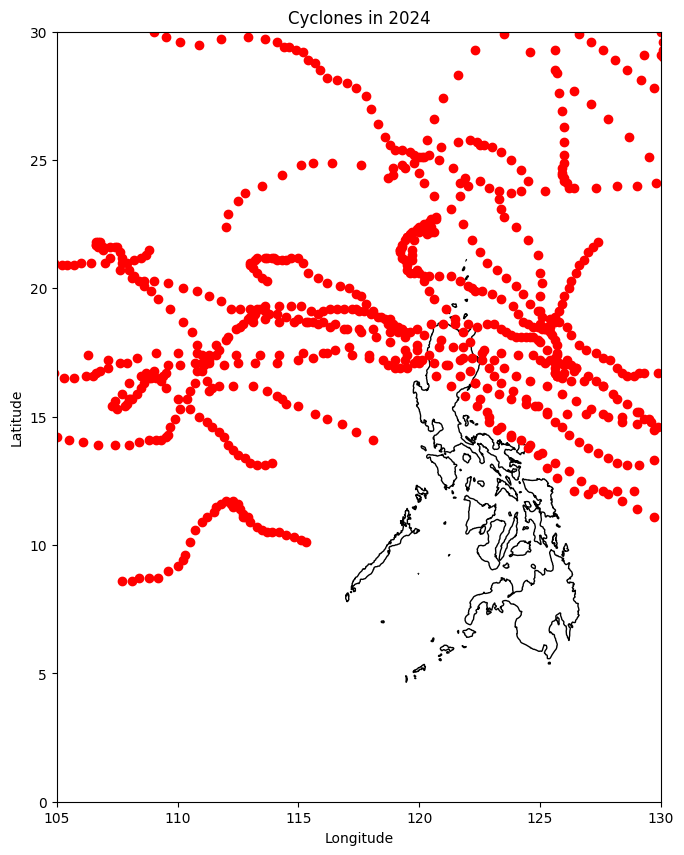

In [59]:
# Plot the data
fig, ax = plt.subplots(figsize=(10, 10))  # Adjust figure size as needed

# Plot the first GeoDataFrame
wrdph.plot(ax=ax, facecolor='none', edgecolor='black')

# Plot the second GeoDataFrame
filtered_tracks.plot(ax=ax, color='red')

# Add title and labels
ax.set_title(f'Cyclones in {year_selected}')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

# Add the lines to set the limits for x and y axes
ax.set_xlim(105, 130)
ax.set_ylim(0, 30)

# Show plot
plt.show()

## Step 2: Data Cleaning

In [60]:
# Function to post-process the VIIRS data
def post_process_viirs_data(df_append, output_path):
    """
    Post-processes the VIIRS data by cleaning, transforming, and saving it.

    Parameters:
    df_append (pd.DataFrame): Raw VIIRS data.
    output_path (str): Path to save the processed data.
    """
    df_append = df_append.dropna(subset=['Date_Mscan'])
    df_append = df_append[df_append["QF_Detect"].isin([1, 2, 3, 8, 10])]
    df_append = df_append.drop_duplicates()
    df_all_sf = gpd.GeoDataFrame(df_append.set_geometry(
        gpd.points_from_xy(df_append['Lon_DNB'], df_append['Lat_DNB']),
        crs='EPSG:4326'))
    df_all_sf.rename({'Date_Mscan': 'ISO_TIME'}, axis=1, inplace=True)

    t = df_all_sf.reset_index(drop=True)
    t['ISO_TIME'] = pd.to_datetime(t["ISO_TIME"])
    t['date_only'] = t['ISO_TIME'].dt.date
    t['date_only'] = pd.to_datetime(t["date_only"])
    return t

t = post_process_viirs_data(df_append, output_path)
t.head()

id                                             id_Key            Date_Proc  \
0   1  VBD_npp_d20241214_t1725079_x1154100E_y221355N_...  2025-01-14 21:33:50   
1   1  VBD_npp_d20241214_t1727534_x1148025E_y121904N_...  2025-01-14 21:42:31   
2   2  VBD_npp_d20241214_t1727534_x1148196E_y122635N_...  2025-01-14 21:42:31   
3   3  VBD_npp_d20241214_t1727569_x1156593E_y119010N_...  2025-01-14 21:42:31   
4   4  VBD_npp_d20241214_t1727569_x1159168E_y118240N_...  2025-01-14 21:42:31   

     Lat_DNB     Lon_DNB  Rad_DNB            ISO_TIME             Date_LTZ  \
0  22.135509  115.409981  17.2760 2024-12-14 17:25:07  2024-12-15 01:25:07   
1  12.190410  114.802513  20.4712 2024-12-14 17:27:53  2024-12-15 01:27:53   
2  12.263506  114.819603  18.9798 2024-12-14 17:27:53  2024-12-15 01:27:53   
3  11.901003  115.659348  13.8794 2024-12-14 17:27:56  2024-12-15 01:27:56   
4  11.823958  115.916809  18.7509 2024-12-14 17:27:56  2024-12-15 01:27:56   

   Line_DNB  Sample_DNB  ...  \
0         1         929  ...   
1       734        1121  ...   
2       723        1122  ...   
3       760        1253  ...   
4       766        1292  ...   

                                           Lon_Gring  \
0  108.546379;123.326469;137.577393;136.039291;12...   
1  107.793724;122.115875;136.033112;134.652603;12...   
2  107.793724;122.115875;136.033112;134.652603;12...   
3  107.793724;122.115875;136.033112;134.652603;12...   
4  107.793724;122.115875;136.033112;134.652603;12...   

                                           Gran_List  SOLZ_GDNBO  SOLA_GDNBO  \
0  npp_d20241214_t1720514_e1722156_b68048;npp_d20...     163.414      97.357   
1  npp_d20241214_t1726330_e1727572_b68048;npp_d20...     159.600     125.336   
2  npp_d20241214_t1726330_e1727572_b68048;npp_d20...     159.629     125.153   
3  npp_d20241214_t1726330_e1727572_b68048;npp_d20...     158.736     124.852   
4  npp_d20241214_t1726330_e1727572_b68048;npp_d20...     158.486     124.700   

   SATZ_GDNBO  SATA_GDNBO  LUNZ_GDNBO  LUNA_GDNBO                    geometry  \
0     50.5779     96.8319     26.2893    -72.8634  POINT (115.40998 22.13551)   
1     44.4630     97.2773     30.7568    -55.9457  POINT (114.80251 12.19041)   
2     44.4275     97.9702     30.7294    -56.0620  POINT (114.81960 12.26351)   
3     39.6670     97.8559     31.6382    -56.1609  POINT (115.65935 11.90100)   
4     38.1518     97.4417     31.8942    -56.2336  POINT (115.91681 11.82396)   

   date_only  
0 2024-12-14  
1 2024-12-14  
2 2024-12-14  
3 2024-12-14  
4 2024-12-14  

[5 rows x 52 columns]

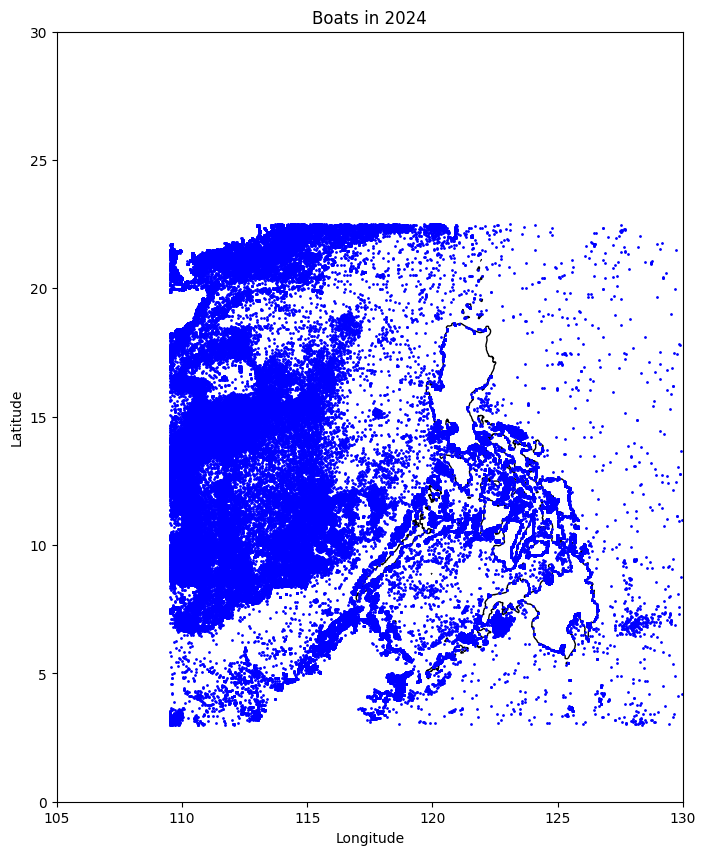

In [61]:
# Plot the data
fig, ax = plt.subplots(figsize=(10, 10))  # Adjust figure size as needed

# Plot the first GeoDataFrame
wrdph.plot(ax=ax, facecolor='none', edgecolor='black')

# # Plot the second GeoDataFrame
# filtered_tracks.plot(ax=ax, color='red')

t_plot = gpd.GeoDataFrame(
    t,
    geometry=gpd.points_from_xy(t['Lon_DNB'], t['Lat_DNB']),
    crs="EPSG:4326"  # Replace with the correct CRS if necessary
)

t_plot.plot(ax=ax, color='blue', markersize=1)

# Add title and labels
ax.set_title(f'Boats in {year_selected}')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

# Add the lines to set the limits for x and y axes
ax.set_xlim(105, 130)
ax.set_ylim(0, 30)

# Show plot
plt.show()

## Step 3: Post-processing the data

In [62]:
def create_lin11d(lin11, year_selected, country, cyclone_seasons):
    """
    Filters cyclone track data for a specified country, year, and defined cyclone season.

    Parameters:
    - lin11 (DataFrame): Data containing cyclone track records with an `ISO_TIME` column.
    - year_selected (int): The primary year to filter the cyclone data.
    - country (str): Country code used to look up the cyclone season.
    - cyclone_seasons (dict): Dictionary with start and end months for each country's cyclone season.

    This function converts `ISO_TIME` to a datetime format, then filters records to include only those
    within the cyclone season (either within the same year or spanning to the next year). It returns
    a filtered DataFrame with an additional `date_only` column for the date portion of `ISO_TIME`.
    """

    season = cyclone_seasons[country]
    start_month = season['start_month']
    end_month = season['end_month']
    end_year = year_selected + 1 if start_month > end_month else year_selected

    # print(f"Filtering for country: {country}, Year: {year_selected}")
    # print(f"Start month: {start_month}, End month: {end_month}, End year: {end_year}")
    # print(lin11)
    # print("ISO_TIME dtype before conversion:", lin11['year'].dtype)

    lin11['ISO_TIME'] = pd.to_datetime(lin11["ISO_TIME"], errors='coerce')
    # print("ISO_TIME dtype after conversion:", lin11['ISO_TIME'].dtype)
    # print("lin11 after datetime conversion:\n", lin11.head())

    lin11 = lin11[lin11['NAME'] != "UNNAMED"]
    # print("lin11 after removing 'not_named' entries:\n", lin11.head())

    lin11d = lin11[
        ((lin11['year'] == year_selected) &
         (lin11['month'] >= start_month)) |
        ((lin11['year'] == end_year) &
         (lin11['month'] <= end_month))
    ]

    lin11d['ISO_TIME'] = pd.to_datetime(lin11d["ISO_TIME"])

    # print(f"Rows after filtering: {lin11d.shape[0]}")

    lin11d['date_only'] = lin11d['ISO_TIME'].dt.date
    lin11d['date_only'] = pd.to_datetime(lin11d["date_only"])
    # print(lin11d)
    # print("lin11 after datetime conversion:\n", lin11.head())
    return lin11d

# Function to post-process the IBTrACS data
def post_process_typhoon_tracks(filtered_tracks, cyclone_seasons, year_selected, country, read_eez, output_path):
    """
    Post-processes typhoon tracks data by filtering and preparing it for analysis within a specified region (EEZ).

    Parameters:
    - filtered_tracks (GeoDataFrame): Typhoon track data to be processed.
    - cyclone_seasons (dict): Dictionary specifying cyclone season start and end months for each country.
    - year_selected (int): Year of interest for filtering.
    - country (str): Country code used to look up cyclone season details.
    - read_eez (GeoDataFrame): EEZ boundary used for spatial clipping.
    - output_path (str): Path for saving the processed output, if needed.

    This function removes columns from `filtered_tracks` with more than 70% missing values, converts `ISO_TIME` to datetime,
    filters records by cyclone season, and spatially clips the data to the specified EEZ region. The function returns
    the filtered DataFrame (`lin11d`) and the spatially clipped GeoDataFrame (`lin11b`).
    """

    lin11 = filtered_tracks.loc[:, filtered_tracks.isna().mean() < 0.7]
    # print(f"Initial filtered_tracks shape: {filtered_tracks.shape}")
    # print(f"Shape after removing columns with >70% missing values: {lin11.shape}")

    lin11['ISO_TIME'] = pd.to_datetime(lin11["ISO_TIME"])
    # print(f"Number of rows in lin11 after datetime conversion: {lin11.shape[0]}")

    lin11d = create_lin11d(lin11, year_selected, country, cyclone_seasons)
    lin11d.to_csv(os.path.join(output_path, f'lin11d_{country}_{year_selected}.csv'))
    lin11d['date_only'] = pd.to_datetime(lin11d["date_only"])

    # print(f"Number of rows in lin11d: {lin11d.shape[0]}")

    lin11b = gpd.clip(lin11d, read_eez)
    # print(f"Number of rows in lin11b: {lin11b.shape[0]}")

    return lin11d, lin11b

def get_start_date(year_selected, start_month):
    """
    Generates a start date based on the specified year and month.

    Parameters:
    - year_selected (int): The year for the start date.
    - start_month (int): The month for the start date.

    This function returns a `date` object representing the first day of the specified month and year.
    """

    start_date = pd.to_datetime(f'{year_selected}-{start_month:02d}-01').date()
    # print(f"Dynamic start_date: {start_date}")
    return start_date

lin11d, lin11b = post_process_typhoon_tracks(
            filtered_tracks,
            cyclone_seasons,
            year_selected,
            country,
            read_eez,
            output_path
        )

lin11b.head()

/usr/local/lib/python3.11/dist-packages/geopandas/geodataframe.py:1528: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/usr/local/lib/python3.11/dist-packages/geopandas/geodataframe.py:1528: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


row_id            SID  SEASON  NUMBER BASIN SUBBASIN       NAME  \
3637   17626  2024357N10115    2024      92    WP       MM      PABUK   
3638   17627  2024357N10115    2024      92    WP       MM      PABUK   
3639   17628  2024357N10115    2024      92    WP       MM      PABUK   
3640   17629  2024357N10115    2024      92    WP       MM      PABUK   
310    14299  2024201N14118    2024      32    WP       MM  PRAPIROON   

                ISO_TIME NATURE   LAT  ...  BOM_CI  STORM_SPD  STORM_DR  year  \
3637 2024-12-21 18:00:00     TS  10.1  ...  -999.9          5       295  2024   
3638 2024-12-21 21:00:00     TS  10.2  ...  -999.9          5       290  2024   
3639 2024-12-22 00:00:00     TS  10.3  ...  -999.9          6       290  2024   
3640 2024-12-22 03:00:00     TS  10.4  ...  -999.9          6       285  2024   
310  2024-07-19 06:00:00     TS  14.1  ...  -999.9         15       295  2024   

     month  day  hour min                    geometry  date_only  
3637    12   21    18   0  POINT (115.30000 10.10000) 2024-12-21  
3638    12   21    21   0  POINT (115.10000 10.20000) 2024-12-21  
3639    12   22     0   0  POINT (114.80000 10.30000) 2024-12-22  
3640    12   22     3   0  POINT (114.50000 10.40000) 2024-12-22  
310      7   19     6   0  POINT (118.10000 14.10000) 2024-07-19  

[5 rows x 59 columns]

In [63]:
# Function for setting parameter criterion for the cyclone (one day in the EEZ)
def filter_cyclone_points(lin11d, read_eez, month):
    """
    Filter cyclone points that are within the EEZ and meet the criteria of being present for at least one day.

    Parameters:
    - lin11d: DataFrame containing cyclone points.
    - read_eez: GeoDataFrame containing the EEZ boundaries.
    - month: Integer representing the month for which to filter cyclone points.

    Returns:
    - filtered_points: DataFrame containing filtered cyclone points.
    """

    lin11d['ISO_TIME'] = pd.to_datetime(lin11d['ISO_TIME'], errors='coerce')
    lin11d['date_only'] = lin11d['ISO_TIME'].dt.date
    lin11d['date_only'] = pd.to_datetime(lin11d['date_only'])
    lin11d['month'] = pd.to_numeric(lin11d['month'], errors='coerce', downcast='integer')

    # cyclone_points_month_df = lin11d[lin11d['date_only'].dt.month == month]
    cyclone_points_month_df = lin11d[lin11d['month'] == month]

    # Identify cyclone names that have points within the EEZ
    cyclone_names_inside_eez = set()
    for index, cyclone_point in cyclone_points_month_df.iterrows():
        cyclone_name = cyclone_point['NAME']
        if any(read_eez.geometry.contains(cyclone_point.geometry)):
            cyclone_names_inside_eez.add(cyclone_name)

    cyclones_inside_eez = cyclone_points_month_df[cyclone_points_month_df['NAME'].isin(cyclone_names_inside_eez)]
    points_inside_eez = gpd.sjoin(cyclones_inside_eez, read_eez, op='within', how='inner')

    # Calculate entry and exit dates within the EEZ
    points_inside_eez['entered_eez_date'] = points_inside_eez.groupby('NAME')['date_only'].transform('min')
    points_inside_eez['within_eez_date'] = points_inside_eez.groupby('NAME')['date_only'].transform('max')

    # New criteria (a) = minimum of 1 day inside EEZ
    # Merge the processed dates back to cyclones_inside_eez
    cyclones_inside_eez2 = cyclones_inside_eez.merge(points_inside_eez[['NAME', 'entered_eez_date', 'within_eez_date']], on='NAME', how='left')
    cyclones_inside_eez2['days_inside_eez'] = (cyclones_inside_eez2['within_eez_date'] - cyclones_inside_eez2['entered_eez_date']).dt.days

    # Exclude cyclone points within EEZ for less than 1 day
    filtered_points = cyclones_inside_eez2[cyclones_inside_eez2['days_inside_eez'] >= 1]
    # filtered_points.to_csv('filtered_2024.csv')

    return filtered_points

# Post-process the boat and cyclone data into the selected country (with filter_cyclone_points as input)
def process_data_for_country(country, year_selected, t, lin11d, read_eez, cyclone_seasons, output_path):
    """
    Processes cyclone track data for a specified country and year, filtering data by cyclone season and region (EEZ).

    Parameters:
    - country (str): Country code for which data is processed.
    - year_selected (int): The target year for data processing.
    - t (GeoDataFrame): Original cyclone track data for the given country and year.
    - lin11d (DataFrame): Cyclone data filtered by month and year.
    - read_eez (GeoDataFrame): EEZ boundary used for spatial clipping.
    - cyclone_seasons (dict): Dictionary defining cyclone season start and end months for each country.
    - output_path (str): Path to save processed files.

    This function filters data based on the cyclone season and spatially clips it to the EEZ. It creates a DataFrame
    of filtered points (`td`) and returns unique dates from `td`, along with the spatially filtered and seasonally filtered data.
    """

    start_month = cyclone_seasons[country]['start_month']
    end_month = cyclone_seasons[country]['end_month']
    start_date = get_start_date(year_selected, start_month)
    end_year = year_selected + 1 if start_month > end_month else year_selected

    df_all_b = gpd.clip(t, read_eez)
    # print(f"Number of rows in df_all_b_1: {df_all_b.shape[0]}")
    df_all_b['ISO_TIME'] = pd.to_datetime(df_all_b["ISO_TIME"], utc=False)
    df_all_b['date_only'] = df_all_b['ISO_TIME'].dt.date
    df_all_b.to_csv(os.path.join(output_path, f'df_all_b_{country}_{year_selected}.csv'), index=False)

    # Filtering data within the cyclone season
    all_filtered = pd.DataFrame()
    for year in range(year_selected, end_year + 1):
        for month in range(start_month if year == year_selected else 1, end_month + 1 if year == end_year else 13):
            filtered_cyclone_points = filter_cyclone_points(lin11d, read_eez, month)
            all_filtered = pd.concat([all_filtered, filtered_cyclone_points], ignore_index=True)

    all_filtered.to_csv('all_filtered.csv')

    td = df_all_b[df_all_b['date_only'] >= start_date]

    if 'date_only' not in td.columns:
        td['date_only'] = td['ISO_TIME'].dt.date

    td.to_csv(os.path.join(output_path, f'td_{country}_{year_selected}.csv'), index=False)
    # print(f"Number of rows in td: {td.shape[0]}")

    # Get unique dates in the 'date_only' column of td
    unique_dates_td = td['date_only'].unique()

    return unique_dates_td, td, all_filtered, df_all_b



unique_dates_td, td, all_filtered, df_all_b = process_data_for_country(
            country,
            year_selected,
            t,
            lin11d,
            read_eez,
            cyclone_seasons,
            output_path
        )

/usr/local/lib/python3.11/dist-packages/geopandas/geodataframe.py:1528: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/tmp/ipython-input-2099421902.py:101: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  unique_dates_td, td, all_filtered, df_all_b = process_data_for_country(
/tmp/ipython-input-2099421902.py:101: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  unique_dates_td, td, all_filtered, df_all_b = process_data_for_country(
/tmp/ipython-input-2099421902.py:101: FutureWarning: The `op` parameter is deprecated and will be removed in a f

### **Step 4: Data Derivation**:
A. Statistics
- No. of boats when typhoons are not present
- No. of boats when typhoons are present

In [64]:
# Function to post-process boats and typhoons -> basically get the statistics of boats given the typhoon presence
def post_process_boats_and_typhoons(lin11d, td, read_eez, year_selected, country, output_path):
    """ Post-processing the boats and typhoons in preparation for the generation of fishing grounds. """

    # Get the bounding box of the EEZ
    bbox2 = read_eez.total_bounds
    # print(f"Bounding Box Coordinates: {bbox2}")
    bbox_geom2 = box(*bbox2)  # Create a bounding box geometry
    # print(f"Bounding Box Geometry: {bbox_geom2}")

    # Clip the data using the bounding box
    # print(f"Number of rows in lin11d: {lin11d.shape[0]}")
    lin11d_clipped = lin11d[lin11d.intersects(bbox_geom2)]
    lin11d_clipped.to_csv(os.path.join(output_path, f'lin11d_clipped_{country}_{year_selected}.csv'))
    # print(f"Number of rows in lin11d_clipped: {lin11d_clipped.shape[0]}")

    lin11d_clipped['ISO_TIME'] = pd.to_datetime(lin11d_clipped['date_only']).dt.date
    unique_dates = lin11d_clipped['date_only'].astype(str).unique()
    # print(f"Number of rows in unique_dates: {unique_dates.shape[0]}")
    # Getting the clipped boats without typhoon experience
    td['date_only'] = pd.to_datetime(td['date_only']).dt.date

    unique_dates = pd.to_datetime(unique_dates).date
    # print(f"Number of rows in unique_dates: {len(unique_dates)}")

    boats_no_typhoons = td[~td['date_only'].isin(unique_dates)]
    boats_no_typhoons.to_csv(os.path.join(output_path, f'{country}_{year_selected}_boats_no_ty.csv'))

    # Getting the clipped boats with typhoon experience
    boats_typhoons = td[td['date_only'].isin(unique_dates)]
    boats_typhoons.to_csv(os.path.join(output_path, f'{country}_{year_selected}_boats_ty.csv'))

    print(f'Number of boats without typhoon occurrence: {boats_no_typhoons.shape[0]}')
    print(f'Number of boats with typhoon occurrence: {boats_typhoons.shape[0]}')

    # Generating statistics of monthly number of boats with and without typhoon experience
    boats_no_typhoons['date_only'] = pd.to_datetime(boats_no_typhoons['date_only'])
    boats_per_month = boats_no_typhoons.groupby(boats_no_typhoons['date_only'].dt.to_period('M')).size().reset_index()
    boats_per_month.columns = ['Month', 'Boats_Count_No_ty']
    boats_per_month.to_csv(os.path.join(output_path, f'{country}_{year_selected}_sum_boats_no_ty.csv'))

    boats_typhoons['date_only'] = pd.to_datetime(boats_typhoons['date_only'])
    boats_ty_per_month = boats_typhoons.groupby(boats_typhoons['date_only'].dt.to_period('M')).size().reset_index()
    boats_ty_per_month.columns = ['Month', 'Boats_Count_With_ty']
    boats_ty_per_month.to_csv(os.path.join(output_path, f'{country}_{year_selected}_sum_boats_with_ty.csv'))

    # Count of boats per dateonly (no_typhoons happened)
    boats_per_date = boats_no_typhoons['date_only'].value_counts().reset_index()
    boats_per_date.columns = ['date_only', 'count']

    # Count of boats per dateonly (typhoons happened)
    boats_per_date_ty = boats_typhoons['date_only'].value_counts().reset_index()
    boats_per_date_ty.columns = ['date_only', 'count']

    return lin11d_clipped, boats_no_typhoons, boats_typhoons, boats_per_month, boats_ty_per_month, boats_per_date, boats_per_date_ty

lin11d_clipped, boats_no_typhoons, boats_typhoons, boats_per_month, boats_ty_per_month, boats_per_date, boats_per_date_ty = post_process_boats_and_typhoons(
            lin11d,
            td,
            read_eez,
            year_selected,
            country,
            output_path
        )

/usr/local/lib/python3.11/dist-packages/geopandas/geodataframe.py:1528: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


Number of boats without typhoon occurrence: 50219
Number of boats with typhoon occurrence: 8875


/usr/local/lib/python3.11/dist-packages/geopandas/geodataframe.py:1528: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/usr/local/lib/python3.11/dist-packages/geopandas/geodataframe.py:1528: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


### Results
B. Fishing grounds based on the location of the detected fishing boats from VIIRS

Using generated merged polygons for past year clipping with 'contour_id' labeling.
Merged polygons GeoJSON saved as 'phl_merged_dense_area_polygons_2024.geojson'
Clipped data saved as 'clipped_original_data_phl_2024.csv'


/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py:3553: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)


Map saved to phl_2024_map.png


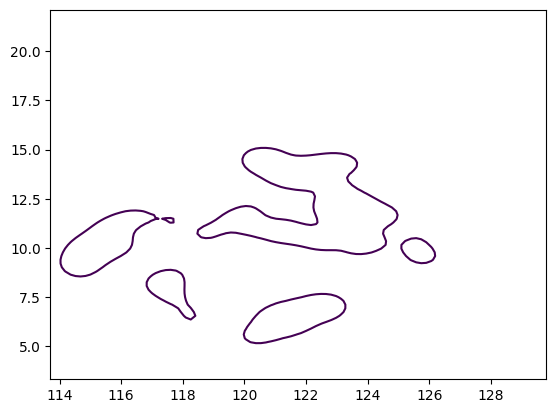

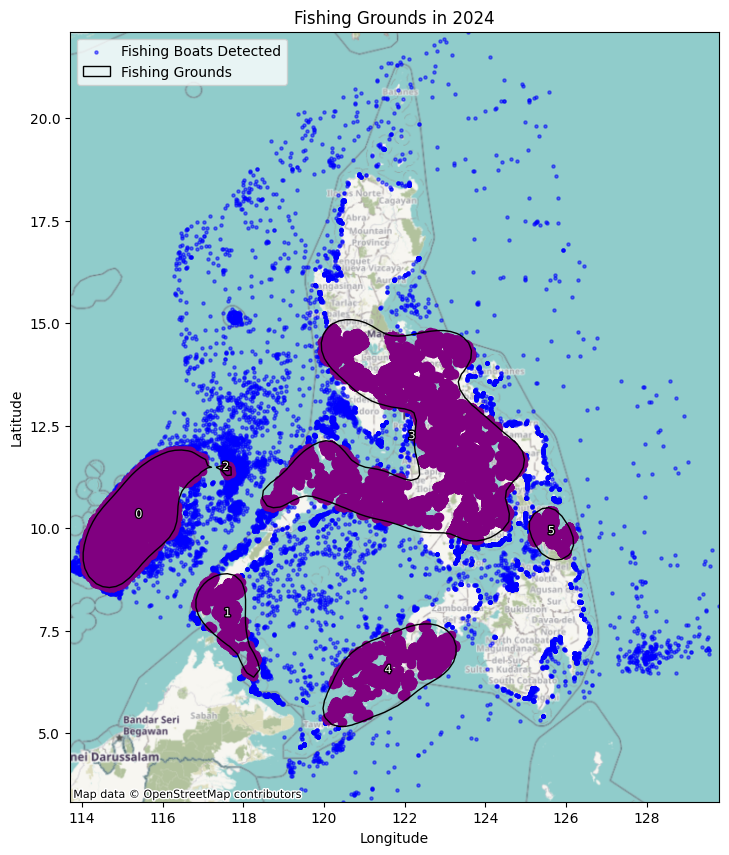

In [92]:
# Function to determine fishing grounds
def determine_fishing_grounds(boats_no_typhoons, year_selected, country, fg_df_latest):
    """
    Identifies fishing grounds based on the density of fishing boats detected in the absence of typhoons, using Kernel Density Estimation (KDE).

    Parameters:
    - boats_no_typhoons (DataFrame): Data containing fishing boat locations (latitude and longitude) when no typhoons occurred.
    - year_selected (int): Year of data analysis.
    - country (str): Country code used for naming outputs.

    This function filters out negative longitude values and applies KDE to fishing boat locations to identify high-density areas.
    Polygons representing fishing grounds are saved as GeoJSON files and merged to create a map of identified fishing grounds.
    The function returns the merged GeoDataFrame, clipped GeoDataFrame, and the path to the saved map image.
    """

    boats_no_typhoons_filtered = boats_no_typhoons[boats_no_typhoons['Lon_DNB'] > 0]

    # Setting the long and lat from the boats_no_typhoons dataframe
    x_coords = boats_no_typhoons_filtered['Lon_DNB'].values
    y_coords = boats_no_typhoons_filtered['Lat_DNB'].values

    current_year = pd.Timestamp.now().year

    # If the current year is chosen, use the provided GeoDataFrame directly
    if year_selected == current_year:
        merged_gdf = fg_df_latest
        print("Using 'grounds_latest.geojson' for current year clipping.")
    else:
        # Perform kernel density estimation
        kde = stats.gaussian_kde([x_coords, y_coords])

        # Define the grid over which to evaluate the KDE
        x_grid, y_grid = np.mgrid[x_coords.min():x_coords.max():100j, y_coords.min():y_coords.max():100j]

        # Evaluate the KDE on the grid
        kde_values = kde(np.vstack([x_grid.ravel(), y_grid.ravel()]))

        # Reshape the KDE values back to the grid shape
        kde_values = kde_values.reshape(x_grid.shape)

        # Set the density threshold to identify highest density points -> main fishing grounds, contour form, using 90% threshold
        density_threshold = np.percentile(kde_values, 90)

        # Find the contour lines
        contour_lines = plt.contour(x_grid, y_grid, kde_values, levels=[density_threshold])

        # Initialize a list to hold polygons
        polygons = []

        # Loop through each contour path and extract the vertices
        for contour_path in contour_lines.collections[0].get_paths():
            polygon_vertices = contour_path.vertices
            polygons.append(Polygon(polygon_vertices))

        # Validate and repair geometries
        valid_polygons = [make_valid(p) for p in polygons]

        # Create a GeoDataFrame from valid polygons
        shapely_polygons = [shape(p) for p in valid_polygons]
        merged_features = []
        merged_dict = {i: False for i in range(len(shapely_polygons))}  # Track merged polygons
        contour_id = 0  # Initialize contour ID

        i = 0
        while i < len(shapely_polygons):
            if merged_dict[i]:
                i += 1
                continue

            current_polygon = shapely_polygons[i]
            j = i + 1
            while j < len(shapely_polygons):
                if merged_dict[j]:
                    j += 1
                    continue

                if current_polygon.intersects(shapely_polygons[j]):
                    try:
                        current_polygon = current_polygon.union(shapely_polygons[j])
                        merged_dict[j] = True
                    except TopologicalError as e:
                        print(f"Error merging polygons {i} and {j}: {e}")
                j += 1

            # Add merged or individual polygon to features with contour ID
            merged_features.append(geojson.Feature(geometry=current_polygon, properties={"contour_id": contour_id}))
            merged_dict[i] = True
            contour_id += 1
            i += 1

        # Create a GeoDataFrame from the merged features
        merged_gdf = gpd.GeoDataFrame.from_features(merged_features, crs='EPSG:4326')
        print("Using generated merged polygons for past year clipping with 'contour_id' labeling.")

        # Output the merged polygons as a GeoJSON file
        merged_geojson_file = f'{country}_merged_dense_area_polygons_{year_selected}.geojson'
        merged_gdf.to_file(merged_geojson_file, driver='GeoJSON')
        print(f"Merged polygons GeoJSON saved as '{merged_geojson_file}'")

    # Create a GeoDataFrame for the original DataFrame
    original_gdf = gpd.GeoDataFrame(
        boats_no_typhoons,
        geometry=gpd.points_from_xy(boats_no_typhoons['Lon_DNB'], boats_no_typhoons['Lat_DNB']),
        crs='EPSG:4326'
    )

    # Perform a spatial join to clip the original DataFrame based on the selected polygons
    clipped_gdf = gpd.sjoin(original_gdf, merged_gdf, op='within')

    # Save the clipped data as a new CSV file
    clipped_csv_file = f'clipped_original_data_{country}_{year_selected}.csv'
    # clipped_gdf.to_csv(clipped_csv_file, index=False)
    print(f"Clipped data saved as '{clipped_csv_file}'")

    # Create GeoDataFrame for the scatter points
    gdf_scatter = gpd.GeoDataFrame(geometry=[Point(x, y) for x, y in zip(x_coords, y_coords)])
    gdf_scatter.set_crs(epsg=4326, inplace=True)

    # Simulate GeoDataFrame for clipped_gdf
    clipped_gdf.set_crs(epsg=4326, inplace=True)

    # Plot the data
    fig, ax = plt.subplots(figsize=(10, 10))

    gdf_scatter.plot(ax=ax, markersize=5, color='blue', alpha=0.5, label='Fishing Boats Detected')
    clipped_gdf.plot(ax=ax, color='purple')
    merged_gdf.plot(ax=ax, edgecolor='black', facecolor='none')

    minx, miny, maxx, maxy = gdf_scatter.total_bounds
    ax.set_xlim(minx, maxx)
    ax.set_ylim(miny, maxy)

    # Add labels with halo effect for each fishing ground
    for idx, row in merged_gdf.iterrows():
        x, y = row.geometry.centroid.x, row.geometry.centroid.y  # Use centroid of each feature for label placement
        contour_id = row['contour_id']  # Access contour_id for labeling

        # Add label with halo effect
        ax.annotate(
            text=contour_id,
            xy=(x, y),
            ha="center",
            color="white",  # Text color
            fontsize=8,
            path_effects=[
                patheffects.withStroke(linewidth=2, foreground="black")  # Halo effect
            ]
        )

    # Add OpenStreetMap basemap
    basemap_added = False
    try:
        ctx.add_basemap(
            ax,
            crs=gdf_scatter.crs.to_string(),
            attribution="Map data © OpenStreetMap contributors",
        )
        basemap_added = True
    except Exception as e:
        print(f"Failed to load OpenStreetMap basemap: {e}")
        print("Switching to CartoDB Positron basemap...")
        try:
            ctx.add_basemap(
                ax,
                crs=gdf_scatter.crs.to_string(),
                source=ctx.providers.CartoDB.Positron,
            )
        except Exception as e2:
            print(f"Failed to load CartoDB Positro basemap: {e2}")
            print("No basemap will be added.")

    # Custom legend entry for the dashed fishing grounds
    fishing_grounds_legend = mpatches.Patch(
        edgecolor='black', facecolor='none', label='Fishing Grounds'
    )

    # Add legend with custom entry for fishing grounds
    handles, labels = ax.get_legend_handles_labels()
    handles.append(fishing_grounds_legend)
    labels.append('Fishing Grounds (Dashed Outline)')
    ax.legend(
        handles=handles,
        loc='upper left',  # Position the legend in the upper right corner of the map
        borderaxespad=0.5,  # Space between legend and map edge
        frameon=True,       # Add a frame to make it more visible
        fontsize=10
    )

    # plt.legend()
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title(f'Fishing Grounds in {year_selected}')
    map_path = f"{country}_{year_selected}_map.png"
    plt.savefig(map_path)
    # plt.close(fig)
    print(f"Map saved to {map_path}")

    # Return the results
    return merged_gdf, clipped_gdf, map_path

merged_gdf, clipped_gdf, map_path = determine_fishing_grounds(boats_no_typhoons, year_selected, country, fg_df_latest)

### Results
C.1. Identification of boats with typhoon occurrence inside the main fishing grounds

In [93]:
# Function to clip boats with typhoon occurrence using the main fishing grounds
def clip_boats_with_typhoon_occurrence(boats_typhoons, boats_no_typhoons, merged_gdf, year_selected, country):
    """
    Clips fishing boat locations that experienced typhoon events to the main fishing grounds and computes boat counts for each typhoon occurrence date.

    Parameters:
    - boats_typhoons (DataFrame): Data containing fishing boat locations with typhoon occurrences.
    - boats_no_typhoons (DataFrame): Data of fishing boats without typhoon occurrences.
    - merged_gdf (GeoDataFrame): Main fishing grounds defined by KDE-derived contours.
    - year_selected (int): Year of data analysis.
    - country (str): Country code used for naming outputs.

    This function performs spatial clipping of boats with typhoon occurrences using main fishing ground polygons.
    It calculates daily and monthly averages of boat counts with and without typhoon occurrences, saving results to CSV files and returning the clipped GeoDataFrame, daily boat counts, and merged boat data.
    """

    # Create a GeoDataFrame for the original DataFrame: Boats with typhoon experience
    typhoons_gdf = gpd.GeoDataFrame(
        boats_typhoons,
        geometry=gpd.points_from_xy(boats_typhoons['Lon_DNB'], boats_typhoons['Lat_DNB']),
        crs='EPSG:4326'
    )

    # Perform a spatial join to clip the original DataFrame based on the merged polygons
    clipped_ty_gdf = gpd.sjoin(typhoons_gdf, merged_gdf, op='within')

    # Save the clipped data as a new CSV file -> clipped boats typhoon with contour id
    clipped_ty_gdf.to_csv(os.path.join(output_path, f'clipped_ty_gdf_{country}_{year_selected}.csv'), index=False)

    # Calculate the total number of boats during typhoon occurrence (per date)
    boats_fishing_grounds = boats_typhoons['date_only'].value_counts().reset_index()
    boats_fishing_grounds.columns = ['date_only', 'boats_fishing']
    boats_fishing_grounds = boats_fishing_grounds.sort_values(by='date_only')
    boats_fishing_grounds.to_csv(os.path.join(output_path, f'boats_fishing_grounds_{country}_{year_selected}.csv'), index=False)

    # Calculate the average number of boats during typhoon occurrence
    boatsfg_per_month = boats_fishing_grounds.groupby(boats_fishing_grounds['date_only'].dt.to_period('M'))['boats_fishing'].mean().reset_index(name='monthly_ave')
    boatsfg_per_month.to_csv(os.path.join(output_path, f'mean_boatsfg_ty_{country}_{year_selected}.csv'), index=False)

    # Calculate the total number of boats without typhoon occurrence (per date)
    boats_fishing_grounds_noty = boats_no_typhoons['date_only'].value_counts().reset_index()
    boats_fishing_grounds_noty.columns = ['date_only', 'boats_fishing']
    boats_fishing_grounds_noty = boats_fishing_grounds_noty.sort_values(by='date_only')
    boats_fishing_grounds_noty.to_csv(os.path.join(output_path, f'boats_fishing_grounds_noty_{country}_{year_selected}.csv'), index=False)

    # Calculate the average number of boats without typhoon occurrence
    boatsfg_per_month_noty = boats_fishing_grounds_noty.groupby(boats_fishing_grounds_noty['date_only'].dt.to_period('M'))['boats_fishing'].mean().reset_index(name='monthly_ave')
    boatsfg_per_month_noty.to_csv(os.path.join(output_path, f'mean_boatsfg_noty{country}_{year_selected}.csv'), index=False)

    merge_boats_num = pd.concat([boats_fishing_grounds_noty, boats_fishing_grounds], ignore_index=True)
    merge_boats_num = merge_boats_num.sort_values(by='date_only')
    merge_boats_num.to_csv(os.path.join(output_path, f'merge_boats_num_{country}_{year_selected}.csv'), index=False)

    # print(merge_boats_num)
    # merge_boats_num.head()
    return clipped_ty_gdf, boats_fishing_grounds, merge_boats_num

clipped_ty_gdf, boats_fishing_grounds, merge_boats_num = clip_boats_with_typhoon_occurrence(boats_typhoons, boats_no_typhoons, merged_gdf, year_selected, country)
print(clipped_ty_gdf)

/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py:3553: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)


          id                                             id_Key  \
56473    604  VBD_npp_d20240901_t1819145_x1143617E_y086879N_...   
39022   1553  VBD_npp_d20240831_t1838030_x1143031E_y087457N_...   
183920   718  VBD_npp_d20240902_t1800242_x1142750E_y087846N_...   
56471    602  VBD_npp_d20240901_t1819145_x1142735E_y087876N_...   
39020   1551  VBD_npp_d20240831_t1838012_x1142700E_y087894N_...   
...      ...                                                ...   
155182   203  VBD_npp_d20241001_t1713396_x1226116E_y147639N_...   
60184   1201  VBD_npp_d20240903_t1739329_x1227068E_y147442N_...   
165413    54  VBD_npp_d20240905_t1701524_x1227106E_y147496N_...   
165417    58  VBD_npp_d20240905_t1701524_x1228499E_y146824N_...   
30006     91  VBD_npp_d20241002_t1654458_x1226093E_y147751N_...   

                  Date_Proc    Lat_DNB     Lon_DNB   Rad_DNB  \
56473   2024-10-14 09:14:42   8.687863  114.361679   3.72001   
39022   2024-09-19 09:09:31   8.745651  114.303062  10.10750   
183

### Results
C.2. Counting the number of fishing boats when cyclones are present and per contour_id (fishing ground)

In [97]:
def compute_clipped_boats(clipped_ty_gdf, boats_fishing_grounds, merged_gdf, year_selected, country):
    """
    Compute the number of clipped boats per fishing ground and the total number of boats per typhoon date.

    Parameters:
    - clipped_ty_gdf: GeoDataFrame containing boats clipped with typhoon occurrence.
    - boats_fishing_grounds: DataFrame containing the total number of boats per date of typhoon occurrence.
    - year_selected: The selected year for the analysis.
    - country: The country code for the analysis.

    Returns:
    - pivot_table: DataFrame containing the pivot table with clipped boat counts per fishing ground and total boats per date.
    """

     # Convert date columns to datetime
    clipped_ty_gdf['date_only'] = pd.to_datetime(clipped_ty_gdf['date_only']).dt.date
    boats_fishing_grounds['date_only'] = pd.to_datetime(boats_fishing_grounds['date_only'])

    # Group by contour_id and date
    grouped_counts = clipped_ty_gdf.groupby(['contour_id', 'date_only']).size().reset_index(name='row_count')
    grouped_counts['date_only'] = pd.to_datetime(grouped_counts['date_only'])

    # Merge in total boats_fishing
    grouped_counts = pd.merge(grouped_counts, boats_fishing_grounds[['date_only', 'boats_fishing']], on='date_only', how='left')

    # Create pivot table
    pivot_table = grouped_counts.pivot(index='date_only', columns='contour_id', values='row_count')

    # Get expected contour_ids from merged_gdf (main fishing grounds)
    expected_contour_ids = sorted(merged_gdf['contour_id'].unique())
    pivot_table = pivot_table.reindex(columns=expected_contour_ids, fill_value=0)

    # Optionally rename columns
    pivot_table.columns = [f"ground_{col}" for col in pivot_table.columns]

    # Add boats_fishing column
    pivot_table['boats_fishing'] = grouped_counts.groupby('date_only')['boats_fishing'].first()

    # Reset index
    pivot_table = pivot_table.reset_index()

    # Save to CSV
    pivot_table.to_csv(os.path.join(output_path, f'count_grounds_{country}_{year_selected}.csv'), index=False)

    print(pivot_table)
    return pivot_table

pivot_table = compute_clipped_boats(clipped_ty_gdf, boats_fishing_grounds, merged_gdf, year_selected, country)

    date_only  ground_0  ground_1  ground_2  ground_3  ground_4  ground_5  \
0  2024-07-19      12.0      36.0         0      29.0      95.0       NaN   
1  2024-07-20       NaN      10.0         0      41.0      66.0       1.0   
2  2024-07-21       NaN      13.0         0       2.0       6.0       NaN   
3  2024-07-22       NaN       5.0         0      15.0       1.0       NaN   
4  2024-07-23       3.0       7.0         0       NaN      28.0       NaN   
5  2024-08-31      77.0       7.0         0     103.0      69.0       NaN   
6  2024-09-01      36.0       5.0         0       1.0      71.0       2.0   
7  2024-09-02      55.0      17.0         0      65.0      79.0       NaN   
8  2024-09-03      47.0      24.0         0     120.0      29.0      19.0   
9  2024-09-04      44.0      24.0         0     112.0     124.0      23.0   
10 2024-09-05       6.0      23.0         0     145.0     111.0      17.0   
11 2024-09-15       3.0       NaN         0       2.0      39.0       NaN   

### Results
C.3.1. Counting the number of fishing boats without the presence of cyclones and per contour_id (fishing ground)

C.3.2. Average daily boats per fishing ground

In [98]:
def compute_clipped_boats_no_typhoon(clipped_gdf, boats_no_typhoons, year_selected, country):
    """
    Compute the number of clipped boats per fishing ground without typhoon occurrence, and the total number of boats per date of typhoon occurrence.

    Parameters:
    - clipped_gdf: GeoDataFrame containing boats without typhoon occurrence.
    - boats_no_typhoons: DataFrame containing the number of boats per date without typhoon occurrence.
    - year_selected: The selected year for the analysis.
    - country: The country code for the analysis.

    Returns:
    - pivot_table2: DataFrame containing the pivot table with clipped boat counts per fishing ground and total boats per date.
    """

    # Convert the 'date' column to a datetime object
    clipped_gdf['date_only'] = pd.to_datetime(clipped_gdf['date_only'])

    # Extract the date only from the datetime column
    clipped_gdf['date_only'] = clipped_gdf['date_only'].dt.date

    # Group by 'contour_id' and 'date_only', and then count rows in each group
    grouped_counts2 = clipped_gdf.groupby(['contour_id', 'date_only']).size().reset_index(name='row_count')

    # Convert 'date_only' column in grouped_counts2 to datetime
    grouped_counts2['date_only'] = pd.to_datetime(grouped_counts2['date_only'])

    # Calculate the total number of boats without typhoon occurrence (per date)
    boats_fishing_grounds_no_ty = boats_no_typhoons['date_only'].value_counts().reset_index()
    boats_fishing_grounds_no_ty.columns = ['date_only', 'boats_fishing']
    boats_fishing_grounds_no_ty = boats_fishing_grounds_no_ty.sort_values(by='date_only')

    # Convert 'date_only' column in boats_fishing_grounds_no_ty to datetime
    boats_fishing_grounds_no_ty['date_only'] = pd.to_datetime(boats_fishing_grounds_no_ty['date_only'])

    # Merge the grouped counts with boats_fishing_grounds_no_ty
    grouped_counts2 = pd.merge(grouped_counts2, boats_fishing_grounds_no_ty[['date_only', 'boats_fishing']], on='date_only', how='left')

    # Create a pivot table with 'date_only' as index and 'contour_id' as columns
    pivot_table2 = grouped_counts2.pivot(index='date_only', columns=['contour_id'], values='row_count')

    # Add the total number of boats per date
    pivot_table2['boats_fishing'] = grouped_counts2.groupby('date_only')['boats_fishing'].first()

    # Reset the index of the pivot table
    pivot_table2 = pivot_table2.reset_index()

    # Save the pivot table as a CSV file
    pivot_table2.to_csv(os.path.join(output_path, f'count_grounds_no_ty_{country}_{year_selected}.csv'), index=False)
    # print(pivot_table2)

    # Melt the DataFrame to convert contour_id columns into rows
    melted_df = pivot_table2.melt(id_vars=['date_only'], var_name='contour_id', value_name='fishing_boats')

    # Convert contour_id to numeric to handle dynamically detected ids
    melted_df['contour_id'] = pd.to_numeric(melted_df['contour_id'], errors='coerce')

    # Drop NaN values to handle blanks in the original table
    melted_df = melted_df.dropna(subset=['fishing_boats'])

    # Calculate the average daily count of boats for each contour_id
    average_daily_counts = melted_df.groupby('contour_id')['fishing_boats'].mean().round().astype(int).reset_index()

    # Rename columns for clarity
    average_daily_counts.columns = ['contour_id', 'avg_daily_boats']

    # Save the average daily count table as a CSV file
    average_daily_counts.to_csv(os.path.join(output_path, f'avg_daily_boats_noty_{country}_{year_selected}.csv'), index=False)
    return pivot_table2, average_daily_counts

pivot_table2, average_daily_counts = compute_clipped_boats_no_typhoon(clipped_gdf, boats_no_typhoons, year_selected, country)
pivot_table2.head()

average_daily_counts

contour_id  avg_daily_boats
0         0.0               44
1         1.0               19
2         2.0                2
3         3.0              133
4         4.0               58
5         5.0               14

### Results
D. Calculating the centroids of the generated fishing grounds

In [99]:
def calculate_centroids(merged_gdf):
    """
    Calculates the centroids of Polygon and MultiPolygon geometries in a GeoDataFrame.

    Parameters:
    - merged_gdf (GeoDataFrame): GeoDataFrame containing Polygon and MultiPolygon geometries.

    This function computes the centroid for each geometry, adding `lat` and `lon` columns for the centroid coordinates.
    The resulting GeoDataFrame, including centroid coordinates, is saved to 'centers.csv' and returned.
    """

    read_poly = merged_gdf.copy()

    # Function to compute centroids for Polygon or MultiPolygon geometries
    def compute_centroid(geom):
        if geom.geom_type == 'Polygon':
            return geom.centroid
        elif geom.geom_type == 'MultiPolygon':
            return geom.representative_point()  # Use a representative point for MultiPolygon
        else:
            raise ValueError("Unsupported geometry type: {}".format(geom.geom_type))

    # Calculate the centroid for each geometry
    read_poly['centroid'] = read_poly.geometry.apply(compute_centroid)
    read_poly['lat'] = read_poly['centroid'].y
    read_poly['lon'] = read_poly['centroid'].x

    # Save to CSV
    read_poly.to_csv(os.path.join(output_path, f'centers_{country}_{year_selected}.csv'), index=False)

    return read_poly

read_poly = calculate_centroids(merged_gdf)
print(read_poly)

                                            geometry  contour_id  \
0  POLYGON ((114.16682 8.82750, 114.07207 9.01731...           0   
1  POLYGON ((116.88552 7.87841, 116.82573 8.06823...           1   
2  POLYGON ((117.32537 11.48494, 117.44318 11.516...           2   
3  POLYGON ((118.47088 10.72567, 118.49561 10.915...           3   
4  POLYGON ((120.00907 5.41078, 119.97621 5.60060...           4   
5  POLYGON ((125.24398 9.58677, 125.14911 9.77659...           5   

                     centroid        lat         lon  
0  POINT (115.40807 10.25862)  10.258621  115.408074  
1   POINT (117.60727 7.84989)   7.849891  117.607271  
2  POINT (117.56353 11.42027)  11.420267  117.563525  
3  POINT (122.17963 12.17259)  12.172593  122.179635  
4   POINT (121.58854 6.46368)   6.463682  121.588537  
5   POINT (125.63737 9.85340)   9.853400  125.637371  


### Results
D.1. Setting up the data for storm speed

In [100]:
def prepare_storm_speed_data(all_filtered, clipped_ty_gdf):
    """
    Prepare dataset for the generation of maximum storm speed per month.

    Parameters:
    - all_filtered: DataFrame containing filtered cyclone points from the cyclone season.
    - clipped_ty_gdf: GeoDataFrame containing boats within the typhoon period.

    Returns:
    - test_stmspeed: DataFrame combining filtered cyclones and boats within the typhoon period.
    """
    # Convert date columns to datetime format
    all_filtered['date_only'] = pd.to_datetime(all_filtered['date_only'])
    clipped_ty_gdf['date_only'] = pd.to_datetime(clipped_ty_gdf['date_only'])

    # Combine the filtered cyclones and the boats within the typhoon period
    test_stmspeed = pd.merge(all_filtered, clipped_ty_gdf, on="date_only")
    # print(test_stmspeed.head())

    # Perform the merge with an indicator to track unmatched rows
    full_merge = pd.merge(all_filtered, clipped_ty_gdf, on="date_only", how="outer", indicator=True)

    # Initialize unmatched_rows as None for flexibility
    unmatched_rows = None

    # Check if there are unmatched rows -> not present in the VIIRS
    if 'left_only' in full_merge['_merge'].unique():
        # Filter rows that are only in all_filtered (not matched with clipped_ty_gdf)
        unmatched_rows = full_merge[full_merge['_merge'] == 'left_only'].drop(columns=['_merge'])
        # print("Unmatched rows found:")
        # print(unmatched_rows.head())
         # Save unmatched rows dataframe
        unmatched_rows.to_csv(os.path.join(output_path, f'unmatched_rows_{country}_{year_selected}.csv'), index=False)
    else:
        print("No unmatched rows found.")

    # Print the unmatched rows
    # print(unmatched_rows.head())
    return test_stmspeed, unmatched_rows

test_stmspeed, unmatched_rows = prepare_storm_speed_data(all_filtered, clipped_ty_gdf)
test_stmspeed.head()

row_id            SID  SEASON  NUMBER BASIN SUBBASIN   NAME ISO_TIME_x  \
0   14220  2024201N12133    2024      31    WP       MM  GAEMI 2024-07-19   
1   14220  2024201N12133    2024      31    WP       MM  GAEMI 2024-07-19   
2   14220  2024201N12133    2024      31    WP       MM  GAEMI 2024-07-19   
3   14220  2024201N12133    2024      31    WP       MM  GAEMI 2024-07-19   
4   14220  2024201N12133    2024      31    WP       MM  GAEMI 2024-07-19   

  NATURE   LAT  ...                                          Gran_List  \
0     TS  11.6  ...  npp_d20240719_t1659086_e1700328_b65948;npp_d20...   
1     TS  11.6  ...  npp_d20240719_t1659086_e1700328_b65948;npp_d20...   
2     TS  11.6  ...  npp_d20240719_t1659086_e1700328_b65948;npp_d20...   
3     TS  11.6  ...  npp_d20240719_t1659086_e1700328_b65948;npp_d20...   
4     TS  11.6  ...  npp_d20240719_t1659086_e1700328_b65948;npp_d20...   

   SOLZ_GDNBO  SOLA_GDNBO SATZ_GDNBO SATA_GDNBO  LUNZ_GDNBO  LUNA_GDNBO  \
0     149.333     16.7240    65.0518    97.0528     49.5533    -140.565   
1     149.175     16.9259    64.6979    97.2213     49.7426    -140.509   
2     149.157     16.7436    64.9569    97.3689     49.7196    -140.610   
3     149.214     16.4195    65.4428    97.2089     49.5982    -140.761   
4     149.123     16.5768    65.1848    97.0713     49.7156    -140.707   

                  geometry_y index_right contour_id  
0  POINT (114.68612 8.69859)           0          0  
1  POINT (114.84307 8.81919)           0          0  
2  POINT (114.75088 8.86466)           0          0  
3  POINT (114.56374 8.86090)           0          0  
4  POINT (114.67869 8.92384)           0          0  

[5 rows x 115 columns]

### Results
D.2. Calculating the average storm speed per cyclone

In [101]:
def calculate_storm_speed(all_filtered, clipped_ty_gdf, unmatched_rows):
    """
    Calculates the mean and maximum storm speeds for dates of typhoon occurrences.

    Parameters:
    - all_filtered (DataFrame): Data containing storm speed and other attributes, with 'date_only' column.
    - clipped_ty_gdf (GeoDataFrame): Clipped data of boats with typhoon occurrences, containing 'date_only' column.

    This function merges storm speed data with typhoon occurrence dates, then calculates the daily mean storm speed.
    Monthly maximum storm speeds are also computed and saved to CSV files. The function returns DataFrames of daily mean
    and monthly maximum storm speeds.
    """

    all_filtered['date_only'] = pd.to_datetime(all_filtered['date_only'])
    clipped_ty_gdf['date_only'] = pd.to_datetime(clipped_ty_gdf['date_only'])

    test_stmspeed = pd.merge(all_filtered, clipped_ty_gdf, on="date_only")

    if test_stmspeed.empty:
        storm_spd_mean_df0 = pd.DataFrame(columns=['date_only', 'stm_spd_mean', 'NAME'])
        max_stmspd0 = pd.DataFrame(columns=['date_only', 'storm_speed', 'NAME'])
    else:
        # Group by date and calculate mean storm speed, keeping 'NAME'
        storm_spd_mean0 = test_stmspeed.groupby(['date_only', 'NAME'])['STORM_SPD'].mean().round(1)
        storm_spd_mean_df0 = storm_spd_mean0.reset_index()
        storm_spd_mean_df0.columns = ['date_only', 'NAME', 'stm_spd_mean']

        storm_spd_mean00 = unmatched_rows.groupby(['date_only', 'NAME'])['STORM_SPD'].mean().round(1)
        storm_spd_mean_df00 = storm_spd_mean00.reset_index()
        storm_spd_mean_df00.columns = ['date_only', 'NAME', 'stm_spd_mean']

        # Ensure 'date_only' remains a datetime object
        storm_spd_mean_df00['date_only'] = pd.to_datetime(storm_spd_mean_df00['date_only']).dt.date
        storm_spd_mean_df00['date_only'] = pd.to_datetime(storm_spd_mean_df00['date_only'])

        # Find the maximum storm speed for each month
        result0 = storm_spd_mean_df0.groupby(storm_spd_mean_df0['date_only'].dt.to_period('M')).apply(lambda x: x.loc[x['stm_spd_mean'].idxmax()])
        result0.reset_index(drop=True, inplace=True)
        result0['storm_speed'] = result0['stm_spd_mean']

        # Select the relevant columns
        max_stmspd_cols0 = ['date_only', 'storm_speed', 'NAME']
        max_stmspd0 = result0[max_stmspd_cols0]

    storm_spd_mean_df0.to_csv(os.path.join(output_path, f'storm_spd_mean_df0{country}_{year_selected}.csv'), index=False)
    storm_spd_mean_df00.to_csv(os.path.join(output_path, f'storm_spd_mean_df00{country}_{year_selected}.csv'), index=False)
    max_stmspd0.to_csv(os.path.join(output_path, f'max_stmspd0_{country}_{year_selected}.csv'), index=False)

    # print(max_stmspd0)
    return storm_spd_mean_df0, storm_spd_mean_df00, max_stmspd0

storm_spd_mean_df0, storm_spd_mean_df00, max_stmspd0 = calculate_storm_speed(all_filtered, clipped_ty_gdf, unmatched_rows)
storm_spd_mean_df0.head()

date_only   NAME  stm_spd_mean
0 2024-07-19  GAEMI          14.2
1 2024-07-20  GAEMI           9.5
2 2024-07-21  GAEMI           2.2
3 2024-07-22  GAEMI           5.6
4 2024-07-23  GAEMI          11.1

### Results
D.3. Generating the minimum distance between the cyclone points and the fishing ground centroids.

In [102]:
def haversine_distance(lat1, lon1, lat2, lon2):
    """
    Calculate the Haversine distance between two geographical points.

    Parameters:
    - lat1, lon1: Latitude and longitude of the first point.
    - lat2, lon2: Latitude and longitude of the second point.

    Returns:
    - Distance in kilometers between the two points.
    """
    start_coords = (lat1, lon1)
    end_coords = (lat2, lon2)
    return geodesic(start_coords, end_coords).kilometers

def calculate_min_distance(storm_spd_mean_df0, storm_spd_mean_df00, lin11d, clipped_ty_gdf, read_poly, centers_df_latest, year_selected):
    """
    Compute the minimum distance between cyclones and fishing grounds for each date.

    Parameters:
    - storm_spd_mean_df0: DataFrame containing storm speed data with 'date_only' column.
    - lin11d: DataFrame containing cyclone points with 'date_only' column.
    - clipped_ty_gdf: DataFrame containing clipped typhoon data with 'date_only' column.
    - read_poly: GeoDataFrame containing centroids of fishing grounds with 'lat' and 'lon' columns.

    Returns:
    - pivot_table3: DataFrame containing the minimum distance per date and contour_id.
    """

    # Convert date columns to datetime format
    storm_spd_mean_df0['date_only'] = pd.to_datetime(storm_spd_mean_df0["date_only"])
    storm_spd_mean_df00['date_only'] = pd.to_datetime(storm_spd_mean_df00["date_only"])
    # print(storm_spd_mean_df00['date_only'].unique())
    lin11d['date_only'] = pd.to_datetime(lin11d["date_only"])
    clipped_ty_gdf['date_only'] = pd.to_datetime(clipped_ty_gdf["date_only"])

    # Determine the DataFrame to use based on the year
    current_year = pd.Timestamp.now().year
    fishing_centroids = centers_df_latest if year_selected == current_year else read_poly

    # Define a helper function to process a single storm speed DataFrame
    def process_storm_speed(storm_spd_mean_df, fishing_centroids_copy):
        if not storm_spd_mean_df.empty and not lin11d.empty:
            # Merge storm speed data with cyclone data
            typhoon_criteria = pd.merge(storm_spd_mean_df, lin11d, on=['date_only', 'NAME'])
            # print('this is typhoon criteria')
            # print(typhoon_criteria)

            if not typhoon_criteria.empty and not fishing_centroids_copy.empty:
                # Perform one-to-many merge between centroids and cyclones
                daily_boats_typhoons2 = pd.merge(
                    fishing_centroids_copy.assign(key=1),
                    typhoon_criteria.assign(key=1),
                    on='key',
                    how='outer'
                ).drop(columns='key')

                # Calculate the minimum distance using the Haversine formula
                def haversine_distance(lat, lon, LAT, LON):
                    start_coords = (lat, lon)
                    end_coords = (LAT, LON)
                    return geodesic(start_coords, end_coords).kilometers

                # Add the "distance" column
                daily_boats_typhoons2['distance'] = daily_boats_typhoons2.apply(
                    lambda row: haversine_distance(row['lat'], row['lon'], row['LAT'], row['LON']),
                    axis=1
                ).round(1)

                # Group by date and name, find the minimum distance
                grouped = daily_boats_typhoons2.groupby(['date_only', 'contour_id', 'NAME'])
                result = grouped['distance'].min()

                # Create a pivot table
                pivot_table2 = result.reset_index().pivot(
                    index=['date_only', 'NAME'], columns='contour_id', values='distance'
                )
                pivot_table2 = pivot_table2.reset_index()
                return pivot_table2

        # Return an empty DataFrame if the input DataFrame or merge conditions are empty
        return pd.DataFrame(columns=['date_only', 'NAME'])

    # Process both DataFrames with independent copies
    fishing_centroids_copy = fishing_centroids.copy()
    pivot_table3 = process_storm_speed(storm_spd_mean_df0, fishing_centroids_copy)

    fishing_centroids_copy = fishing_centroids.copy()
    pivot_table3_df00 = process_storm_speed(storm_spd_mean_df00, fishing_centroids_copy)

    # Save the results
    pivot_table3.to_csv(os.path.join(output_path, f'pivot_table3_{country}_{year_selected}.csv'), index=False)
    pivot_table3_df00.to_csv(os.path.join(output_path, f'pivot_table3_df00_{country}_{year_selected}.csv'), index=False)

    # Return the two pivot tables
    return pivot_table3, pivot_table3_df00

pivot_table3, pivot_table3_df00 = calculate_min_distance(storm_spd_mean_df0, storm_spd_mean_df00, lin11d, clipped_ty_gdf, read_poly, centers_df_latest, year_selected)
pivot_table3.head()

contour_id  date_only   NAME       0       1       2      3       4       5
0          2024-07-19  GAEMI  1614.5  1513.5  1349.8  847.8  1272.2   698.6
1          2024-07-20  GAEMI  1329.2  1314.7  1061.4  624.7  1205.5   701.0
2          2024-07-21  GAEMI  1313.0  1307.9  1045.9  619.7  1207.4   746.4
3          2024-07-22  GAEMI  1370.2  1382.2  1105.0  700.6  1300.1   846.0
4          2024-07-23  GAEMI  1467.2  1534.7  1214.2  885.9  1510.2  1091.7

### **Step 5: Data Modeling**
D.4. Setting up the data for modeling and visualization.

In [104]:
def finalize_data_for_ingestion(
    test_stmspeed,
    unmatched_rows,
    storm_spd_mean_df0,
    storm_spd_mean_df00,
    pivot_table,
    pivot_table3,
    pivot_table3_df00,
    country,
    year_selected,
    output_path,
):
    test_stmspeed["date_only"] = pd.to_datetime(test_stmspeed["date_only"])
    storm_spd_mean_df0["date_only"] = pd.to_datetime(storm_spd_mean_df0["date_only"])

    def process_data(storm_spd_mean_df, pivot_table3_current, test_stmspeed_local):
        if not test_stmspeed_local.empty and not storm_spd_mean_df.empty:
            test_stmspeed_local["date_only"] = pd.to_datetime(test_stmspeed_local["date_only"])
            storm_spd_mean_df["date_only"] = pd.to_datetime(storm_spd_mean_df["date_only"])
            pivot_table3_current["date_only"] = pd.to_datetime(pivot_table3_current["date_only"])

            storm_spd_max = (
                test_stmspeed_local.groupby(["date_only", "NAME"])["STORM_SPD"]
                .max()
                .reset_index()
            )
            storm_spd_max.columns = ["date_only", "NAME", "stm_spd_max"]
            storm_spd_max["date_only"] = pd.to_datetime(storm_spd_max["date_only"])

            storm_spd_max = pd.merge(
                storm_spd_max, storm_spd_mean_df, on=["date_only", "NAME"]
            )

            if not pivot_table3_current.empty:
                combined = pd.merge(storm_spd_max, pivot_table3_current, on=["date_only", "NAME"])
                if (
                    pivot_table is not None
                    and not pivot_table.empty
                    and pivot_table3_current is not pivot_table3_df00
                ):
                    combined = pd.merge(combined, pivot_table, on="date_only")

                def extract_index(c):
                    if isinstance(c, int):
                        return c
                    match = re.search(r'\d+', str(c))
                    return int(match.group()) if match else -1

                distance_like = [
                    col for col in combined.columns
                    if (isinstance(col, str) and (col.startswith("d_") or "dist" in col.lower() or col.endswith("_x")))
                    or isinstance(col, int)
                ]
                ground_like = [
                    col for col in combined.columns
                    if isinstance(col, str) and (col.startswith("g_") or "ground" in col.lower() or col.endswith("_y"))
                ]

                distance_like = sorted(distance_like, key=extract_index)
                ground_like = sorted(ground_like, key=extract_index)

                new_column_names = {col: f"distance_{i}" for i, col in enumerate(distance_like)}
                new_column_names.update({col: f"ground_{i}" for i, col in enumerate(ground_like)})

                combined = combined.rename(columns=new_column_names)

                distance_columns = [col for col in combined.columns if str(col).startswith("distance_")]
                combined["total_distance"] = combined[distance_columns].sum(axis=1)
                combined = combined.loc[combined.groupby("date_only")["total_distance"].idxmin()]
                combined = combined.drop(columns=["total_distance"])

                return combined
            else:
                print("pivot_table3_current or pivot_table is empty. Cannot merge.")
                return pd.DataFrame()
        else:
            print("test_stmspeed or storm_spd_mean_df is empty. Cannot perform calculations.")
            return pd.DataFrame()

    pivot_table_final = process_data(storm_spd_mean_df0, pivot_table3, test_stmspeed)
    final_output_path = os.path.join(output_path, f"{country}_logdatadf_py_new_{year_selected}_all.csv")
    pivot_table_final.to_csv(final_output_path, index=False)

    pivot_table_final0 = process_data(storm_spd_mean_df00, pivot_table3_df00, unmatched_rows)
    if not pivot_table_final.empty and not pivot_table_final0.empty:
        max_date = pivot_table_final["date_only"].max()
        pivot_table_final0 = pivot_table_final0[pivot_table_final0["date_only"] > max_date]

    final_output_path2 = os.path.join(output_path, f"{country}_logdatadf0_py_new_{year_selected}_all.csv")
    pivot_table_final0.to_csv(final_output_path2, index=False)
    print(f"Final combined data saved to: {final_output_path}")

    return pivot_table_final, pivot_table_final0

pivot_table_final, pivot_table_final0 = finalize_data_for_ingestion(
        test_stmspeed,
        unmatched_rows,
        storm_spd_mean_df0,
        storm_spd_mean_df00,
        pivot_table,
        pivot_table3,
        pivot_table3_df00,
        country,
        year_selected,
        output_path,
    )


pivot_table_final

Final combined data saved to: /content/output/phl_logdatadf_py_new_2024_all.csv


date_only      NAME  stm_spd_max  stm_spd_mean  distance_0  distance_1  \
0  2024-07-19     GAEMI           17          14.2      1614.5      1513.5   
1  2024-07-20     GAEMI           13           9.5      1329.2      1314.7   
2  2024-07-21     GAEMI            4           2.2      1313.0      1307.9   
3  2024-07-22     GAEMI           11           5.6      1370.2      1382.2   
4  2024-07-23     GAEMI           14          11.1      1467.2      1534.7   
5  2024-09-01      YAGI           14          12.0       956.6       955.9   
6  2024-09-02      YAGI           13          11.5       971.0       990.7   
7  2024-09-03      YAGI            9           5.4       993.7      1176.1   
8  2024-09-04      YAGI            6           4.6       980.3      1244.7   
9  2024-09-05      YAGI           11           8.4       968.1      1249.0   
10 2024-09-15    SOULIK            7           4.4      1325.1      1336.2   
11 2024-09-16    SOULIK           19          11.9      1008.3      1143.4   
12 2024-09-17    SOULIK           19          11.5       805.7      1038.9   
13 2024-09-18    SOULIK           19          16.9       800.8      1099.1   
14 2024-10-21     TRAMI           20          13.2      1394.1      1272.7   
15 2024-10-22     TRAMI           11           9.0      1176.6      1152.8   
16 2024-10-23     TRAMI           12           9.2      1025.8      1125.8   
18 2024-10-24     TRAMI           11           6.6       831.2      1012.6   
20 2024-10-25     TRAMI           18          13.0       769.2      1019.2   
21 2024-10-27  KONG-REY           11           8.1      1722.2      1656.1   
23 2024-10-28  KONG-REY            8           5.8      1530.4      1506.3   
25 2024-10-29  KONG-REY            8           7.1      1415.0      1466.6   
27 2024-10-30  KONG-REY           11           9.1      1414.0      1473.2   
28 2024-10-31  KONG-REY           16          13.4      1478.3      1630.9   
30 2024-11-09    TORAJI           18          15.6      1428.0      1352.8   
34 2024-11-10    TORAJI           16          12.0      1029.1      1073.4   
38 2024-11-11    TORAJI           14          10.9       956.6      1065.0   
42 2024-11-12    TORAJI            8           6.9       988.7      1195.2   
47 2024-11-13     USAGI           14          12.6      1142.7      1188.3   
51 2024-11-14     USAGI           12          10.8      1111.8      1193.9   
52 2024-11-15    MAN-YI           16          14.1      1305.3      1156.2   
55 2024-11-16    MAN-YI           13          11.0       992.6       978.4   
57 2024-11-17    MAN-YI           16          13.6       905.2       979.1   
58 2024-11-18    MAN-YI           12           9.8       917.0      1135.8   
59 2024-11-19    MAN-YI           12          10.4       894.4      1249.7   
60 2024-12-21     PABUK            5           5.0        21.2       355.4   
61 2024-12-22     PABUK            6           5.4        66.8       410.7   

    distance_2  distance_3  distance_4  distance_5  ground_0  ground_1  \
0       1349.8       847.8      1272.2       698.6      12.0      36.0   
1       1061.4       624.7      1205.5       701.0       NaN      10.0   
2       1045.9       619.7      1207.4       746.4       NaN      13.0   
3       1105.0       700.6      1300.1       846.0       NaN       5.0   
4       1214.2       885.9      1510.2      1091.7       3.0       7.0   
5        688.9       280.2       815.0       262.1      36.0       5.0   
6        704.7       341.6       975.4       667.0      55.0      17.0   
7        792.1       732.4      1327.1      1139.1      47.0      24.0   
8        849.8       904.4      1460.1      1333.0      44.0      24.0   
9        859.8      1018.9      1522.1      1465.1       6.0      23.0   
10      1059.7       648.5      1230.1       758.5       3.0       NaN   
11       777.4       603.1      1236.7       803.1       NaN       NaN   
12       647.4       631.7      1211.3      1056.3       NaN       2.0   
13 

### Results
D.5. Generating the summary table showing the average storm speed, average distance, and boat difference.

In [105]:
def calculate_boat_difference(
    pivot_table_final,
    average_daily_counts,
    year_selected,
    output_path,
    country,
    avg_daily_latest=None,
):
    """
    Calculate cyclone metrics dynamically for detected grounds.

    Parameters:
        pivot_table_final (pd.DataFrame): The main DataFrame containing cyclone data with columns 'NAME', 'stm_spd_mean',
                           'date_only', 'distance_{ground}', and 'ground_{ground}'.
        ave_daily_count_df (pd.DataFrame): DataFrame containing average daily boat counts with columns
                                           'contour_id' and 'avg_daily_boats'.

    Returns:
        pd.DataFrame: A DataFrame summarizing cyclone metrics, including average storm speed, date range,
                      average distance per ground, and percentage boat differences.
    """

    # Use preloaded centers_df_latest if provided
    if year_selected == datetime.now().year:
        if avg_daily_latest is None:
            raise ValueError(
                f"For the current year ({year_selected}), avg_daily_latest must be provided."
            )
        print("Using preloaded DataFrame for the current year (2024).")
        average_daily_counts = avg_daily_latest
    else:
        if average_daily_counts is None:
            raise ValueError(
                f"For past years ({year_selected}), average_daily_counts must be provided."
            )
        print(
            f"Processing past year ({year_selected}), using provided average daily counts DataFrame."
        )

    # Detect the number of ground columns dynamically
    ground_columns = [col for col in pivot_table_final.columns if "ground_" in col]
    num_grounds = len(ground_columns)  # Count the number of ground columns dynamically

    # Initialize results list
    results = []
    cyclones = pivot_table_final["NAME"].unique()

    # Loop through each cyclone
    for cyclone in cyclones:
        cyclone_data = pivot_table_final[pivot_table_final["NAME"] == cyclone]
        if cyclone_data.empty:
            print(f"No data found for cyclone: {cyclone}. Skipping.")
            continue

        cyclone_data["date_only"] = pd.to_datetime(cyclone_data["date_only"]).dt.date
        ave_storm_speed = cyclone_data["stm_spd_mean"].mean().round(2)
        date_range = f"{cyclone_data['date_only'].min()} to {cyclone_data['date_only'].max()}"  # Get date range

        # Calculate metrics for each ground dynamically
        ground_metrics = {}
        for ground in range(num_grounds):
            dist_col = f"distance_{ground}"
            ground_col = f"ground_{ground}"

            if cyclone_data[dist_col].isna().all():
                print(f"All values for {dist_col} are NaN. Skipping ground {ground}.")
                continue

            # Find the minimum distance
            min_distance = cyclone_data[dist_col].min()

            # Get all rows with the minimum distance
            min_dist_rows = cyclone_data[cyclone_data[dist_col] == min_distance]

            # Calculate the average distance for the ground
            ave_distance = cyclone_data[dist_col].mean().round(2)

            # Get number of boats on the minimum distance date for the ground
            boats_min_distance_avg = min_dist_rows[ground_col].mean()

            # Retrieve contour_id corresponding to the ground column
            contour_id = ground  # Assuming ground column directly maps to contour_id
            if contour_id not in average_daily_counts["contour_id"].values:
                print(
                    f"Contour ID {contour_id} not found in average_daily_counts. Skipping ground {ground}."
                )
                continue

            ave_daily_count = average_daily_counts.loc[
                average_daily_counts["contour_id"] == contour_id, "avg_daily_boats"
            ].values[0]

            if pd.notna(ave_daily_count) and ave_daily_count != 0:
                boat_diff = (
                    (boats_min_distance_avg - ave_daily_count) / ave_daily_count
                ) * 100
            else:
                boat_diff = None

            # Store results
            ground_metrics[f"Ground {ground} (Ave Distance)"] = ave_distance
            ground_metrics[f"Ground {ground} (Boat Difference %)"] = (
                round(boat_diff, 2) if boat_diff is not None else "N/A"
            )

        # Append result row
        results.append(
            {
                "Cyclone (International Name)": cyclone.title(),
                "Ave. Storm Speed (kn)": ave_storm_speed,
                "Date Range": date_range,
                **ground_metrics,  # Interleaved columns
            }
        )

    # Convert results to a DataFrame
    final_table_boatdiff = pd.DataFrame(results)
    final_table_path = os.path.join(
        output_path, f"{country}_boatdiff_{year_selected}.csv"
    )
    final_table_boatdiff.to_csv(final_table_path, index=False)
    return final_table_boatdiff

final_table_boatdiff = calculate_boat_difference(
    pivot_table_final,
    average_daily_counts,
    year_selected,
    output_path,
    country,
    avg_daily_latest=None,
)

final_table_boatdiff.head()

Processing past year (2024), using provided average daily counts DataFrame.


/tmp/ipython-input-1134850727.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cyclone_data["date_only"] = pd.to_datetime(cyclone_data["date_only"]).dt.date
/tmp/ipython-input-1134850727.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cyclone_data["date_only"] = pd.to_datetime(cyclone_data["date_only"]).dt.date
/tmp/ipython-input-1134850727.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See 

Cyclone (International Name)  Ave. Storm Speed (kn)  \
0                        Gaemi                   8.52   
1                         Yagi                   8.38   
2                       Soulik                  11.18   
3                        Trami                  10.20   
4                     Kong-Rey                   8.70   

                 Date Range  Ground 0 (Ave Distance)  \
0  2024-07-19 to 2024-07-23                  1418.82   
1  2024-09-01 to 2024-09-05                   973.94   
2  2024-09-15 to 2024-09-18                   984.97   
3  2024-10-21 to 2024-10-25                  1039.38   
4  2024-10-27 to 2024-10-31                  1511.98   

   Ground 0 (Boat Difference %)  Ground 1 (Ave Distance)  \
0                           NaN                  1410.60   
1                        -18.18                  1123.28   
2                           NaN                  1154.40   
3                        -52.27                  1116.62   
4                         72.73                  1546.62   

   Ground 1 (Boat Difference %)  Ground 2 (Ave Distance)  \
0                        -31.58                  1155.26   
1                        -73.68                   779.06   
2                        -89.47                   800.95   
3                        -94.74                   815.48   
4                         63.16                  1258.62   

   Ground 2 (Boat Difference %)  Ground 3 (Ave Distance)  \
0                        -100.0                   735.74   
1                        -100.0                   655.50   
2                        -100.0                   709.48   
3                        -100.0                   548.56   
4                        -100.0                   893.02   

   Ground 3 (Boat Difference %)  Ground 4 (Ave Distance)  \
0                        -98.50                  1299.08   
1                        -99.25                  1219.94   
2                        -97.74                  1270.68   
3                        -93.98                  1092.78   
4                        -58.65                  1463.28   

   Ground 4 (Boat Difference %)  Ground 5 (Ave Distance)  \
0                         13.79                   816.74   
1                         22.41                   973.26   
2                           NaN                  1007.00   
3                        -56.90                   718.10   
4                        155.17                   994.68   

   Ground 5 (Boat Difference %)  
0                           NaN  
1                        -85.71  
2                           NaN  
3                           NaN  
4                        -42.86

In [106]:
def append_average_daily_count(final_table_boatdiff, average_daily_counts, num_grounds):
    """
    Append a row of average daily counts below the header in the DataFrame.

    Parameters:
        final_table_boatdiff (pd.DataFrame): The main results DataFrame.
        average_daily_counts (pd.DataFrame): DataFrame containing average daily boat counts with 'contour_id' and 'avg_daily_boats'.
        num_grounds (int): The number of grounds to match with average daily counts.

    Returns:
        pd.DataFrame: The modified DataFrame with the average daily count row added.
    """
    # Create an empty row with the same columns as the final table
    avg_daily_row = {col: "" for col in final_table_boatdiff.columns}
    avg_daily_row["Cyclone (International Name)"] = "Average Daily Boat Count"

    # Populate the average daily count for each "Boat Difference %" column
    for ground in range(num_grounds):
        boat_diff_col = f"Ground {ground} (Boat Difference %)"
        contour_id = ground  # Assume ground index corresponds to contour_id

        # Retrieve the average daily count for the ground
        ave_daily_count = average_daily_counts.loc[
            average_daily_counts["contour_id"] == contour_id, "avg_daily_boats"
        ]
        avg_daily_row[boat_diff_col] = (
            round(ave_daily_count.values[0], 2) if not ave_daily_count.empty else "N/A"
        )

    # Append the row below the header
    avg_daily_row_df = pd.DataFrame([avg_daily_row])
    final_table_boatdiff = pd.concat([avg_daily_row_df, final_table_boatdiff], ignore_index=True)

    return final_table_boatdiff

# Detect the number of grounds dynamically based on "Boat Difference %" columns
num_grounds = len([col for col in final_table_boatdiff.columns if "Boat Difference" in col])

# Append the average daily count row to the DataFrame
final_table_boatdiff = append_average_daily_count(final_table_boatdiff, average_daily_counts, num_grounds)
final_table_boatdiff

Cyclone (International Name) Ave. Storm Speed (kn)  \
0     Average Daily Boat Count                         
1                        Gaemi                  8.52   
2                         Yagi                  8.38   
3                       Soulik                 11.18   
4                        Trami                  10.2   
5                     Kong-Rey                   8.7   
6                       Toraji                 11.35   
7                        Usagi                  11.7   
8                       Man-Yi                 11.78   
9                        Pabuk                   5.2   

                 Date Range Ground 0 (Ave Distance)  \
0                                                     
1  2024-07-19 to 2024-07-23                 1418.82   
2  2024-09-01 to 2024-09-05                  973.94   
3  2024-09-15 to 2024-09-18                  984.97   
4  2024-10-21 to 2024-10-25                 1039.38   
5  2024-10-27 to 2024-10-31                 1511.98   
6  2024-11-09 to 2024-11-12                  1100.6   
7  2024-11-13 to 2024-11-14                 1127.25   
8  2024-11-15 to 2024-11-19                  1002.9   
9  2024-12-21 to 2024-12-22                    44.0   

   Ground 0 (Boat Difference %) Ground 1 (Ave Distance)  \
0                         44.00                           
1                           NaN                  1410.6   
2                        -18.18                 1123.28   
3                           NaN                  1154.4   
4                        -52.27                 1116.62   
5                         72.73                 1546.62   
6                        -65.91                  1171.6   
7                        -34.09                  1191.1   
8                        -50.00                 1099.84   
9                           NaN                  383.05   

   Ground 1 (Boat Difference %) Ground 2 (Ave Distance)  \
0                         19.00                           
1                        -31.58                 1155.26   
2                        -73.68                  779.06   
3                        -89.47                  800.95   
4                        -94.74                  815.48   
5                         63.16                 1258.62   
6                        -21.05                  864.45   
7                        121.05                  873.15   
8                        -73.68                  813.66   
9                        -68.42                   307.0   

   Ground 2 (Boat Difference %) Ground 3 (Ave Distance)  \
0                           2.0                           
1                        -100.0                  735.74   
2                        -100.0                   655.5   
3                        -100.0                  709.48   
4                        -100.0                  548.56   
5                        -100.0                  893.02   
6                        -100.0                   589.4   
7                        -100.0                  546.35   
8                        -100.0                  613.06   
9                        -100.0                   808.8   

   Ground 3 (Boat Difference %) Ground 4 (Ave Distance)  \
0                        133.00                           
1                        -98.50                 1299.08   
2                        -99.25                 1219.94   
3                        -97.74                 1270.68   
4                        -93.98                 1092.78   
5                        -58.65                 1463.28   
6                        -30.08                 1168.62   
7                        -83.46                  1171.5   
8                        -93.98                  1123.3   
9                        -75.19                   830.2   

   Ground 4 (Boat Difference %) Ground 5 (Ave Distance)  \
0                         58.00                           
1                         13.79                  816.74   
2 

In [108]:
# Round average distances to 2 decimal places
for col in final_table_boatdiff.columns:
    if 'Ave Distance' in col:
        final_table_boatdiff[col] = final_table_boatdiff[col].round(2)

# Define color gradient function with dynamic ground detection and specific cell targeting
def color_gradient_exclude_first_row(val, row_index):
    # Light blue and ADB blue for positive values
    light_blue = [214, 239, 255]  # Light blue (D6EFFF)
    adb_blue = [0, 114, 206]      # ADB blue (0072CE)

    # Light red and strong red for negative values
    light_red = [255, 230, 230]   # Light red (FFE6E6)
    strong_red = [255, 0, 0]      # Strong red (FF0000)

    # Interpolates between two colors based on a ratio
    def interpolate_color(start_color, end_color, ratio):
        return [
            int(start_color[i] + (end_color[i] - start_color[i]) * ratio)
            for i in range(3)
        ]

    # Skip coloring for the first row (index 0 below header)
    if row_index == 0:
        return ''

    # Calculate color based on value
    if val > 0:
        # Positive values: from light blue to ADB blue
        max_val = final_table_boatdiff[[col for col in final_table_boatdiff.columns if 'Boat Difference' in col]].max().max()
        ratio = min(val / max_val, 1)  # Ensure ratio is capped at 1
        color = interpolate_color(light_blue, adb_blue, ratio)
        return f'color: black; background-color: rgb({color[0]}, {color[1]}, {color[2]})'
    elif val < 0:
        # Negative values: from light red to strong red
        min_val = final_table_boatdiff[[col for col in final_table_boatdiff.columns if 'Boat Difference' in col]].min().min()
        ratio = min(abs(val) / abs(min_val), 1)  # Ensure ratio is capped at 1
        color = interpolate_color(light_red, strong_red, ratio)
        return f'color: black; background-color: rgb({color[0]}, {color[1]}, {color[2]})'
    else:
        return 'color: black; background-color: white'  # No change for zero

# Dynamically detect "Boat Difference" columns
boat_difference_columns = [col for col in final_table_boatdiff.columns if 'Boat Difference' in col]

# Create a function to apply the color_gradient excluding the first row
def apply_color_gradient_excluding_first_row(dataframe):
    styled_df = dataframe.style.applymap(
        lambda val: color_gradient_exclude_first_row(val, dataframe.index[dataframe.index.get_loc(val.name)]),
        subset=boat_difference_columns
    )
    return styled_df

# Apply the gradient only to the Boat Difference columns, excluding the first row
styled_df = final_table_boatdiff.style.apply(
    lambda x: [color_gradient_exclude_first_row(val, x.name) for val in x],
    subset=boat_difference_columns,
    axis=1
)

# Display the styled DataFrame
styled_df

### **Step 6: Data Visualization**
D.6. Generating visualizations for each cyclone by name and date range.

/usr/local/lib/python3.11/dist-packages/geopandas/geodataframe.py:1528: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/usr/local/lib/python3.11/dist-packages/geopandas/geodataframe.py:1528: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/usr/local/lib/python3.11/dist-packages/geopandas/geodataframe.py:1528: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value 

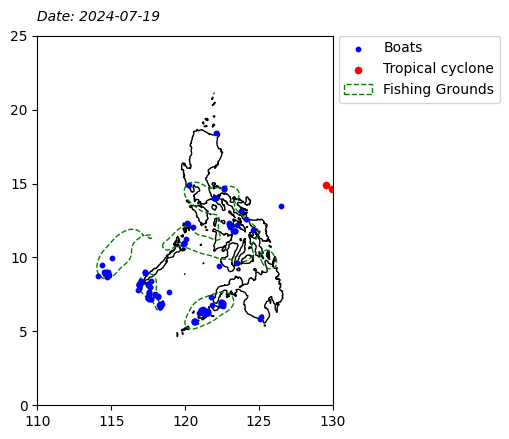

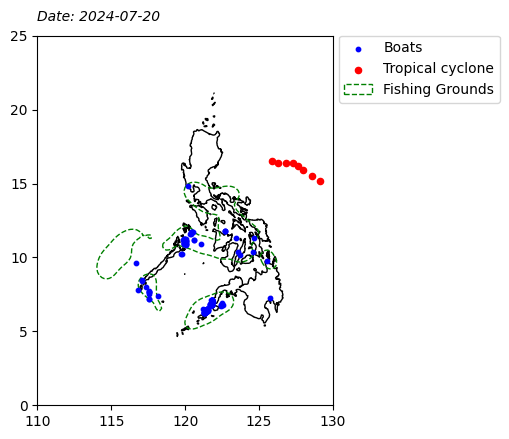

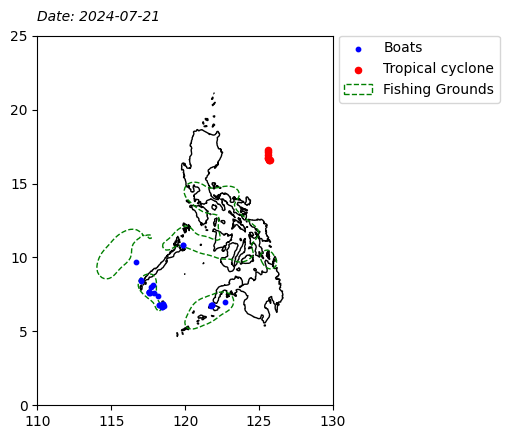

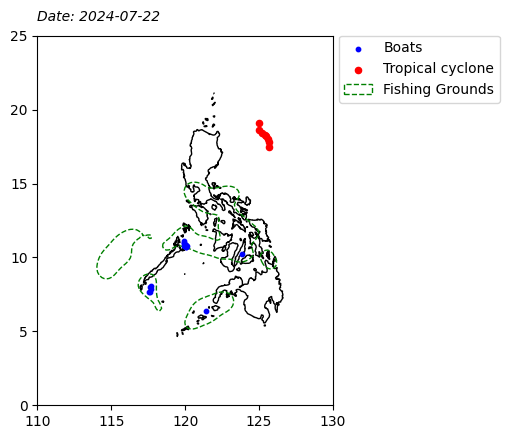

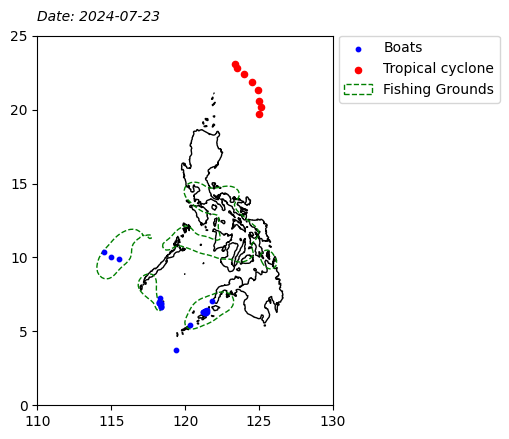

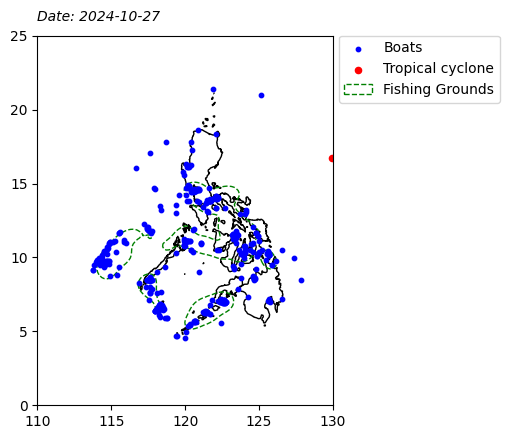

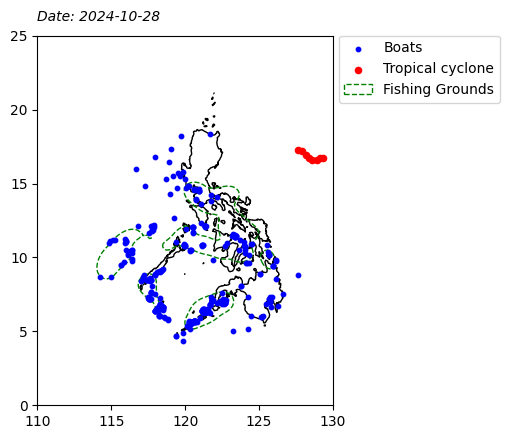

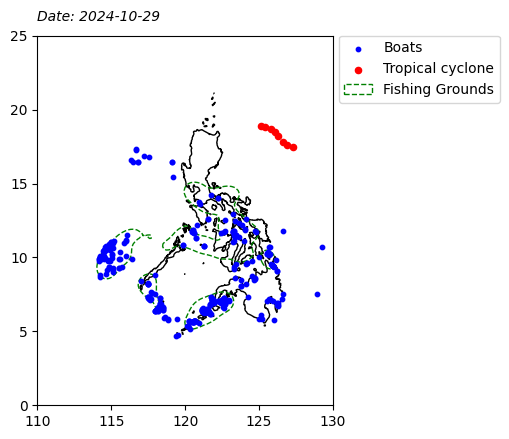

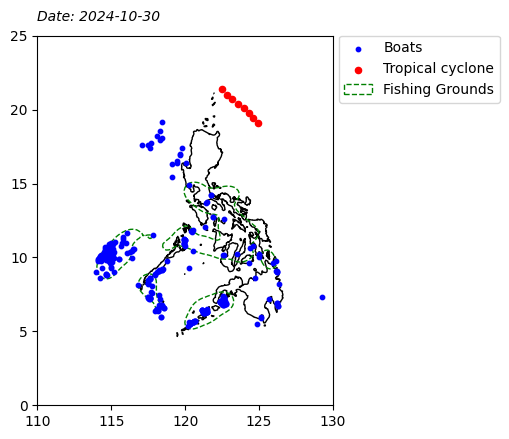

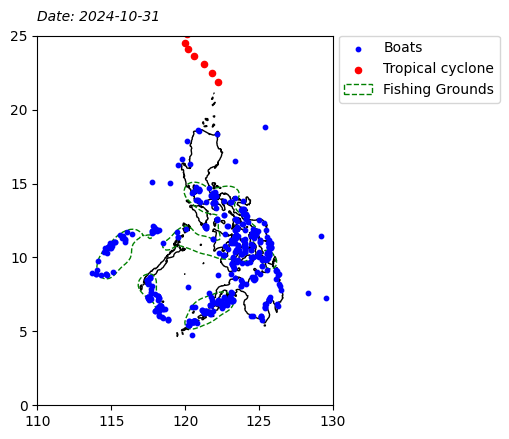

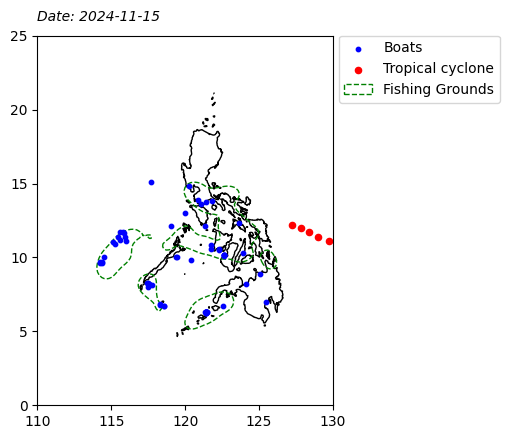

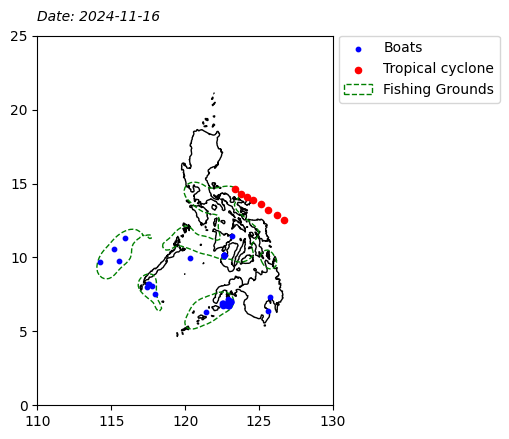

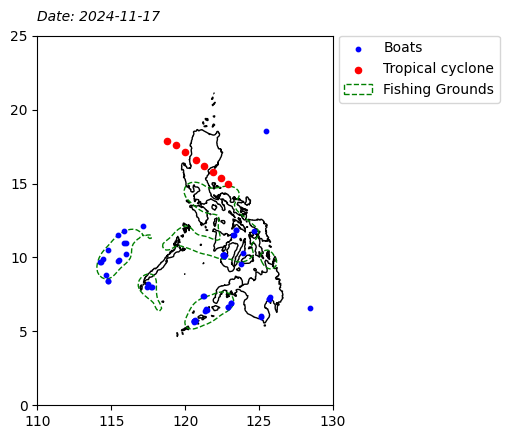

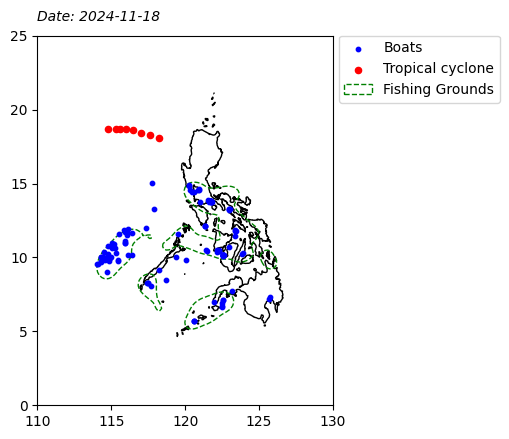

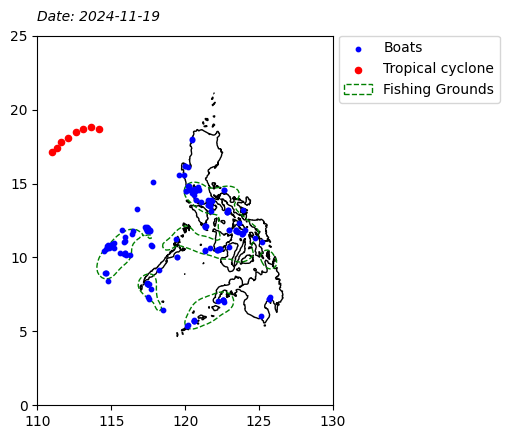

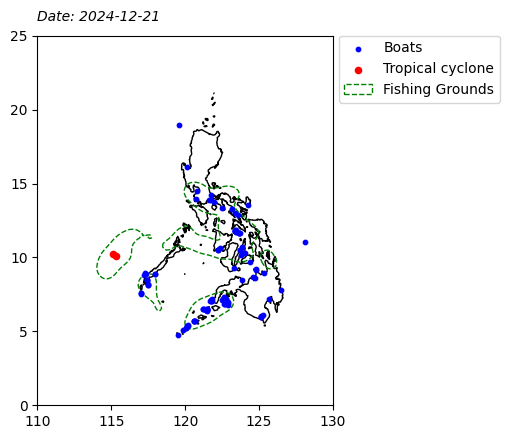

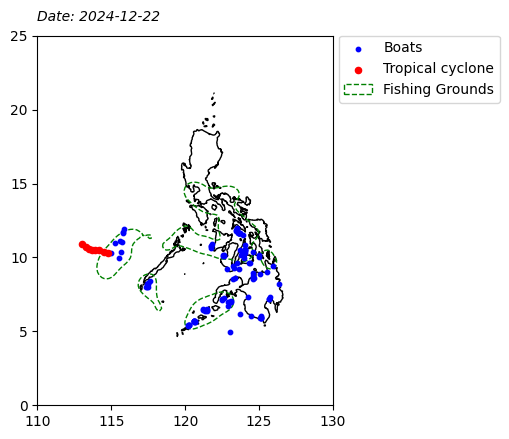

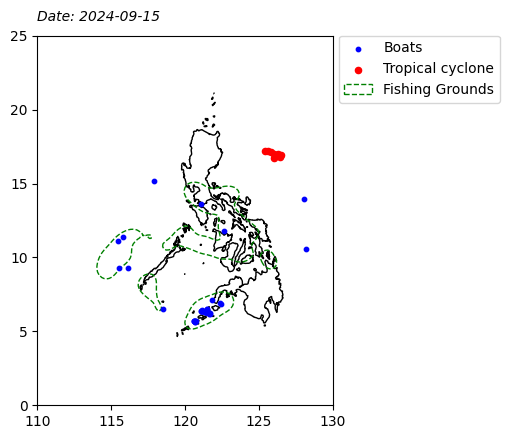

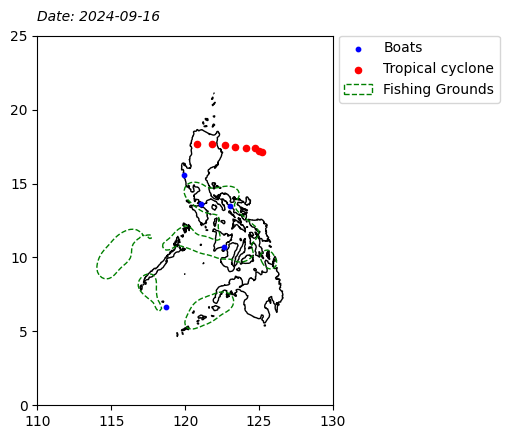

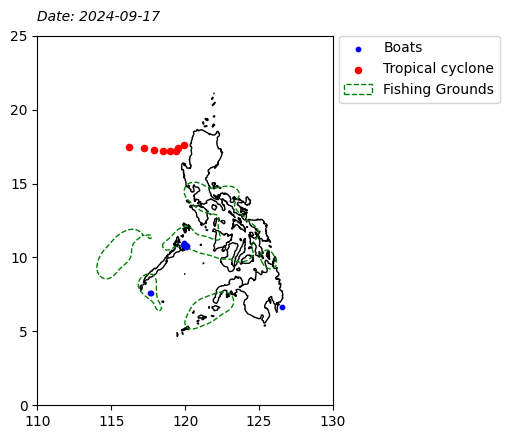

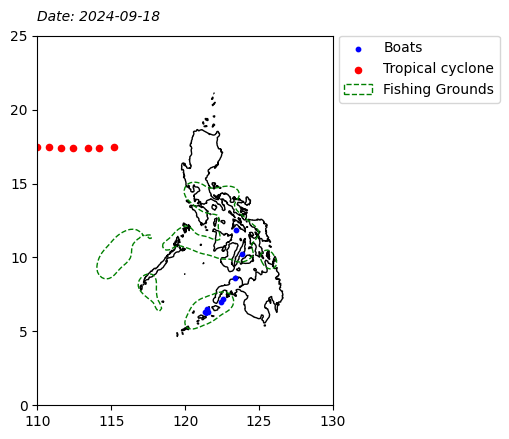

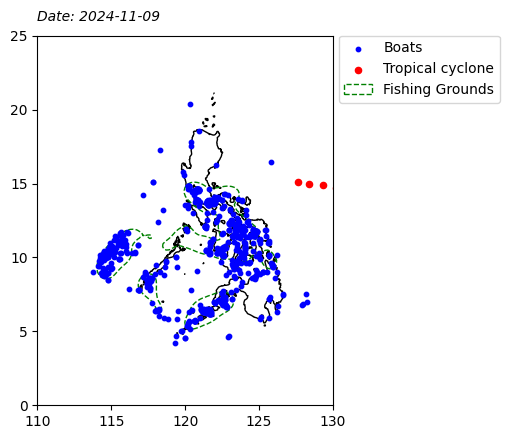

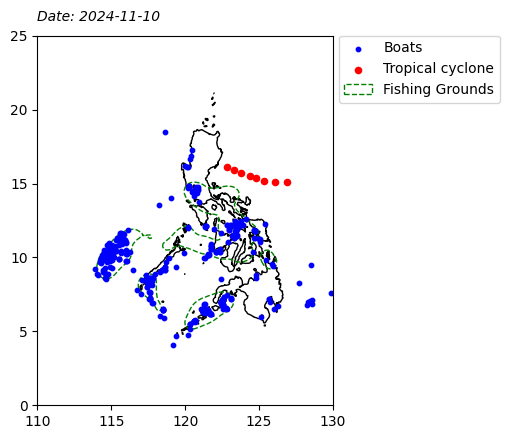

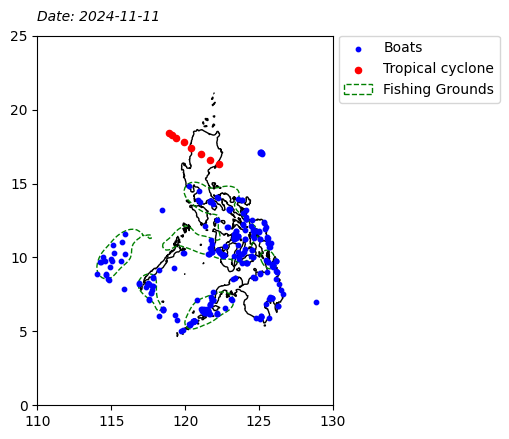

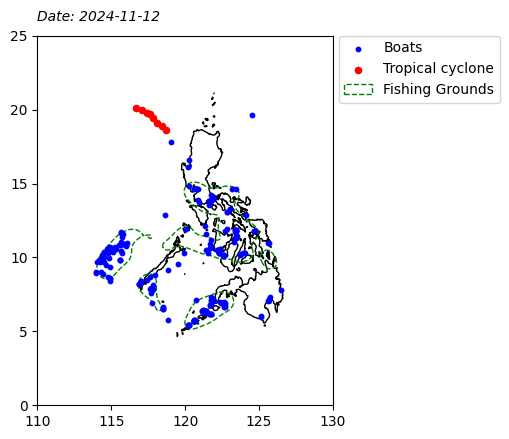

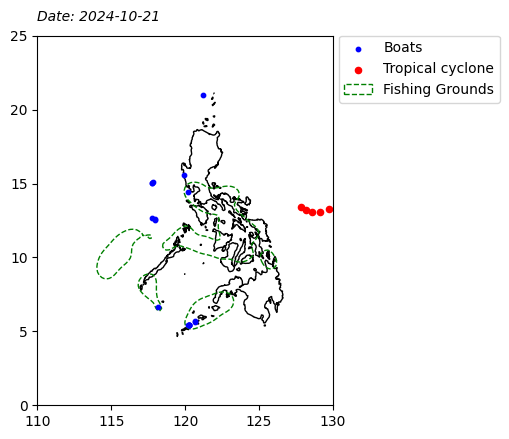

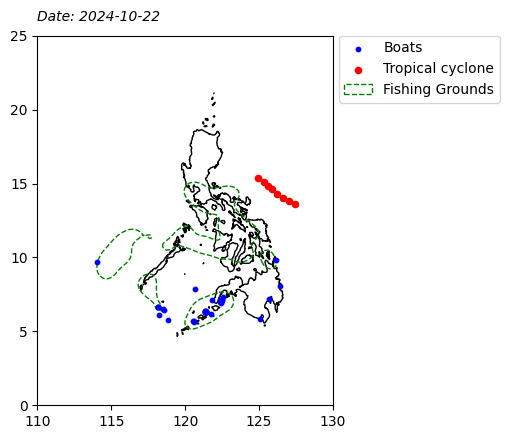

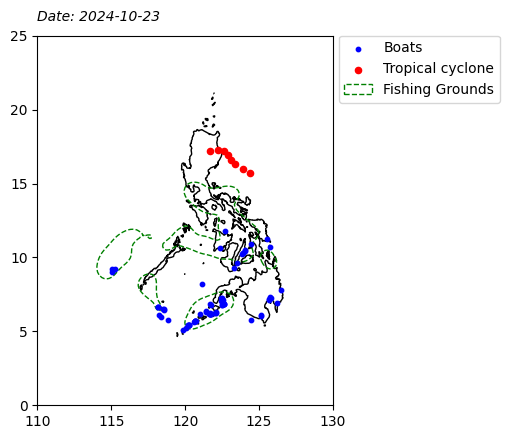

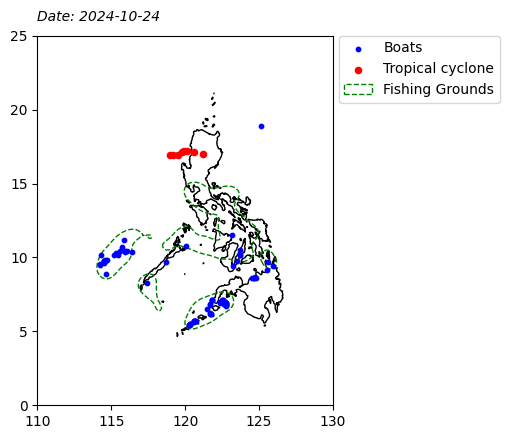

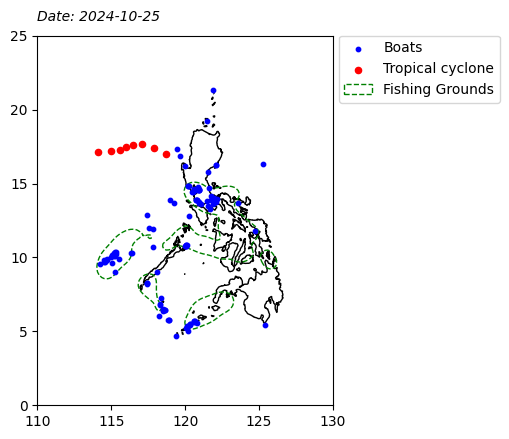

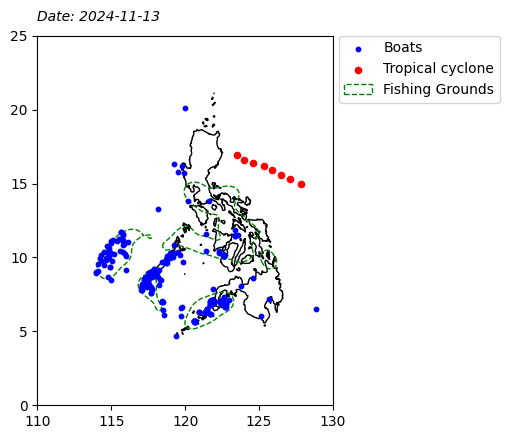

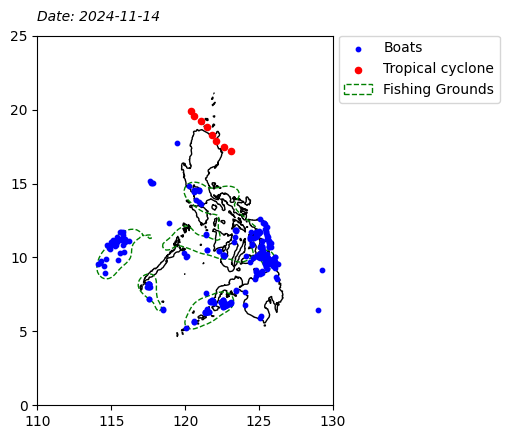

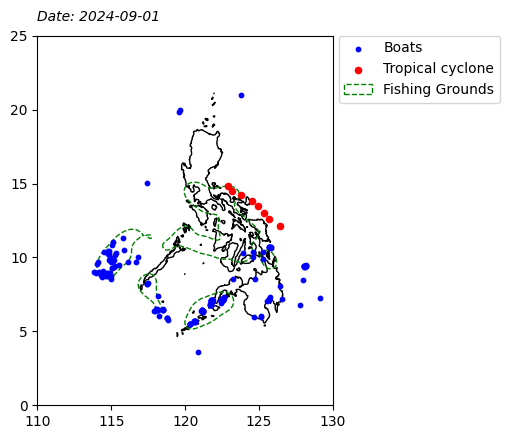

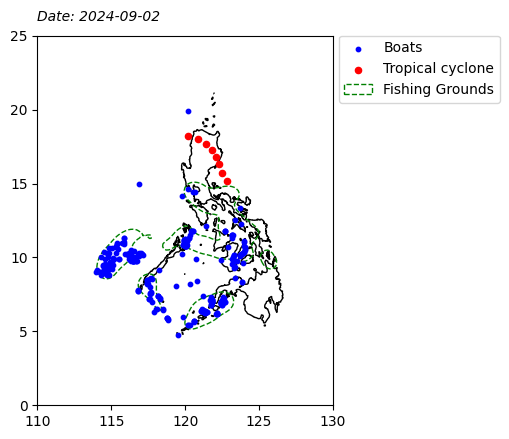

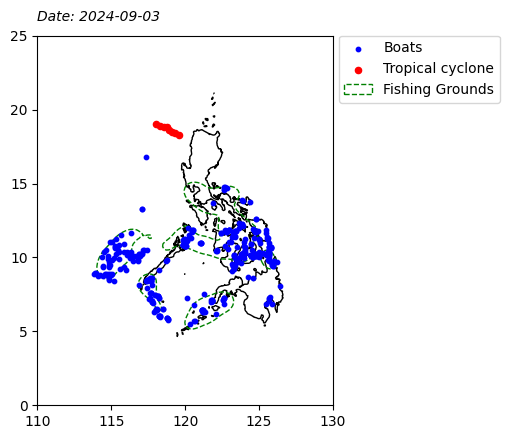

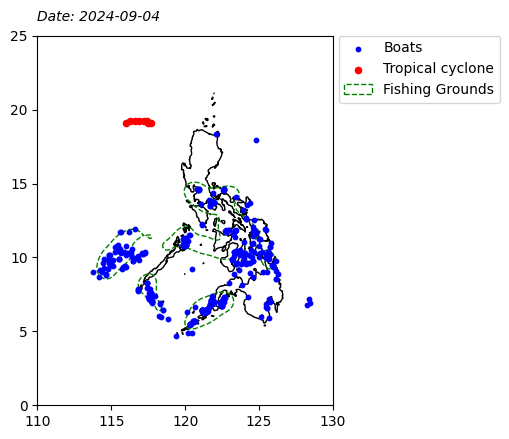

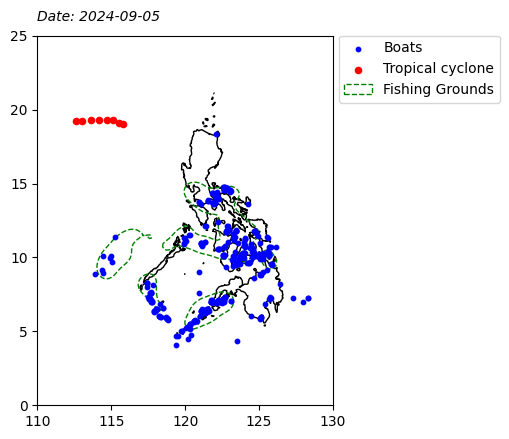

In [109]:
def generate_visualizations_by_cyclone(pivot_table_final, df_all_b, lin11d, pivot_table2, storm_spd_mean_df0, wrdph, merged_gdf, graphs_path):
    """
    Generate visualizations for each cyclone by name and date range.

    Parameters:
    pivot_table_final (DataFrame): DataFrame containing 'date_only' and 'cyclone_name'.
    Other parameters as explained in generate_visualizations().
    """
    grouped = pivot_table_final.groupby('NAME')

    for cyclone_name, group in grouped:
        # dates = group['date_only'].dt.date.unique()
        min_date = group['date_only'].min()
        max_date = group['date_only'].max()
        date_range = pd.date_range(start=min_date, end=max_date)

        # for date in dates:
        for date in date_range:
            visualize_data(date, df_all_b, lin11d, pivot_table2, storm_spd_mean_df0, wrdph, merged_gdf, graphs_path, cyclone_name)

        # Create a GIF for each cyclone
        create_gif(graphs_path, cyclone_name)

def visualize_data(date, df_all_b, lin11d, pivot_table2, storm_spd_mean_df0, wrdph, merged_gdf, graphs_path, cyclone_name):
    """
    Visualize and save a plot for a specific date and cyclone.

    Parameters:
    date (datetime): The date for which to generate the visualization.
    cyclone_name (str): Name of the cyclone for the current visualization.
    Other DataFrames and parameters as explained in generate_visualizations().
    """

    try:
        # Convert date to match date-only comparison format
        date = pd.to_datetime(date).date()
        df_all_b['date_only'] = pd.to_datetime(df_all_b['ISO_TIME']).dt.date
        lin11d['date_only'] = pd.to_datetime(lin11d['ISO_TIME']).dt.date

        # Masking for boats data on the specific date
        boats_on_date = df_all_b[df_all_b['date_only'] == date]

        # Masking for cyclone data that matches the date and cyclone name
        cyclone_on_date = lin11d[(lin11d['date_only'] == date) & (lin11d['NAME'] == cyclone_name)]

        # Plotting
        fig, ax = plt.subplots()
        wrdph.plot(facecolor='none', edgecolor='black', ax=ax)

        # Plot fishing grounds as a dashed outline
        merged_gdf.plot(ax=ax, edgecolor='green', linestyle='--', linewidth=1, facecolor='none')

        # Plot boats and cyclone points if data exists
        if not boats_on_date.empty:
            ax.scatter(boats_on_date['Lon_DNB'], boats_on_date['Lat_DNB'], c='blue', label='Boats', s=10)
        if not cyclone_on_date.empty:
            ax.scatter(cyclone_on_date['LON'], cyclone_on_date['LAT'], c='red', label='Tropical cyclone', s=20)

        # Add only the date text
        ax.text(110, 26, f"Date: {date}", fontsize=10, fontstyle='italic')

        ax.set_xlim(110, 130)
        ax.set_ylim(0, 25)
        ax.set_aspect('equal')

        # Create a manual entry for the fishing grounds to the legend
        fishing_grounds_legend = mpatches.Patch(edgecolor='green', linestyle='--', linewidth=1, facecolor='none', label='Fishing Grounds')

        # Add legend with custom entry for fishing grounds
        handles, labels = ax.get_legend_handles_labels()
        handles.append(fishing_grounds_legend)
        labels.append('Fishing Grounds')
        ax.legend(handles=handles, title='', bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

        plt.savefig(os.path.join(graphs_path, f'{cyclone_name}_{date}.png'), dpi=300, bbox_inches='tight')

    except Exception as e:
        print(f"Error processing date {date} for cyclone {cyclone_name}: {e}")


def create_gif(graphs_path, cyclone_name):
    """
    Create a GIF from a collection of saved images for a specific cyclone.

    Parameters:
    graphs_path (str): Path where images are stored.
    cyclone_name (str): Name of the cyclone for naming the GIF.
    """
    filenames = [os.path.join(graphs_path, file) for file in os.listdir(graphs_path) if file.startswith(cyclone_name)]
    filenames.sort()
    if filenames:
        images = [imageio.imread(f) for f in filenames]
        imageio.mimsave(os.path.join(graphs_path, f'gif_{cyclone_name}.gif'), images, duration=0.5)
    else:
        print(f"No images found for cyclone {cyclone_name}, skipping GIF creation.")

generate_visualizations_by_cyclone(pivot_table_final, df_all_b, lin11d, pivot_table2, storm_spd_mean_df0, wrdph, merged_gdf, graphs_path)